<a id="top"></a>
# Interpreting Convolutional Neural Networks

***

## Learning Goals


**In this tutorial, you will practice analyzing and interpreting a convolutional neural network.**
 This tutorial assumes a basic knowledge of convolutional neural networks. We will utilize the model described in `Classifying_JWST-HST_galaxy_mergers_with_CNNs`, so it is recommended to complete that notebook before reading this one.

## Introduction
Machine learning techniques can be powerful tools for categorizing data and performing data analysis questions. However, machine learning techniques often involve a lot of hidden computation that is not immediately meaningful. The black-box nature of intermediary processes, especially in layered neural networks, can make it difficult to interpret and understand. The goal of this notebook is to familiarize you with some of the various techniques used to make sense of machine learning and convolutional neural networks (CNNs) in particular. CNNs in particular can be very difficult to interpret due to their multi-layered structure and convolutional layers. In this notebook, we will examine two methods of visualizing CNN results (Backpropagation and Grad-CAM) and another method for testing model architecture.

1. Load the data
2. Split the data into training, validation, and testing sets
3. Build and train a model
4. Apply some interpretation technique to understand your results from a physical perspective.


### Dependencies

This notebook uses the following packages:
- `numpy` to handle array functions
- `astropy` for downloading and accessing FITS files
- `matplotlib.pyplot` for plotting data
- `keras` and `tensorflow` for building the CNN
- `sklearn` for some utility functions

If you do not have these packages installed, you can install them using [`pip`](https://pip.pypa.io/en/stable/) or [`conda`](https://docs.conda.io/en/latest/).

Further information about the original model can be found at the [Hello Universe codebase](https://spacetelescope.github.io/hellouniverse/notebooks/hello-universe/Classifying_JWST-HST_galaxy_mergers_with_CNNs/Classifying_JWST-HST_galaxy_mergers_with_CNNs.html).


**Author:**  
Oliver Lin, oliverlin2004@gmail.com

**Additional Contributors:**  
Daisuke Nagai, daisuke.nagai@yale.edu.

Michelle Ntampaka, mntampaka@stsci.edu.

**Published:** 2024-05-08

In [1]:
# arrays
import numpy as np

# fits
from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import simple_norm

# plotting
from matplotlib import pyplot as plt

# keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Convolution2D, MaxPooling2D
# from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.regularizers import l2

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow for saliency
import tensorflow as tf
import cv2

2025-08-03 19:34:30.983743: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 19:34:31.015082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-03 19:34:31.015105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-03 19:34:31.016123: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-03 19:34:31.021532: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-03 19:34:31.022232: I tensorflow/core/platform/cpu_feature_guard.cc:1

2025-08-03 19:34:31.729986: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reloading our Model
To start, we need to reload our model from the previous galaxy classification notebook from the Mikulski Archive for Space Telescopes (MAST). The following code is directly copied over from that notebook. For a quick refresher, the model intakes a FITS file from a high level science product hosted by MAST. There are 15,426 observations in total, each taken with three filters (F814W from the Advanced Camera for Surveys and F160W from the Wide Field Camera 3 on the Hubble Space Telescope (HST), and F160W and F356W from Near Infrared Camera on the James Webb Space Telescope (JWST)). The model then applies a Convolutional Neural Network to classify whether a galaxy has undergone a merger.

In [2]:
version = 'pristine'
file_url = 'https://archive.stsci.edu/hlsps/deepmerge/hlsp_deepmerge_hst-jwst_acs-wfc3-nircam_illustris-z2_f814w-f160w-f356w_v1_sim-'+version+'.fits'
hdu = fits.open(download_file(file_url, cache=True, show_progress=True))

## Build and Compile the Convolutional Model
For the sake of transparency, we will rebuild the model using the same architecture as the original notebook. The model can also be loaded directly by using `save_model` and `load_model` from the [Keras](https://www.tensorflow.org/guide/keras/serialization_and_saving) package. 

In [3]:
X = hdu[0].data
y = hdu[1].data

Following the authors, we will split the data into 70:10:20 ratio of train:validate:test. As above, set the random seed to randomly split the images in a repeatable way. Feel free to try different values!



In [4]:
random_state = 42

X = np.asarray(X).astype('float32')
y = np.asarray(y).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_split, y_train, y_split = train_test_split(X, y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, y_valid, y_test = train_test_split(X_split, y_split, test_size=0.666, random_state=random_state, shuffle=True)

In [5]:
imsize = np.shape(X_train)[2]

X_train = np.array([np.stack(x, axis=2) for x in X_train])
X_valid = np.array([np.stack(x, axis=2) for x in X_valid])
X_test = np.array([np.stack(x, axis=2) for x in X_test])

### Generate the model architecture (written for Keras 2)

In [6]:
# Define architecture for model
data_shape = np.shape(X)
input_shape = (imsize, imsize, 3)

x_in = Input(shape=input_shape)
c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
b0 = BatchNormalization()(c0)
d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
e0 = Dropout(0.5)(d0)

c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
b1 = BatchNormalization()(c1)
d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
e1 = Dropout(0.5)(d1)

c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
b2 = BatchNormalization()(c2)
d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
e2 = Dropout(0.5)(d2)

f = Flatten()(e2)
z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
y_out = Dense(1, activation='sigmoid')(z1)

cnn = Model(inputs=x_in, outputs=y_out)

### Compile Model

In [7]:
optimizer = 'adam'
fit_metrics = ['accuracy']
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)

### Load pretrained weights


In [8]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_interpretability_best_weights.hdf5'
cnn.load_weights(download_file(file_url, cache=True, show_progress=True))

2025-08-03 19:34:34.014454: W tensorflow/core/util/tensor_slice_reader.cc:98] Could not open /home/runner/.astropy/cache/download/url/75479cba1a5e1313befcce7b9c2f3f36/contents: DATA_LOSS: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?


## 1. Saliency Maps
We will start by introducing the most popular and well known method of interpreting CNNs. A saliency map can help us identify which pixels are significant to the models final prediction. There are many methods of calculating saliency maps, but the most popular method utilizes gradient backpropagation to determine the significance of pixels at each layer of the model. To calculate the saliency map, the error gradient at each layer is calculated and then fed into the previous layer, repeating until we reach the original image. Then the pixels with the highest gradient values will also have the most effect on the model's activation. This methodology is described in detail by <a href='https://arxiv.org/abs/1312.6034'>Simonyan et al. 2013</a>. 

### Dependencies

`tensorflow.GradientTape()` is used to track the gradient of the function.


In [9]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [10]:
images = tf.Variable(img, dtype=float)

# Make a prediction and track gradients
with tf.GradientTape() as tape:
    pred = cnn(images, training=False)
    class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
    loss = pred[class_idxs_sorted[0]]

grads = tape.gradient(loss, images)

### Plot the original image and the saliency map

Saliency maps provide an intuitive understanding of how the model works. The hot pixels represent higher activation and more importance. In the below model, the saliency maps demonstrates that the model focuses on the area around the center of the galaxy for the majority of galaxies. Our results are in line with a corroborating result by [Ntampaka et al. 2018](https://arxiv.org/abs/1810.07703), suggesting that the key features of a galaxy are found the ring around the galaxy rather than in the center of the galaxy.

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 90ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

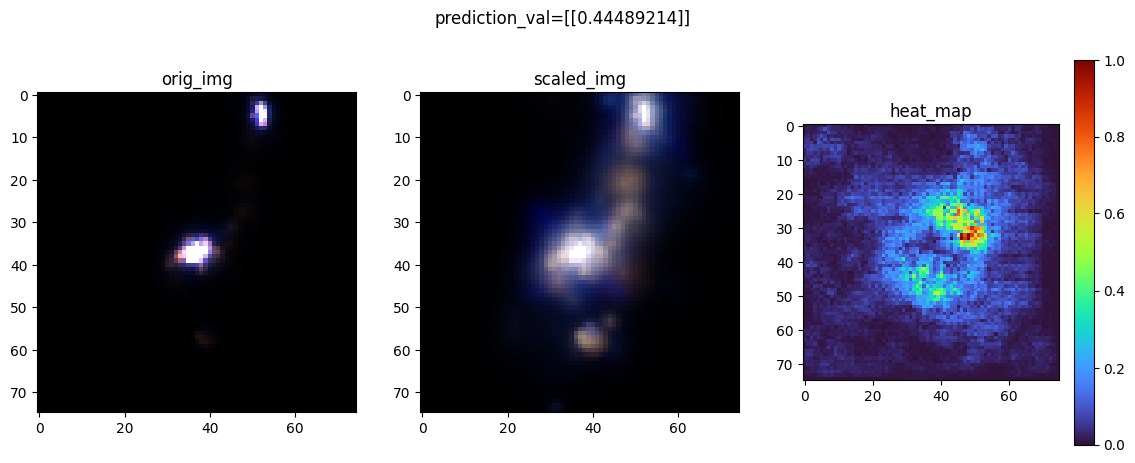

In [11]:
y_pred = cnn.predict(img)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

# normalize to range between 0 and 1
arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(grad_eval, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the saliency map.

### Create a stack of saliency images

To understand the overall behavior of our algorithm, we can stack some or all of the saliency maps in the test set to generate an overarching estimate of important pixels. For the sake of simplicity, we will stack the saliency maps for the first 100 images in the test set. Our results once again indicate that the region around a galaxy is particularly important to the model.

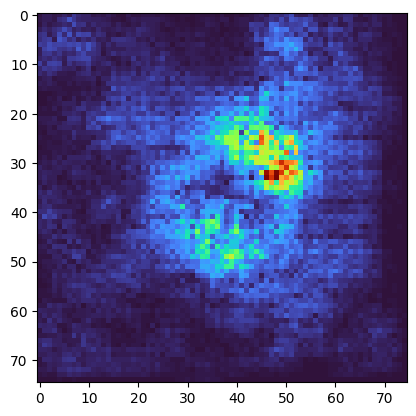

In [12]:
sum_map = np.zeros((75, 75))
# Summing the first 100 saliencies. We can change
# the range to sum more or less saliencies or pick 
# specific ones
for i in range(100):
    img = X_test[img_idx]
    img = img.reshape((1, *img.shape))
    images = tf.Variable(img, dtype=float)

    # Make a prediction and track gradients
    with tf.GradientTape() as tape:
        pred = cnn(images, training=False)
        class_idxs_sorted = np.argsort(pred.numpy().flatten())[::-1]    
        loss = pred[class_idxs_sorted[0]]

    grads = tape.gradient(loss, images)

    y_pred = cnn.predict(images, verbose=0)

    dgrad_abs = tf.math.abs(grads)
    dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

    # normalize to range between 0 and 1
    arr_min, arr_max = np.min(dgrad_max_), np.max(dgrad_max_)
    grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min)
    sum_map += grad_eval
plt.imshow(sum_map, cmap='turbo')

**Image caption**: The above image contains a single panel, and shows a stacked version of the saliency maps from 100 images.

## 2. Grad-CAM
While gradient backpropagation has historically been the most popular type of saliency map, the highly connected nature of backtracking has been shown to produce high variance under small changes to inputs. As such, gradient backpropagation is extremely sensitive to data manipulation (preprocessing, sensitivity analysis, GANs), raising questions about its reliability and validity. Gradient Class Activation Mapping (Grad-CAM) is an alternative method for generating saliency models that only examines the gradient of the final convolutional layer when producing the map. As a consequence, Grad-CAM maps have lower (coarser) resolution than backpropagation but are far more resilient to small changes and therefore more reliable when tuning a model. A full description of the technique can be found in <a href='https://arxiv.org/abs/1610.02391'>Selveraju et al. 2016</a>.

The code for Grad-CAM comes from a useful tutorial on the subject by Daniel Reiff. For more information, please visit the  <a href='https://towardsdatascience.com/understand-your-algorithm-with-grad-cam-d3b62fce353'>full tutorial</a>.

### Dependencies

`Open_CV` and `astropy.simple_norm` are used to do manipulate the image for display. Alternatively, we could allow Python to automatically clip the image when the heatmap is out of range.

In [13]:
# Choose the image to analyze
img_idx = 1

# We can change the index to any number in range of the test set
orig_img = X_test[img_idx]
img = orig_img
img = img.reshape((1, *img.shape))
norm = simple_norm(orig_img, 'log', max_percent=99.75)
scaled_img = norm(orig_img)

In [14]:
# Note: recompiling the model will change the layer
# name. In that case, you can either restart the 
# kernel or change the layer_name.
# We can also change the layer selected here to pull out any layer of our model
gradModel = Model(inputs=[cnn.inputs], outputs=[cnn.get_layer("conv2d_2").output, cnn.output])

with tf.GradientTape() as tape:
    # get the loss with associated with the prediction
    inputs = tf.cast(X_test, tf.float32)
    (convOutputs, predictions) = gradModel(inputs)
    loss = predictions[:, 0]
    
# use automatic differentiation to compute the gradients
grads = tape.gradient(loss, convOutputs)

# compute the guided gradients by removing all nonpositive
# gradients
castConvOutputs = tf.cast(convOutputs > 0, "float32")
castGrads = tf.cast(grads > 0, "float32")
guidedGrads = castConvOutputs * castGrads * grads

# pick out the convolution and gradient of the chosen image
convOutputs = convOutputs[img_idx]
guidedGrads = guidedGrads[img_idx]

# compute the average of the gradient values, and using them
# as weights, compute the importance of the pieces
weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

# grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
(w, h) = (X_test.shape[2], X_test.shape[1])
heatmap = cv2.resize(cam.numpy(), (w, h))

# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer

2025-08-03 19:34:36.999949: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-03 19:34:37.832093: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-03 19:34:37.903303: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.
2025-08-03 19:34:37.942137: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


2025-08-03 19:34:39.395528: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 554940000 exceeds 10% of free system memory.


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [1.822696e-08..8.880155].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.2109969226408994].


Text(0.5, 0.98, 'prediction_val=[[0.44489214]]')

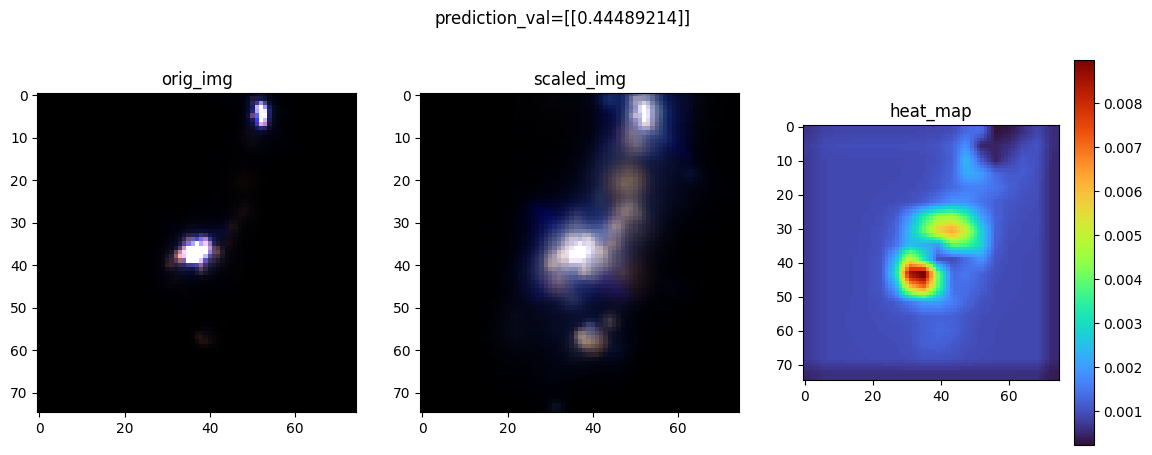

In [15]:
y_pred = cnn.predict(img)

# Plot the results next to the original image
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_img)
axes[0].set_title("orig_img")
axes[1].imshow(scaled_img)
axes[1].set_title("scaled_img")
i = axes[2].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[2].set_title("heat_map")
fig.suptitle("prediction_val=" + str(y_pred))

**Image caption**: The above image contains three panels in a horizontal row. The first panel shows the original image of a merging galaxy candidate, the second panel shows a logarithmically-scaled version of the original image, and the third panel shows a heat map of the grad-cam map.

**The result is very similar** to our saliency map from backpropagation, although the image is coarser and also shows both the top and bottom of the galaxy. We can also play around with the selected layer to calculate the output at different steps in the model and see how activation changes throughout the model.

## 3. RISE Algorithm
The RISE (Randomized Input Sampling for Explanation) Algorithm is another interpretation technique for calculating saliency maps. Instead of calculating gradients from within the model, the RISE implementation works by covering up pieces of the input image, running it through the model, and calculating the average activation in order to determine what parts of the image are most important. As such, this method does not require any access to the inner workings of the model. The algorithm first generates a random sequence of binary grids (called masks), which are placed onto the image. Everything not covered by the mask is removed by multiplying the images together, and the resultant activations are averaged to get our final heatmap. A full description of the algorithm and its variations is provided by <a href='https://arxiv.org/abs/1806.07421'>Petsiuk et al. 2018</a>. 



In [16]:
# Choose the image to analyze
img_idx = 6

# We can change the index to any number in range of the test set
image = X_test[img_idx]

N = 1000  # Number of masks
s = 8     # Size of the grid
p1 = 0.5  # Probability of the cell being set to 1

cell_size = np.ceil(np.array(input_shape[:2]) / s).astype(int)
up_size = (s * cell_size).astype(int)

grid = np.random.rand(N, s, s) < p1
masks = np.empty((N, *input_shape[:2]))

for i in range(N):
    # Randomly place the grid on the image
    x = np.random.randint(0, input_shape[0]-s)
    y = np.random.randint(0, input_shape[1]-s)
    mask = np.pad(grid[i], ((x, input_shape[0]-x-s), (y, input_shape[0]-y-s)), 'constant', constant_values=(0, 0))
    mask = mask[:input_shape[0], :input_shape[1]]
    masks[i] = mask

masks = masks.reshape(-1, *input_shape[:2], 1)

N = len(masks)
pred_masks = cnn.predict(image * masks)
pred_masks = np.expand_dims(pred_masks, axis=-1)
pred_masks = np.expand_dims(pred_masks, axis=-1) # Reshape pred_masks for broadcasting
heatmap = (pred_masks * masks).sum(axis=0)
heatmap = heatmap / N / p1

 1/32 [..............................] - ETA: 0s

 5/32 [===>..........................] - ETA: 0s

 9/32 [=======>......................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 1s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00022207294..674.50696].


Text(0.5, 1.0, 'heat_map')

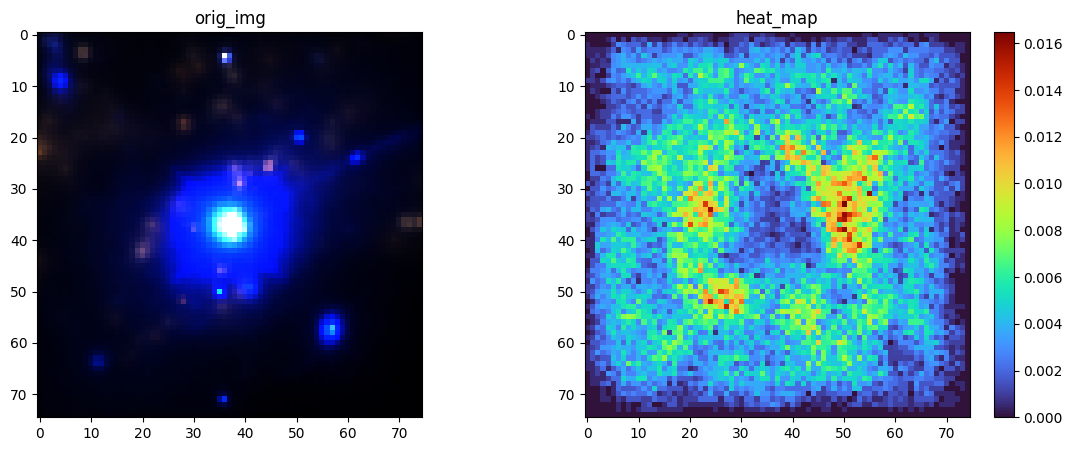

In [17]:
# Plot the results next to the original image
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].imshow(image)
axes[0].set_title("orig_img")
i = axes[1].imshow(heatmap, cmap="turbo")
fig.colorbar(i)
axes[1].set_title("heat_map")

**Image caption**: The above image contains two panels in a horizontal row. The first panel shows the original image of a merginig galaxy candidate, and the second panel shows a heat map of the RISE map.

**When examining the selected image**, we see a ring around the galactic center. Note that this is not the case for all astronomical images, or even all images in this dataset. Try playing around with the selected image to generate different saliency maps. For images where the central feature is relatively small, RISE's occlusion-based methodology can be unreliable.

## 4. Ablation Analysis
Saliency maps provide an intuitive visual understanding of our model's focus and can be useful for understanding the physical relevance of our classification scheme. In order to understand the efficacy of our model's architecture, we can instead use ablation analysis to determine the most important layers of our model. Ablation analysis works by rebuilding our model without a specified layer of interest and testing and comparing the performance of a partial model. Since we are focusing on our model's internal architecture rather than the features of the dataset we are looking at, we want to use this technique when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our mode

In the exercise below, we will build and train four mini-models on the same data set as before. As this is an educational notebook, we will limit the training time of each model to five epochs. Results with these models may vary considerably due to these training constraints, but we highly encourage you to try modifying this section of the notebook for different results (see [Exercises](#Exercises/Extensions))

Note that performing an ablation analysis will require training multiple models with the same architecture. This can be quite compute intensive on personal computers, so if you are running this notebook locally it is recommended that your device be plugged in before running the analysis.

### Dependencies

`Tensorflow` is used build our model and train it.

In [18]:
def create_model(ablate=None):
    x_in = Input(shape=input_shape)
    
    if ablate != 'c0':
        c0 = Convolution2D(8, (5, 5), activation='relu', strides=(1, 1), padding='same')(x_in)
    else:
        c0 = x_in
    b0 = BatchNormalization()(c0)
    d0 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b0)
    e0 = Dropout(0.5)(d0)

    if ablate != 'c1':
        c1 = Convolution2D(16, (3, 3), activation='relu', strides=(1, 1), padding='same')(e0)
    else:
        c1 = e0
    b1 = BatchNormalization()(c1)
    d1 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b1)
    e1 = Dropout(0.5)(d1)

    if ablate != 'c2':
        c2 = Convolution2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same')(e1)
    else:
        c2 = e1
    b2 = BatchNormalization()(c2)
    d2 = MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid')(b2)
    e2 = Dropout(0.5)(d2)

    f = Flatten()(e2)
    z0 = Dense(64, activation='softmax', kernel_regularizer=l2(0.0001))(f)
    z1 = Dense(32, activation='softmax', kernel_regularizer=l2(0.0001))(z0)
    y_out = Dense(1, activation='sigmoid')(z1)

    cnn = Model(inputs=x_in, outputs=y_out)
    return cnn

**Since ablation analysis requires training multiple models**, it can often be more resource intensive than other methods. However, it can also provide useful information on the way features are organized during training. The following cell can be edited to change how much we want to train our mini-models.

In [19]:
# You can change how much to train each model
# 5 epochs is chosen due to time and computation constraints
num_epochs = 5

# Train the original model
model = create_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))

# Get baseline performance
baseline_score = model.evaluate(X_test, y_test)

# Ablate each layer and compare performance
layers_to_ablate = ['c0', 'c1', 'c2']
for layer in layers_to_ablate:
    model_ablated = create_model(ablate=layer)
    model_ablated.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model_ablated.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test))
    ablated_score = model_ablated.evaluate(X_test, y_test)
    
    print(f"Performance drop after ablating {layer}: {baseline_score[1] - ablated_score[1]}")

Epoch 1/5


  1/338 [..............................] - ETA: 6:20 - loss: 0.7009 - accuracy: 0.6875

  2/338 [..............................] - ETA: 19s - loss: 0.7047 - accuracy: 0.6094 

  3/338 [..............................] - ETA: 19s - loss: 0.7069 - accuracy: 0.5625

  4/338 [..............................] - ETA: 19s - loss: 0.7075 - accuracy: 0.5469

  5/338 [..............................] - ETA: 19s - loss: 0.7084 - accuracy: 0.5250

  6/338 [..............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5417

  7/338 [..............................] - ETA: 18s - loss: 0.7062 - accuracy: 0.5536

  8/338 [..............................] - ETA: 18s - loss: 0.7050 - accuracy: 0.5664

  9/338 [..............................] - ETA: 18s - loss: 0.7063 - accuracy: 0.5417

 10/338 [..............................] - ETA: 18s - loss: 0.7071 - accuracy: 0.5250

 11/338 [..............................] - ETA: 18s - loss: 0.7075 - accuracy: 0.5142

 12/338 [>.............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5130

 13/338 [>.............................] - ETA: 18s - loss: 0.7072 - accuracy: 0.5096

 14/338 [>.............................] - ETA: 18s - loss: 0.7073 - accuracy: 0.5045

 15/338 [>.............................] - ETA: 18s - loss: 0.7070 - accuracy: 0.5042

 16/338 [>.............................] - ETA: 18s - loss: 0.7067 - accuracy: 0.5059

 17/338 [>.............................] - ETA: 18s - loss: 0.7065 - accuracy: 0.5037

 18/338 [>.............................] - ETA: 17s - loss: 0.7064 - accuracy: 0.5017

 19/338 [>.............................] - ETA: 17s - loss: 0.7061 - accuracy: 0.5033

 20/338 [>.............................] - ETA: 17s - loss: 0.7057 - accuracy: 0.5063

 21/338 [>.............................] - ETA: 17s - loss: 0.7056 - accuracy: 0.5045

 22/338 [>.............................] - ETA: 17s - loss: 0.7054 - accuracy: 0.5043

 23/338 [=>............................] - ETA: 17s - loss: 0.7051 - accuracy: 0.5068

 24/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.5039

 25/338 [=>............................] - ETA: 17s - loss: 0.7050 - accuracy: 0.5000

 26/338 [=>............................] - ETA: 17s - loss: 0.7049 - accuracy: 0.4976

 27/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4988

 28/338 [=>............................] - ETA: 17s - loss: 0.7048 - accuracy: 0.4922

 29/338 [=>............................] - ETA: 17s - loss: 0.7047 - accuracy: 0.4903

 30/338 [=>............................] - ETA: 17s - loss: 0.7046 - accuracy: 0.4906

 31/338 [=>............................] - ETA: 17s - loss: 0.7042 - accuracy: 0.4940

 32/338 [=>............................] - ETA: 17s - loss: 0.7043 - accuracy: 0.4893

 33/338 [=>............................] - ETA: 16s - loss: 0.7041 - accuracy: 0.4896

 34/338 [==>...........................] - ETA: 16s - loss: 0.7039 - accuracy: 0.4917

 35/338 [==>...........................] - ETA: 16s - loss: 0.7037 - accuracy: 0.4911

 36/338 [==>...........................] - ETA: 16s - loss: 0.7035 - accuracy: 0.4922

 37/338 [==>...........................] - ETA: 16s - loss: 0.7034 - accuracy: 0.4932

 38/338 [==>...........................] - ETA: 16s - loss: 0.7034 - accuracy: 0.4885

 39/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4888

 40/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4852

 41/338 [==>...........................] - ETA: 16s - loss: 0.7032 - accuracy: 0.4825

 42/338 [==>...........................] - ETA: 16s - loss: 0.7030 - accuracy: 0.4844

 43/338 [==>...........................] - ETA: 16s - loss: 0.7028 - accuracy: 0.4862

 44/338 [==>...........................] - ETA: 16s - loss: 0.7027 - accuracy: 0.4879

 45/338 [==>...........................] - ETA: 16s - loss: 0.7026 - accuracy: 0.4868

 46/338 [===>..........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4837

 47/338 [===>..........................] - ETA: 16s - loss: 0.7025 - accuracy: 0.4820

 48/338 [===>..........................] - ETA: 16s - loss: 0.7024 - accuracy: 0.4818

 49/338 [===>..........................] - ETA: 16s - loss: 0.7023 - accuracy: 0.4802

 50/338 [===>..........................] - ETA: 15s - loss: 0.7023 - accuracy: 0.4787

 51/338 [===>..........................] - ETA: 15s - loss: 0.7022 - accuracy: 0.4773

 52/338 [===>..........................] - ETA: 15s - loss: 0.7021 - accuracy: 0.4766

 53/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.4758

 54/338 [===>..........................] - ETA: 15s - loss: 0.7020 - accuracy: 0.4734

 55/338 [===>..........................] - ETA: 15s - loss: 0.7019 - accuracy: 0.4733

 56/338 [===>..........................] - ETA: 15s - loss: 0.7018 - accuracy: 0.4749

 57/338 [====>.........................] - ETA: 15s - loss: 0.7016 - accuracy: 0.4764

 58/338 [====>.........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.4774

 59/338 [====>.........................] - ETA: 15s - loss: 0.7015 - accuracy: 0.4767

 60/338 [====>.........................] - ETA: 15s - loss: 0.7014 - accuracy: 0.4771

 61/338 [====>.........................] - ETA: 15s - loss: 0.7013 - accuracy: 0.4790

 62/338 [====>.........................] - ETA: 15s - loss: 0.7012 - accuracy: 0.4773

 63/338 [====>.........................] - ETA: 15s - loss: 0.7011 - accuracy: 0.4787

 64/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4771

 65/338 [====>.........................] - ETA: 15s - loss: 0.7010 - accuracy: 0.4784

 66/338 [====>.........................] - ETA: 15s - loss: 0.7009 - accuracy: 0.4782

 67/338 [====>.........................] - ETA: 15s - loss: 0.7008 - accuracy: 0.4781

 68/338 [=====>........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4798

 69/338 [=====>........................] - ETA: 14s - loss: 0.7007 - accuracy: 0.4810

 70/338 [=====>........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.4812

 71/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4793

 72/338 [=====>........................] - ETA: 14s - loss: 0.7005 - accuracy: 0.4805

 73/338 [=====>........................] - ETA: 14s - loss: 0.7004 - accuracy: 0.4829

 74/338 [=====>........................] - ETA: 14s - loss: 0.7003 - accuracy: 0.4856

 75/338 [=====>........................] - ETA: 14s - loss: 0.7002 - accuracy: 0.4879

 76/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4897

 77/338 [=====>........................] - ETA: 14s - loss: 0.7001 - accuracy: 0.4903

 78/338 [=====>........................] - ETA: 14s - loss: 0.7000 - accuracy: 0.4904

 79/338 [======>.......................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4937

 80/338 [======>.......................] - ETA: 14s - loss: 0.6999 - accuracy: 0.4922

 81/338 [======>.......................] - ETA: 14s - loss: 0.6998 - accuracy: 0.4938

 82/338 [======>.......................] - ETA: 14s - loss: 0.6997 - accuracy: 0.4958

 83/338 [======>.......................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4970

 84/338 [======>.......................] - ETA: 14s - loss: 0.6996 - accuracy: 0.4974

 85/338 [======>.......................] - ETA: 14s - loss: 0.6995 - accuracy: 0.4985

 86/338 [======>.......................] - ETA: 13s - loss: 0.6995 - accuracy: 0.4978

 87/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.4971

 88/338 [======>.......................] - ETA: 13s - loss: 0.6994 - accuracy: 0.4972

 89/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4965

 90/338 [======>.......................] - ETA: 13s - loss: 0.6993 - accuracy: 0.4976

 91/338 [=======>......................] - ETA: 13s - loss: 0.6992 - accuracy: 0.4986

 92/338 [=======>......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.4986

 93/338 [=======>......................] - ETA: 13s - loss: 0.6991 - accuracy: 0.5000

 94/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.4993

 95/338 [=======>......................] - ETA: 13s - loss: 0.6990 - accuracy: 0.4997

 96/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.4997

 97/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.4987

 98/338 [=======>......................] - ETA: 13s - loss: 0.6989 - accuracy: 0.4987

 99/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.4997

100/338 [=======>......................] - ETA: 13s - loss: 0.6988 - accuracy: 0.4997

101/338 [=======>......................] - ETA: 13s - loss: 0.6987 - accuracy: 0.5006

102/338 [========>.....................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5015

103/338 [========>.....................] - ETA: 13s - loss: 0.6986 - accuracy: 0.5015

104/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5021

105/338 [========>.....................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5015

106/338 [========>.....................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5024

107/338 [========>.....................] - ETA: 12s - loss: 0.6984 - accuracy: 0.5029

108/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5043

109/338 [========>.....................] - ETA: 12s - loss: 0.6983 - accuracy: 0.5040

110/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5045

111/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5048

112/338 [========>.....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5042

113/338 [=========>....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5033

114/338 [=========>....................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5027

115/338 [=========>....................] - ETA: 12s - loss: 0.6981 - accuracy: 0.5033

116/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5048

117/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5048

118/338 [=========>....................] - ETA: 12s - loss: 0.6980 - accuracy: 0.5048

119/338 [=========>....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5047

120/338 [=========>....................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5052

121/338 [=========>....................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5057

122/338 [=========>....................] - ETA: 11s - loss: 0.6978 - accuracy: 0.5059

123/338 [=========>....................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5056

124/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5055

125/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5050

126/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5052

127/338 [==========>...................] - ETA: 11s - loss: 0.6977 - accuracy: 0.5054

128/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5054

129/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5056

130/338 [==========>...................] - ETA: 11s - loss: 0.6976 - accuracy: 0.5053

131/338 [==========>...................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5060

132/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5073

133/338 [==========>...................] - ETA: 11s - loss: 0.6975 - accuracy: 0.5066

134/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5063

135/338 [==========>...................] - ETA: 11s - loss: 0.6974 - accuracy: 0.5069

136/338 [===========>..................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5071

137/338 [===========>..................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5078

138/338 [===========>..................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5077

139/338 [===========>..................] - ETA: 11s - loss: 0.6973 - accuracy: 0.5072

140/338 [===========>..................] - ETA: 10s - loss: 0.6973 - accuracy: 0.5069

141/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5069

142/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5070

143/338 [===========>..................] - ETA: 10s - loss: 0.6972 - accuracy: 0.5072

144/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5074

145/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5080

146/338 [===========>..................] - ETA: 10s - loss: 0.6971 - accuracy: 0.5079

147/338 [============>.................] - ETA: 10s - loss: 0.6970 - accuracy: 0.5085

148/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5097

149/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5101

150/338 [============>.................] - ETA: 10s - loss: 0.6969 - accuracy: 0.5104

151/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5108

152/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5115

153/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5104

154/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5101

155/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5101

156/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5098

157/338 [============>.................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5092

158/338 [=============>................] - ETA: 10s - loss: 0.6968 - accuracy: 0.5093

159/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5098 

160/338 [=============>................] - ETA: 9s - loss: 0.6967 - accuracy: 0.5104

161/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5115

162/338 [=============>................] - ETA: 9s - loss: 0.6966 - accuracy: 0.5110

163/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5111

164/338 [=============>................] - ETA: 9s - loss: 0.6965 - accuracy: 0.5112

165/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5117

166/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5115

167/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5125

168/338 [=============>................] - ETA: 9s - loss: 0.6964 - accuracy: 0.5117

169/338 [==============>...............] - ETA: 9s - loss: 0.6964 - accuracy: 0.5115

170/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5116

171/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5115

172/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5113

173/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5107

174/338 [==============>...............] - ETA: 9s - loss: 0.6963 - accuracy: 0.5106

175/338 [==============>...............] - ETA: 9s - loss: 0.6962 - accuracy: 0.5111

176/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5110

177/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5113

178/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5107

179/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5108

180/338 [==============>...............] - ETA: 8s - loss: 0.6962 - accuracy: 0.5108

181/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5121

182/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5118

183/338 [===============>..............] - ETA: 8s - loss: 0.6961 - accuracy: 0.5118

184/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5124

185/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5127

186/338 [===============>..............] - ETA: 8s - loss: 0.6960 - accuracy: 0.5124

187/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5129

188/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5128

189/338 [===============>..............] - ETA: 8s - loss: 0.6959 - accuracy: 0.5129

190/338 [===============>..............] - ETA: 8s - loss: 0.6958 - accuracy: 0.5135

191/338 [===============>..............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5151

192/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5151

193/338 [================>.............] - ETA: 8s - loss: 0.6957 - accuracy: 0.5146

194/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5150

195/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5147

196/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5139

197/338 [================>.............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5141

198/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5137

199/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5132

200/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5127

201/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5126

202/338 [================>.............] - ETA: 7s - loss: 0.6957 - accuracy: 0.5128

203/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5135

204/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5136

205/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5140

206/338 [=================>............] - ETA: 7s - loss: 0.6956 - accuracy: 0.5135

207/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5136

208/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5138

209/338 [=================>............] - ETA: 7s - loss: 0.6955 - accuracy: 0.5138

210/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5141

211/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5141

212/338 [=================>............] - ETA: 7s - loss: 0.6954 - accuracy: 0.5137

213/338 [=================>............] - ETA: 6s - loss: 0.6955 - accuracy: 0.5131

214/338 [=================>............] - ETA: 6s - loss: 0.6954 - accuracy: 0.5134

215/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5134

216/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5133

217/338 [==================>...........] - ETA: 6s - loss: 0.6954 - accuracy: 0.5138

218/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5143

219/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5143

220/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5142

221/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5144

222/338 [==================>...........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5146

223/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5150

224/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5148

225/338 [==================>...........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5146

226/338 [===================>..........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5142

227/338 [===================>..........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5135

228/338 [===================>..........] - ETA: 6s - loss: 0.6953 - accuracy: 0.5137

229/338 [===================>..........] - ETA: 6s - loss: 0.6952 - accuracy: 0.5142

230/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5144

231/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5145

232/338 [===================>..........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5148

233/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5141

234/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5140

235/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5137

236/338 [===================>..........] - ETA: 5s - loss: 0.6952 - accuracy: 0.5139

237/338 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5145

238/338 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5146

239/338 [====================>.........] - ETA: 5s - loss: 0.6951 - accuracy: 0.5149

240/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5150

241/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5152

242/338 [====================>.........] - ETA: 5s - loss: 0.6950 - accuracy: 0.5155

243/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5156

244/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5158

245/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5157

246/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5156

247/338 [====================>.........] - ETA: 5s - loss: 0.6949 - accuracy: 0.5149

248/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5151

249/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5154

250/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5153

251/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5151

252/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5148

253/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5149

254/338 [=====================>........] - ETA: 4s - loss: 0.6949 - accuracy: 0.5146

255/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5150

256/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5149

257/338 [=====================>........] - ETA: 4s - loss: 0.6948 - accuracy: 0.5151

258/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5157

259/338 [=====================>........] - ETA: 4s - loss: 0.6947 - accuracy: 0.5162

260/338 [======================>.......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5156

261/338 [======================>.......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5158

262/338 [======================>.......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5155

263/338 [======================>.......] - ETA: 4s - loss: 0.6947 - accuracy: 0.5154

264/338 [======================>.......] - ETA: 4s - loss: 0.6946 - accuracy: 0.5159

265/338 [======================>.......] - ETA: 4s - loss: 0.6946 - accuracy: 0.5162

266/338 [======================>.......] - ETA: 3s - loss: 0.6946 - accuracy: 0.5166

267/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5167

268/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5168

269/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5170

270/338 [======================>.......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5169

271/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5170

272/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5168

273/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5165

274/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5162

275/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5163

276/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5164

277/338 [=======================>......] - ETA: 3s - loss: 0.6945 - accuracy: 0.5164

278/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5169

279/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5166

280/338 [=======================>......] - ETA: 3s - loss: 0.6944 - accuracy: 0.5173

281/338 [=======================>......] - ETA: 3s - loss: 0.6943 - accuracy: 0.5175

282/338 [========================>.....] - ETA: 3s - loss: 0.6943 - accuracy: 0.5178

283/338 [========================>.....] - ETA: 3s - loss: 0.6942 - accuracy: 0.5177

284/338 [========================>.....] - ETA: 2s - loss: 0.6942 - accuracy: 0.5179

285/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5184

286/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5185

287/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5187

288/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5184

289/338 [========================>.....] - ETA: 2s - loss: 0.6941 - accuracy: 0.5185

290/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5186

291/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5185

292/338 [========================>.....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5184

293/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5187

294/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5185

295/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5182

296/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5183

297/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5184

298/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5187

299/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5183

300/338 [=========================>....] - ETA: 2s - loss: 0.6940 - accuracy: 0.5182

301/338 [=========================>....] - ETA: 2s - loss: 0.6939 - accuracy: 0.5185

302/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5187

303/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5187

304/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5184

305/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5185

306/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

307/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

308/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5184

309/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

310/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5183

311/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5183

312/338 [==========================>...] - ETA: 1s - loss: 0.6938 - accuracy: 0.5186

313/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5186

314/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5186

315/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5188

316/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5181

317/338 [===========================>..] - ETA: 1s - loss: 0.6938 - accuracy: 0.5177

318/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5179

319/338 [===========================>..] - ETA: 1s - loss: 0.6937 - accuracy: 0.5179

320/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5178

321/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5178

322/338 [===========================>..] - ETA: 0s - loss: 0.6937 - accuracy: 0.5181

323/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5184

324/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5187

325/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5189

326/338 [===========================>..] - ETA: 0s - loss: 0.6936 - accuracy: 0.5188

327/338 [============================>.] - ETA: 0s - loss: 0.6936 - accuracy: 0.5188

328/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5190

329/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5188

330/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5185

331/338 [============================>.] - ETA: 0s - loss: 0.6935 - accuracy: 0.5187

332/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5191

333/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5191

334/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5194

335/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5191

336/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5196

337/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5196

338/338 [==============================] - 22s 61ms/step - loss: 0.6933 - accuracy: 0.5194 - val_loss: 0.6917 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 18s - loss: 0.6883 - accuracy: 0.5312

  2/338 [..............................] - ETA: 19s - loss: 0.6888 - accuracy: 0.5156

  3/338 [..............................] - ETA: 19s - loss: 0.6875 - accuracy: 0.5312

  4/338 [..............................] - ETA: 19s - loss: 0.6912 - accuracy: 0.5000

  5/338 [..............................] - ETA: 18s - loss: 0.6931 - accuracy: 0.4812

  6/338 [..............................] - ETA: 18s - loss: 0.6921 - accuracy: 0.4844

  7/338 [..............................] - ETA: 18s - loss: 0.6940 - accuracy: 0.4732

  8/338 [..............................] - ETA: 18s - loss: 0.6936 - accuracy: 0.4766

  9/338 [..............................] - ETA: 18s - loss: 0.6925 - accuracy: 0.4861

 10/338 [..............................] - ETA: 18s - loss: 0.6924 - accuracy: 0.4875

 11/338 [..............................] - ETA: 18s - loss: 0.6934 - accuracy: 0.4773

 12/338 [>.............................] - ETA: 18s - loss: 0.6920 - accuracy: 0.4974

 13/338 [>.............................] - ETA: 18s - loss: 0.6904 - accuracy: 0.5144

 14/338 [>.............................] - ETA: 18s - loss: 0.6899 - accuracy: 0.5223

 15/338 [>.............................] - ETA: 18s - loss: 0.6893 - accuracy: 0.5229

 16/338 [>.............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5176

 17/338 [>.............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5129

 18/338 [>.............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.5000

 19/338 [>.............................] - ETA: 17s - loss: 0.6905 - accuracy: 0.4967

 20/338 [>.............................] - ETA: 17s - loss: 0.6904 - accuracy: 0.4953

 21/338 [>.............................] - ETA: 17s - loss: 0.6903 - accuracy: 0.4926

 22/338 [>.............................] - ETA: 17s - loss: 0.6897 - accuracy: 0.5014

 23/338 [=>............................] - ETA: 17s - loss: 0.6892 - accuracy: 0.5054

 24/338 [=>............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5130

 25/338 [=>............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5138

 26/338 [=>............................] - ETA: 17s - loss: 0.6880 - accuracy: 0.5144

 27/338 [=>............................] - ETA: 17s - loss: 0.6877 - accuracy: 0.5185

 28/338 [=>............................] - ETA: 17s - loss: 0.6876 - accuracy: 0.5190

 29/338 [=>............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5216

 30/338 [=>............................] - ETA: 17s - loss: 0.6869 - accuracy: 0.5271

 31/338 [=>............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5302

 32/338 [=>............................] - ETA: 17s - loss: 0.6871 - accuracy: 0.5264

 33/338 [=>............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5284

 34/338 [==>...........................] - ETA: 16s - loss: 0.6863 - accuracy: 0.5312

 35/338 [==>...........................] - ETA: 16s - loss: 0.6859 - accuracy: 0.5321

 36/338 [==>...........................] - ETA: 16s - loss: 0.6854 - accuracy: 0.5339

 37/338 [==>...........................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5372

 38/338 [==>...........................] - ETA: 16s - loss: 0.6849 - accuracy: 0.5395

 39/338 [==>...........................] - ETA: 16s - loss: 0.6852 - accuracy: 0.5377

 40/338 [==>...........................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5383

 41/338 [==>...........................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5389

 42/338 [==>...........................] - ETA: 16s - loss: 0.6850 - accuracy: 0.5394

 43/338 [==>...........................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5392

 44/338 [==>...........................] - ETA: 16s - loss: 0.6855 - accuracy: 0.5376

 45/338 [==>...........................] - ETA: 16s - loss: 0.6853 - accuracy: 0.5382

 46/338 [===>..........................] - ETA: 16s - loss: 0.6857 - accuracy: 0.5353

 47/338 [===>..........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5346

 48/338 [===>..........................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5339

 49/338 [===>..........................] - ETA: 15s - loss: 0.6856 - accuracy: 0.5338

 50/338 [===>..........................] - ETA: 15s - loss: 0.6852 - accuracy: 0.5381

 51/338 [===>..........................] - ETA: 15s - loss: 0.6853 - accuracy: 0.5374

 52/338 [===>..........................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5355

 53/338 [===>..........................] - ETA: 15s - loss: 0.6854 - accuracy: 0.5348

 54/338 [===>..........................] - ETA: 15s - loss: 0.6855 - accuracy: 0.5341

 55/338 [===>..........................] - ETA: 15s - loss: 0.6857 - accuracy: 0.5318

 56/338 [===>..........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5279

 57/338 [====>.........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5285

 58/338 [====>.........................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5286

 59/338 [====>.........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5265

 60/338 [====>.........................] - ETA: 15s - loss: 0.6861 - accuracy: 0.5260

 61/338 [====>.........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5266

 62/338 [====>.........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5267

 63/338 [====>.........................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5263

 64/338 [====>.........................] - ETA: 15s - loss: 0.6859 - accuracy: 0.5259

 65/338 [====>.........................] - ETA: 15s - loss: 0.6860 - accuracy: 0.5255

 66/338 [====>.........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5241

 67/338 [====>.........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5219

 68/338 [=====>........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5202

 69/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5204

 70/338 [=====>........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5196

 71/338 [=====>........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5224

 72/338 [=====>........................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5226

 73/338 [=====>........................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5231

 74/338 [=====>........................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5211

 75/338 [=====>........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5200

 76/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5206

 77/338 [=====>........................] - ETA: 14s - loss: 0.6864 - accuracy: 0.5203

 78/338 [=====>........................] - ETA: 14s - loss: 0.6863 - accuracy: 0.5208

 79/338 [======>.......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5222

 80/338 [======>.......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5227

 81/338 [======>.......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5220

 82/338 [======>.......................] - ETA: 14s - loss: 0.6861 - accuracy: 0.5240

 83/338 [======>.......................] - ETA: 14s - loss: 0.6860 - accuracy: 0.5241

 84/338 [======>.......................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5238

 85/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5246

 86/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5243

 87/338 [======>.......................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5255

 88/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5245

 89/338 [======>.......................] - ETA: 13s - loss: 0.6861 - accuracy: 0.5232

 90/338 [======>.......................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5253

 91/338 [=======>......................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5258

 92/338 [=======>......................] - ETA: 13s - loss: 0.6859 - accuracy: 0.5272

 93/338 [=======>......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5296

 94/338 [=======>......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5306

 95/338 [=======>......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5316

 96/338 [=======>......................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5339

 97/338 [=======>......................] - ETA: 13s - loss: 0.6855 - accuracy: 0.5341

 98/338 [=======>......................] - ETA: 13s - loss: 0.6856 - accuracy: 0.5335

 99/338 [=======>......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5325

100/338 [=======>......................] - ETA: 13s - loss: 0.6858 - accuracy: 0.5322

101/338 [=======>......................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5337

102/338 [========>.....................] - ETA: 13s - loss: 0.6857 - accuracy: 0.5346

103/338 [========>.....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5361

104/338 [========>.....................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5373

105/338 [========>.....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5378

106/338 [========>.....................] - ETA: 12s - loss: 0.6856 - accuracy: 0.5383

107/338 [========>.....................] - ETA: 12s - loss: 0.6854 - accuracy: 0.5406

108/338 [========>.....................] - ETA: 12s - loss: 0.6855 - accuracy: 0.5402

109/338 [========>.....................] - ETA: 12s - loss: 0.6853 - accuracy: 0.5419

110/338 [========>.....................] - ETA: 12s - loss: 0.6851 - accuracy: 0.5432

111/338 [========>.....................] - ETA: 12s - loss: 0.6852 - accuracy: 0.5439

112/338 [========>.....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5452

113/338 [=========>....................] - ETA: 12s - loss: 0.6849 - accuracy: 0.5462

114/338 [=========>....................] - ETA: 12s - loss: 0.6850 - accuracy: 0.5463

115/338 [=========>....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5481

116/338 [=========>....................] - ETA: 12s - loss: 0.6848 - accuracy: 0.5493

117/338 [=========>....................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5502

118/338 [=========>....................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5501

119/338 [=========>....................] - ETA: 12s - loss: 0.6846 - accuracy: 0.5504

120/338 [=========>....................] - ETA: 12s - loss: 0.6847 - accuracy: 0.5503

121/338 [=========>....................] - ETA: 11s - loss: 0.6847 - accuracy: 0.5504

122/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5494

123/338 [=========>....................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5498

124/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5499

125/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5502

126/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5508

127/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5512

128/338 [==========>...................] - ETA: 11s - loss: 0.6848 - accuracy: 0.5530

129/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5533

130/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5538

131/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5551

132/338 [==========>...................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5545

133/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5547

134/338 [==========>...................] - ETA: 11s - loss: 0.6851 - accuracy: 0.5550

135/338 [==========>...................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5560

136/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5565

137/338 [===========>..................] - ETA: 11s - loss: 0.6850 - accuracy: 0.5577

138/338 [===========>..................] - ETA: 11s - loss: 0.6849 - accuracy: 0.5587

139/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5587

140/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5596

141/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5594

142/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5594

143/338 [===========>..................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5603

144/338 [===========>..................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5603

145/338 [===========>..................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5610

146/338 [===========>..................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5616

147/338 [============>.................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5623

148/338 [============>.................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5621

149/338 [============>.................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5621

150/338 [============>.................] - ETA: 10s - loss: 0.6848 - accuracy: 0.5629

151/338 [============>.................] - ETA: 10s - loss: 0.6849 - accuracy: 0.5629

152/338 [============>.................] - ETA: 10s - loss: 0.6847 - accuracy: 0.5641

153/338 [============>.................] - ETA: 10s - loss: 0.6846 - accuracy: 0.5652

154/338 [============>.................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5664

155/338 [============>.................] - ETA: 10s - loss: 0.6845 - accuracy: 0.5659

156/338 [============>.................] - ETA: 10s - loss: 0.6844 - accuracy: 0.5667

157/338 [============>.................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5677 

158/338 [=============>................] - ETA: 9s - loss: 0.6845 - accuracy: 0.5672

159/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5678

160/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5680

161/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5681

162/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5683

163/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5692

164/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5697

165/338 [=============>................] - ETA: 9s - loss: 0.6844 - accuracy: 0.5701

166/338 [=============>................] - ETA: 9s - loss: 0.6843 - accuracy: 0.5712

167/338 [=============>................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5715

168/338 [=============>................] - ETA: 9s - loss: 0.6842 - accuracy: 0.5716

169/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5714

170/338 [==============>...............] - ETA: 9s - loss: 0.6842 - accuracy: 0.5717

171/338 [==============>...............] - ETA: 9s - loss: 0.6841 - accuracy: 0.5722

172/338 [==============>...............] - ETA: 9s - loss: 0.6841 - accuracy: 0.5716

173/338 [==============>...............] - ETA: 9s - loss: 0.6842 - accuracy: 0.5714

174/338 [==============>...............] - ETA: 9s - loss: 0.6843 - accuracy: 0.5709

175/338 [==============>...............] - ETA: 8s - loss: 0.6843 - accuracy: 0.5709

176/338 [==============>...............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5716

177/338 [==============>...............] - ETA: 8s - loss: 0.6842 - accuracy: 0.5722

178/338 [==============>...............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5729

179/338 [==============>...............] - ETA: 8s - loss: 0.6840 - accuracy: 0.5733

180/338 [==============>...............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5727

181/338 [===============>..............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5730

182/338 [===============>..............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5737

183/338 [===============>..............] - ETA: 8s - loss: 0.6841 - accuracy: 0.5739

184/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5751

185/338 [===============>..............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5757

186/338 [===============>..............] - ETA: 8s - loss: 0.6838 - accuracy: 0.5766

187/338 [===============>..............] - ETA: 8s - loss: 0.6837 - accuracy: 0.5769

188/338 [===============>..............] - ETA: 8s - loss: 0.6836 - accuracy: 0.5780

189/338 [===============>..............] - ETA: 8s - loss: 0.6835 - accuracy: 0.5790

190/338 [===============>..............] - ETA: 8s - loss: 0.6835 - accuracy: 0.5796

191/338 [===============>..............] - ETA: 8s - loss: 0.6834 - accuracy: 0.5802

192/338 [================>.............] - ETA: 8s - loss: 0.6835 - accuracy: 0.5806

193/338 [================>.............] - ETA: 7s - loss: 0.6836 - accuracy: 0.5805

194/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5812

195/338 [================>.............] - ETA: 7s - loss: 0.6835 - accuracy: 0.5817

196/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5824

197/338 [================>.............] - ETA: 7s - loss: 0.6834 - accuracy: 0.5833

198/338 [================>.............] - ETA: 7s - loss: 0.6836 - accuracy: 0.5822

199/338 [================>.............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5818

200/338 [================>.............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5819

201/338 [================>.............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5822

202/338 [================>.............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5818

203/338 [=================>............] - ETA: 7s - loss: 0.6838 - accuracy: 0.5816

204/338 [=================>............] - ETA: 7s - loss: 0.6838 - accuracy: 0.5816

205/338 [=================>............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5816

206/338 [=================>............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5816

207/338 [=================>............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5818

208/338 [=================>............] - ETA: 7s - loss: 0.6839 - accuracy: 0.5819

209/338 [=================>............] - ETA: 7s - loss: 0.6838 - accuracy: 0.5822

210/338 [=================>............] - ETA: 7s - loss: 0.6837 - accuracy: 0.5829

211/338 [=================>............] - ETA: 6s - loss: 0.6836 - accuracy: 0.5835

212/338 [=================>............] - ETA: 6s - loss: 0.6837 - accuracy: 0.5837

213/338 [=================>............] - ETA: 6s - loss: 0.6836 - accuracy: 0.5844

214/338 [=================>............] - ETA: 6s - loss: 0.6836 - accuracy: 0.5846

215/338 [==================>...........] - ETA: 6s - loss: 0.6836 - accuracy: 0.5847

216/338 [==================>...........] - ETA: 6s - loss: 0.6836 - accuracy: 0.5846

217/338 [==================>...........] - ETA: 6s - loss: 0.6835 - accuracy: 0.5850

218/338 [==================>...........] - ETA: 6s - loss: 0.6835 - accuracy: 0.5853

219/338 [==================>...........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5858

220/338 [==================>...........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5864

221/338 [==================>...........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5861

222/338 [==================>...........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5860

223/338 [==================>...........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5860

224/338 [==================>...........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5857

225/338 [==================>...........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5854

226/338 [===================>..........] - ETA: 6s - loss: 0.6834 - accuracy: 0.5855

227/338 [===================>..........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5859

228/338 [===================>..........] - ETA: 6s - loss: 0.6832 - accuracy: 0.5865

229/338 [===================>..........] - ETA: 6s - loss: 0.6833 - accuracy: 0.5858

230/338 [===================>..........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5860

231/338 [===================>..........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5860

232/338 [===================>..........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5862

233/338 [===================>..........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5865

234/338 [===================>..........] - ETA: 5s - loss: 0.6832 - accuracy: 0.5864

235/338 [===================>..........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5872

236/338 [===================>..........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5879

237/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5876

238/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5873

239/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5873

240/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5874

241/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5879

242/338 [====================>.........] - ETA: 5s - loss: 0.6831 - accuracy: 0.5878

243/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5891

244/338 [====================>.........] - ETA: 5s - loss: 0.6830 - accuracy: 0.5891

245/338 [====================>.........] - ETA: 5s - loss: 0.6829 - accuracy: 0.5902

246/338 [====================>.........] - ETA: 5s - loss: 0.6828 - accuracy: 0.5910

247/338 [====================>.........] - ETA: 5s - loss: 0.6828 - accuracy: 0.5911

248/338 [=====================>........] - ETA: 4s - loss: 0.6828 - accuracy: 0.5910

249/338 [=====================>........] - ETA: 4s - loss: 0.6828 - accuracy: 0.5910

250/338 [=====================>........] - ETA: 4s - loss: 0.6828 - accuracy: 0.5914

251/338 [=====================>........] - ETA: 4s - loss: 0.6828 - accuracy: 0.5915

252/338 [=====================>........] - ETA: 4s - loss: 0.6827 - accuracy: 0.5920

253/338 [=====================>........] - ETA: 4s - loss: 0.6827 - accuracy: 0.5920

254/338 [=====================>........] - ETA: 4s - loss: 0.6827 - accuracy: 0.5922

255/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5926

256/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5928

257/338 [=====================>........] - ETA: 4s - loss: 0.6825 - accuracy: 0.5930

258/338 [=====================>........] - ETA: 4s - loss: 0.6826 - accuracy: 0.5923

259/338 [=====================>........] - ETA: 4s - loss: 0.6827 - accuracy: 0.5919

260/338 [======================>.......] - ETA: 4s - loss: 0.6826 - accuracy: 0.5927

261/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5928

262/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5924

263/338 [======================>.......] - ETA: 4s - loss: 0.6827 - accuracy: 0.5926

264/338 [======================>.......] - ETA: 4s - loss: 0.6826 - accuracy: 0.5933

265/338 [======================>.......] - ETA: 4s - loss: 0.6826 - accuracy: 0.5928

266/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5926

267/338 [======================>.......] - ETA: 3s - loss: 0.6827 - accuracy: 0.5923

268/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5926

269/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5931

270/338 [======================>.......] - ETA: 3s - loss: 0.6826 - accuracy: 0.5933

271/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5938

272/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5934

273/338 [=======================>......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5936

274/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5934

275/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5934

276/338 [=======================>......] - ETA: 3s - loss: 0.6825 - accuracy: 0.5936

277/338 [=======================>......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5940

278/338 [=======================>......] - ETA: 3s - loss: 0.6824 - accuracy: 0.5943

279/338 [=======================>......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5948

280/338 [=======================>......] - ETA: 3s - loss: 0.6823 - accuracy: 0.5948

281/338 [=======================>......] - ETA: 3s - loss: 0.6822 - accuracy: 0.5952

282/338 [========================>.....] - ETA: 3s - loss: 0.6822 - accuracy: 0.5952

283/338 [========================>.....] - ETA: 3s - loss: 0.6823 - accuracy: 0.5951

284/338 [========================>.....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5954

285/338 [========================>.....] - ETA: 2s - loss: 0.6822 - accuracy: 0.5958

286/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5959

287/338 [========================>.....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5964

288/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5958

289/338 [========================>.....] - ETA: 2s - loss: 0.6821 - accuracy: 0.5959

290/338 [========================>.....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5964

291/338 [========================>.....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5965

292/338 [========================>.....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5966

293/338 [=========================>....] - ETA: 2s - loss: 0.6820 - accuracy: 0.5967

294/338 [=========================>....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5970

295/338 [=========================>....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5975

296/338 [=========================>....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5973

297/338 [=========================>....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5971

298/338 [=========================>....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5974

299/338 [=========================>....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5971

300/338 [=========================>....] - ETA: 2s - loss: 0.6819 - accuracy: 0.5970

301/338 [=========================>....] - ETA: 2s - loss: 0.6818 - accuracy: 0.5977

302/338 [=========================>....] - ETA: 1s - loss: 0.6818 - accuracy: 0.5978

303/338 [=========================>....] - ETA: 1s - loss: 0.6818 - accuracy: 0.5977

304/338 [=========================>....] - ETA: 1s - loss: 0.6818 - accuracy: 0.5981

305/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5975

306/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5974

307/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5977

308/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5980

309/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5978

310/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5973

311/338 [==========================>...] - ETA: 1s - loss: 0.6818 - accuracy: 0.5977

312/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5977

313/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5976

314/338 [==========================>...] - ETA: 1s - loss: 0.6819 - accuracy: 0.5977

315/338 [==========================>...] - ETA: 1s - loss: 0.6820 - accuracy: 0.5977

316/338 [===========================>..] - ETA: 1s - loss: 0.6818 - accuracy: 0.5984

317/338 [===========================>..] - ETA: 1s - loss: 0.6819 - accuracy: 0.5979

318/338 [===========================>..] - ETA: 1s - loss: 0.6819 - accuracy: 0.5982

319/338 [===========================>..] - ETA: 1s - loss: 0.6818 - accuracy: 0.5986

320/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5981

321/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5979

322/338 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.5983

323/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5983

324/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5985

325/338 [===========================>..] - ETA: 0s - loss: 0.6819 - accuracy: 0.5983

326/338 [===========================>..] - ETA: 0s - loss: 0.6818 - accuracy: 0.5985

327/338 [============================>.] - ETA: 0s - loss: 0.6819 - accuracy: 0.5982

328/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5986

329/338 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.5990

330/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.5995

331/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.5998

332/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.5998

333/338 [============================>.] - ETA: 0s - loss: 0.6816 - accuracy: 0.5999

334/338 [============================>.] - ETA: 0s - loss: 0.6817 - accuracy: 0.5997

335/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5993

336/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5991

337/338 [============================>.] - ETA: 0s - loss: 0.6818 - accuracy: 0.5991

338/338 [==============================] - 21s 63ms/step - loss: 0.6818 - accuracy: 0.5991 - val_loss: 0.6916 - val_accuracy: 0.5271


Epoch 3/5


  1/338 [..............................] - ETA: 18s - loss: 0.6729 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.6795 - accuracy: 0.6094

  3/338 [..............................] - ETA: 18s - loss: 0.6748 - accuracy: 0.6354

  4/338 [..............................] - ETA: 18s - loss: 0.6723 - accuracy: 0.6562

  5/338 [..............................] - ETA: 18s - loss: 0.6706 - accuracy: 0.6625

  6/338 [..............................] - ETA: 18s - loss: 0.6750 - accuracy: 0.6510

  7/338 [..............................] - ETA: 18s - loss: 0.6736 - accuracy: 0.6562

  8/338 [..............................] - ETA: 18s - loss: 0.6749 - accuracy: 0.6523

  9/338 [..............................] - ETA: 18s - loss: 0.6764 - accuracy: 0.6424

 10/338 [..............................] - ETA: 18s - loss: 0.6782 - accuracy: 0.6313

 11/338 [..............................] - ETA: 18s - loss: 0.6761 - accuracy: 0.6420

 12/338 [>.............................] - ETA: 18s - loss: 0.6745 - accuracy: 0.6458

 13/338 [>.............................] - ETA: 17s - loss: 0.6751 - accuracy: 0.6418

 14/338 [>.............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6451

 15/338 [>.............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6500

 16/338 [>.............................] - ETA: 17s - loss: 0.6723 - accuracy: 0.6523

 17/338 [>.............................] - ETA: 17s - loss: 0.6732 - accuracy: 0.6452

 18/338 [>.............................] - ETA: 17s - loss: 0.6731 - accuracy: 0.6476

 19/338 [>.............................] - ETA: 17s - loss: 0.6743 - accuracy: 0.6414

 20/338 [>.............................] - ETA: 17s - loss: 0.6739 - accuracy: 0.6438

 21/338 [>.............................] - ETA: 17s - loss: 0.6737 - accuracy: 0.6473

 22/338 [>.............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6520

 23/338 [=>............................] - ETA: 17s - loss: 0.6720 - accuracy: 0.6522

 24/338 [=>............................] - ETA: 17s - loss: 0.6713 - accuracy: 0.6549

 25/338 [=>............................] - ETA: 17s - loss: 0.6710 - accuracy: 0.6550

 26/338 [=>............................] - ETA: 17s - loss: 0.6717 - accuracy: 0.6526

 27/338 [=>............................] - ETA: 17s - loss: 0.6710 - accuracy: 0.6539

 28/338 [=>............................] - ETA: 17s - loss: 0.6714 - accuracy: 0.6518

 29/338 [=>............................] - ETA: 17s - loss: 0.6719 - accuracy: 0.6498

 30/338 [=>............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6458

 31/338 [=>............................] - ETA: 16s - loss: 0.6723 - accuracy: 0.6472

 32/338 [=>............................] - ETA: 16s - loss: 0.6719 - accuracy: 0.6475

 33/338 [=>............................] - ETA: 16s - loss: 0.6726 - accuracy: 0.6430

 34/338 [==>...........................] - ETA: 16s - loss: 0.6732 - accuracy: 0.6397

 35/338 [==>...........................] - ETA: 16s - loss: 0.6728 - accuracy: 0.6411

 36/338 [==>...........................] - ETA: 16s - loss: 0.6727 - accuracy: 0.6415

 37/338 [==>...........................] - ETA: 16s - loss: 0.6721 - accuracy: 0.6444

 38/338 [==>...........................] - ETA: 16s - loss: 0.6711 - accuracy: 0.6480

 39/338 [==>...........................] - ETA: 16s - loss: 0.6707 - accuracy: 0.6490

 40/338 [==>...........................] - ETA: 16s - loss: 0.6701 - accuracy: 0.6508

 41/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6540

 42/338 [==>...........................] - ETA: 16s - loss: 0.6690 - accuracy: 0.6555

 43/338 [==>...........................] - ETA: 16s - loss: 0.6688 - accuracy: 0.6570

 44/338 [==>...........................] - ETA: 16s - loss: 0.6689 - accuracy: 0.6570

 45/338 [==>...........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6549

 46/338 [===>..........................] - ETA: 16s - loss: 0.6693 - accuracy: 0.6549

 47/338 [===>..........................] - ETA: 16s - loss: 0.6694 - accuracy: 0.6543

 48/338 [===>..........................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6536

 49/338 [===>..........................] - ETA: 15s - loss: 0.6693 - accuracy: 0.6543

 50/338 [===>..........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6562

 51/338 [===>..........................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6575

 52/338 [===>..........................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6550

 53/338 [===>..........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6557

 54/338 [===>..........................] - ETA: 15s - loss: 0.6691 - accuracy: 0.6539

 55/338 [===>..........................] - ETA: 15s - loss: 0.6687 - accuracy: 0.6557

 56/338 [===>..........................] - ETA: 15s - loss: 0.6688 - accuracy: 0.6551

 57/338 [====>.........................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6568

 58/338 [====>.........................] - ETA: 15s - loss: 0.6682 - accuracy: 0.6584

 59/338 [====>.........................] - ETA: 15s - loss: 0.6681 - accuracy: 0.6600

 60/338 [====>.........................] - ETA: 15s - loss: 0.6679 - accuracy: 0.6604

 61/338 [====>.........................] - ETA: 15s - loss: 0.6677 - accuracy: 0.6614

 62/338 [====>.........................] - ETA: 15s - loss: 0.6675 - accuracy: 0.6618

 63/338 [====>.........................] - ETA: 15s - loss: 0.6677 - accuracy: 0.6607

 64/338 [====>.........................] - ETA: 15s - loss: 0.6676 - accuracy: 0.6606

 65/338 [====>.........................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6606

 66/338 [====>.........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6619

 67/338 [====>.........................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6604

 68/338 [=====>........................] - ETA: 14s - loss: 0.6675 - accuracy: 0.6595

 69/338 [=====>........................] - ETA: 14s - loss: 0.6678 - accuracy: 0.6590

 70/338 [=====>........................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6580

 71/338 [=====>........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6593

 72/338 [=====>........................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6576

 73/338 [=====>........................] - ETA: 14s - loss: 0.6682 - accuracy: 0.6567

 74/338 [=====>........................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6567

 75/338 [=====>........................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6575

 76/338 [=====>........................] - ETA: 14s - loss: 0.6676 - accuracy: 0.6575

 77/338 [=====>........................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6587

 78/338 [=====>........................] - ETA: 14s - loss: 0.6673 - accuracy: 0.6583

 79/338 [======>.......................] - ETA: 14s - loss: 0.6673 - accuracy: 0.6574

 80/338 [======>.......................] - ETA: 14s - loss: 0.6676 - accuracy: 0.6566

 81/338 [======>.......................] - ETA: 14s - loss: 0.6674 - accuracy: 0.6574

 82/338 [======>.......................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6547

 83/338 [======>.......................] - ETA: 14s - loss: 0.6677 - accuracy: 0.6555

 84/338 [======>.......................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6555

 85/338 [======>.......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6566

 86/338 [======>.......................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6581

 87/338 [======>.......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6570

 88/338 [======>.......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6570

 89/338 [======>.......................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6573

 90/338 [======>.......................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6559

 91/338 [=======>......................] - ETA: 13s - loss: 0.6671 - accuracy: 0.6566

 92/338 [=======>......................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6569

 93/338 [=======>......................] - ETA: 13s - loss: 0.6672 - accuracy: 0.6566

 94/338 [=======>......................] - ETA: 13s - loss: 0.6668 - accuracy: 0.6582

 95/338 [=======>......................] - ETA: 13s - loss: 0.6670 - accuracy: 0.6572

 96/338 [=======>......................] - ETA: 13s - loss: 0.6673 - accuracy: 0.6566

 97/338 [=======>......................] - ETA: 13s - loss: 0.6667 - accuracy: 0.6582

 98/338 [=======>......................] - ETA: 13s - loss: 0.6665 - accuracy: 0.6585

 99/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6591

100/338 [=======>......................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6587

101/338 [=======>......................] - ETA: 13s - loss: 0.6662 - accuracy: 0.6587

102/338 [========>.....................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6593

103/338 [========>.....................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6599

104/338 [========>.....................] - ETA: 12s - loss: 0.6660 - accuracy: 0.6590

105/338 [========>.....................] - ETA: 12s - loss: 0.6662 - accuracy: 0.6580

106/338 [========>.....................] - ETA: 12s - loss: 0.6664 - accuracy: 0.6571

107/338 [========>.....................] - ETA: 12s - loss: 0.6663 - accuracy: 0.6571

108/338 [========>.....................] - ETA: 12s - loss: 0.6662 - accuracy: 0.6580

109/338 [========>.....................] - ETA: 12s - loss: 0.6660 - accuracy: 0.6585

110/338 [========>.....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6602

111/338 [========>.....................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6593

112/338 [========>.....................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6590

113/338 [=========>....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6601

114/338 [=========>....................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6606

115/338 [=========>....................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6601

116/338 [=========>....................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6598

117/338 [=========>....................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6597

118/338 [=========>....................] - ETA: 12s - loss: 0.6661 - accuracy: 0.6584

119/338 [=========>....................] - ETA: 12s - loss: 0.6662 - accuracy: 0.6581

120/338 [=========>....................] - ETA: 11s - loss: 0.6664 - accuracy: 0.6578

121/338 [=========>....................] - ETA: 11s - loss: 0.6662 - accuracy: 0.6588

122/338 [=========>....................] - ETA: 11s - loss: 0.6659 - accuracy: 0.6598

123/338 [=========>....................] - ETA: 11s - loss: 0.6658 - accuracy: 0.6601

124/338 [==========>...................] - ETA: 11s - loss: 0.6657 - accuracy: 0.6605

125/338 [==========>...................] - ETA: 11s - loss: 0.6657 - accuracy: 0.6603

126/338 [==========>...................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6612

127/338 [==========>...................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6614

128/338 [==========>...................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6621

129/338 [==========>...................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6621

130/338 [==========>...................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6613

131/338 [==========>...................] - ETA: 11s - loss: 0.6652 - accuracy: 0.6608

132/338 [==========>...................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6612

133/338 [==========>...................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6612

134/338 [==========>...................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6616

135/338 [==========>...................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6616

136/338 [===========>..................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6615

137/338 [===========>..................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6610

138/338 [===========>..................] - ETA: 10s - loss: 0.6653 - accuracy: 0.6603

139/338 [===========>..................] - ETA: 10s - loss: 0.6653 - accuracy: 0.6603

140/338 [===========>..................] - ETA: 10s - loss: 0.6654 - accuracy: 0.6598

141/338 [===========>..................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6594

142/338 [===========>..................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6589

143/338 [===========>..................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6595

144/338 [===========>..................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6582

145/338 [===========>..................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6575

146/338 [===========>..................] - ETA: 10s - loss: 0.6661 - accuracy: 0.6575

147/338 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6580

148/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6588

149/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6586

150/338 [============>.................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6575

151/338 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6569

152/338 [============>.................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6573

153/338 [============>.................] - ETA: 10s - loss: 0.6659 - accuracy: 0.6573

154/338 [============>.................] - ETA: 10s - loss: 0.6658 - accuracy: 0.6573

155/338 [============>.................] - ETA: 10s - loss: 0.6660 - accuracy: 0.6569

156/338 [============>.................] - ETA: 9s - loss: 0.6660 - accuracy: 0.6565 

157/338 [============>.................] - ETA: 9s - loss: 0.6663 - accuracy: 0.6553

158/338 [=============>................] - ETA: 9s - loss: 0.6660 - accuracy: 0.6559

159/338 [=============>................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6553

160/338 [=============>................] - ETA: 9s - loss: 0.6661 - accuracy: 0.6553

161/338 [=============>................] - ETA: 9s - loss: 0.6657 - accuracy: 0.6562

162/338 [=============>................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6574

163/338 [=============>................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6574

164/338 [=============>................] - ETA: 9s - loss: 0.6654 - accuracy: 0.6568

165/338 [=============>................] - ETA: 9s - loss: 0.6653 - accuracy: 0.6572

166/338 [=============>................] - ETA: 9s - loss: 0.6656 - accuracy: 0.6561

167/338 [=============>................] - ETA: 9s - loss: 0.6659 - accuracy: 0.6549

168/338 [=============>................] - ETA: 9s - loss: 0.6659 - accuracy: 0.6546

169/338 [==============>...............] - ETA: 9s - loss: 0.6661 - accuracy: 0.6535

170/338 [==============>...............] - ETA: 9s - loss: 0.6662 - accuracy: 0.6533

171/338 [==============>...............] - ETA: 9s - loss: 0.6661 - accuracy: 0.6533

172/338 [==============>...............] - ETA: 9s - loss: 0.6661 - accuracy: 0.6533

173/338 [==============>...............] - ETA: 9s - loss: 0.6661 - accuracy: 0.6534

174/338 [==============>...............] - ETA: 9s - loss: 0.6664 - accuracy: 0.6523

175/338 [==============>...............] - ETA: 8s - loss: 0.6662 - accuracy: 0.6529

176/338 [==============>...............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6532

177/338 [==============>...............] - ETA: 8s - loss: 0.6660 - accuracy: 0.6531

178/338 [==============>...............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6533

179/338 [==============>...............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6533

180/338 [==============>...............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6524

181/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6526

182/338 [===============>..............] - ETA: 8s - loss: 0.6657 - accuracy: 0.6537

183/338 [===============>..............] - ETA: 8s - loss: 0.6656 - accuracy: 0.6542

184/338 [===============>..............] - ETA: 8s - loss: 0.6657 - accuracy: 0.6535

185/338 [===============>..............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6534

186/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6529

187/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6527

188/338 [===============>..............] - ETA: 8s - loss: 0.6657 - accuracy: 0.6533

189/338 [===============>..............] - ETA: 8s - loss: 0.6659 - accuracy: 0.6524

190/338 [===============>..............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6530

191/338 [===============>..............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6530

192/338 [================>.............] - ETA: 8s - loss: 0.6658 - accuracy: 0.6527

193/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6528

194/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6534

195/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6532

196/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6523

197/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6531

198/338 [================>.............] - ETA: 7s - loss: 0.6655 - accuracy: 0.6529

199/338 [================>.............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6522

200/338 [================>.............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6519

201/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6530

202/338 [================>.............] - ETA: 7s - loss: 0.6656 - accuracy: 0.6532

203/338 [=================>............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6526

204/338 [=================>............] - ETA: 7s - loss: 0.6661 - accuracy: 0.6515

205/338 [=================>............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6520

206/338 [=================>............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6520

207/338 [=================>............] - ETA: 7s - loss: 0.6659 - accuracy: 0.6516

208/338 [=================>............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6520

209/338 [=================>............] - ETA: 7s - loss: 0.6657 - accuracy: 0.6525

210/338 [=================>............] - ETA: 7s - loss: 0.6658 - accuracy: 0.6524

211/338 [=================>............] - ETA: 6s - loss: 0.6658 - accuracy: 0.6523

212/338 [=================>............] - ETA: 6s - loss: 0.6657 - accuracy: 0.6524

213/338 [=================>............] - ETA: 6s - loss: 0.6658 - accuracy: 0.6523

214/338 [=================>............] - ETA: 6s - loss: 0.6656 - accuracy: 0.6525

215/338 [==================>...........] - ETA: 6s - loss: 0.6655 - accuracy: 0.6526

216/338 [==================>...........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6522

217/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6516

218/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6515

219/338 [==================>...........] - ETA: 6s - loss: 0.6659 - accuracy: 0.6510

220/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6513

221/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6510

222/338 [==================>...........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6512

223/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6509

224/338 [==================>...........] - ETA: 6s - loss: 0.6658 - accuracy: 0.6507

225/338 [==================>...........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6507

226/338 [===================>..........] - ETA: 6s - loss: 0.6657 - accuracy: 0.6504

227/338 [===================>..........] - ETA: 6s - loss: 0.6656 - accuracy: 0.6509

228/338 [===================>..........] - ETA: 6s - loss: 0.6654 - accuracy: 0.6512

229/338 [===================>..........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6508

230/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6504

231/338 [===================>..........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6507

232/338 [===================>..........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6496

233/338 [===================>..........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6501

234/338 [===================>..........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6504

235/338 [===================>..........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6507

236/338 [===================>..........] - ETA: 5s - loss: 0.6654 - accuracy: 0.6506

237/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6502

238/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6499

239/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6497

240/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6496

241/338 [====================>.........] - ETA: 5s - loss: 0.6657 - accuracy: 0.6492

242/338 [====================>.........] - ETA: 5s - loss: 0.6656 - accuracy: 0.6494

243/338 [====================>.........] - ETA: 5s - loss: 0.6655 - accuracy: 0.6498

244/338 [====================>.........] - ETA: 5s - loss: 0.6652 - accuracy: 0.6507

245/338 [====================>.........] - ETA: 5s - loss: 0.6651 - accuracy: 0.6510

246/338 [====================>.........] - ETA: 5s - loss: 0.6652 - accuracy: 0.6505

247/338 [====================>.........] - ETA: 4s - loss: 0.6651 - accuracy: 0.6508

248/338 [=====================>........] - ETA: 4s - loss: 0.6651 - accuracy: 0.6508

249/338 [=====================>........] - ETA: 4s - loss: 0.6651 - accuracy: 0.6506

250/338 [=====================>........] - ETA: 4s - loss: 0.6650 - accuracy: 0.6507

251/338 [=====================>........] - ETA: 4s - loss: 0.6651 - accuracy: 0.6504

252/338 [=====================>........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6502

253/338 [=====================>........] - ETA: 4s - loss: 0.6650 - accuracy: 0.6503

254/338 [=====================>........] - ETA: 4s - loss: 0.6651 - accuracy: 0.6501

255/338 [=====================>........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6499

256/338 [=====================>........] - ETA: 4s - loss: 0.6652 - accuracy: 0.6499

257/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6493

258/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6492

259/338 [=====================>........] - ETA: 4s - loss: 0.6653 - accuracy: 0.6493

260/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6492

261/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6492

262/338 [======================>.......] - ETA: 4s - loss: 0.6653 - accuracy: 0.6490

263/338 [======================>.......] - ETA: 4s - loss: 0.6652 - accuracy: 0.6492

264/338 [======================>.......] - ETA: 4s - loss: 0.6651 - accuracy: 0.6493

265/338 [======================>.......] - ETA: 4s - loss: 0.6652 - accuracy: 0.6491

266/338 [======================>.......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6485

267/338 [======================>.......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6489

268/338 [======================>.......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6481

269/338 [======================>.......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6484

270/338 [======================>.......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6483

271/338 [=======================>......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6484

272/338 [=======================>......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6479

273/338 [=======================>......] - ETA: 3s - loss: 0.6653 - accuracy: 0.6482

274/338 [=======================>......] - ETA: 3s - loss: 0.6654 - accuracy: 0.6480

275/338 [=======================>......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6484

276/338 [=======================>......] - ETA: 3s - loss: 0.6652 - accuracy: 0.6483

277/338 [=======================>......] - ETA: 3s - loss: 0.6651 - accuracy: 0.6485

278/338 [=======================>......] - ETA: 3s - loss: 0.6650 - accuracy: 0.6491

279/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6493

280/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6493

281/338 [=======================>......] - ETA: 3s - loss: 0.6648 - accuracy: 0.6494

282/338 [========================>.....] - ETA: 3s - loss: 0.6647 - accuracy: 0.6496

283/338 [========================>.....] - ETA: 3s - loss: 0.6646 - accuracy: 0.6498

284/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6500

285/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6502

286/338 [========================>.....] - ETA: 2s - loss: 0.6644 - accuracy: 0.6501

287/338 [========================>.....] - ETA: 2s - loss: 0.6643 - accuracy: 0.6504

288/338 [========================>.....] - ETA: 2s - loss: 0.6642 - accuracy: 0.6508

289/338 [========================>.....] - ETA: 2s - loss: 0.6643 - accuracy: 0.6503

290/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6499

291/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6497

292/338 [========================>.....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6497

293/338 [=========================>....] - ETA: 2s - loss: 0.6645 - accuracy: 0.6495

294/338 [=========================>....] - ETA: 2s - loss: 0.6646 - accuracy: 0.6492

295/338 [=========================>....] - ETA: 2s - loss: 0.6648 - accuracy: 0.6484

296/338 [=========================>....] - ETA: 2s - loss: 0.6649 - accuracy: 0.6479

297/338 [=========================>....] - ETA: 2s - loss: 0.6649 - accuracy: 0.6478

298/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6474

299/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6474

300/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6474

301/338 [=========================>....] - ETA: 2s - loss: 0.6651 - accuracy: 0.6473

302/338 [=========================>....] - ETA: 1s - loss: 0.6650 - accuracy: 0.6476

303/338 [=========================>....] - ETA: 1s - loss: 0.6648 - accuracy: 0.6478

304/338 [=========================>....] - ETA: 1s - loss: 0.6648 - accuracy: 0.6479

305/338 [==========================>...] - ETA: 1s - loss: 0.6647 - accuracy: 0.6481

306/338 [==========================>...] - ETA: 1s - loss: 0.6647 - accuracy: 0.6483

307/338 [==========================>...] - ETA: 1s - loss: 0.6646 - accuracy: 0.6484

308/338 [==========================>...] - ETA: 1s - loss: 0.6648 - accuracy: 0.6479

309/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6474

310/338 [==========================>...] - ETA: 1s - loss: 0.6651 - accuracy: 0.6470

311/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6473

312/338 [==========================>...] - ETA: 1s - loss: 0.6648 - accuracy: 0.6475

313/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6470

314/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6468

315/338 [==========================>...] - ETA: 1s - loss: 0.6649 - accuracy: 0.6467

316/338 [===========================>..] - ETA: 1s - loss: 0.6649 - accuracy: 0.6468

317/338 [===========================>..] - ETA: 1s - loss: 0.6649 - accuracy: 0.6466

318/338 [===========================>..] - ETA: 1s - loss: 0.6648 - accuracy: 0.6466

319/338 [===========================>..] - ETA: 1s - loss: 0.6648 - accuracy: 0.6466

320/338 [===========================>..] - ETA: 0s - loss: 0.6650 - accuracy: 0.6458

321/338 [===========================>..] - ETA: 0s - loss: 0.6650 - accuracy: 0.6459

322/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6456

323/338 [===========================>..] - ETA: 0s - loss: 0.6652 - accuracy: 0.6452

324/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6456

325/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6454

326/338 [===========================>..] - ETA: 0s - loss: 0.6651 - accuracy: 0.6454

327/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6448

328/338 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.6452

329/338 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.6449

330/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6446

331/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6444

332/338 [============================>.] - ETA: 0s - loss: 0.6652 - accuracy: 0.6449

333/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6447

334/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6445

335/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6446

336/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6448

337/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6447

338/338 [==============================] - 21s 62ms/step - loss: 0.6655 - accuracy: 0.6443 - val_loss: 0.6948 - val_accuracy: 0.5365


Epoch 4/5


  1/338 [..............................] - ETA: 18s - loss: 0.6866 - accuracy: 0.5312

  2/338 [..............................] - ETA: 18s - loss: 0.6892 - accuracy: 0.5469

  3/338 [..............................] - ETA: 18s - loss: 0.6900 - accuracy: 0.5729

  4/338 [..............................] - ETA: 18s - loss: 0.6924 - accuracy: 0.5781

  5/338 [..............................] - ETA: 18s - loss: 0.6906 - accuracy: 0.5875

  6/338 [..............................] - ETA: 18s - loss: 0.6839 - accuracy: 0.5990

  7/338 [..............................] - ETA: 18s - loss: 0.6843 - accuracy: 0.5982

  8/338 [..............................] - ETA: 18s - loss: 0.6801 - accuracy: 0.6094

  9/338 [..............................] - ETA: 18s - loss: 0.6759 - accuracy: 0.6181

 10/338 [..............................] - ETA: 18s - loss: 0.6775 - accuracy: 0.6125

 11/338 [..............................] - ETA: 18s - loss: 0.6758 - accuracy: 0.6165

 12/338 [>.............................] - ETA: 18s - loss: 0.6741 - accuracy: 0.6172

 13/338 [>.............................] - ETA: 17s - loss: 0.6712 - accuracy: 0.6250

 14/338 [>.............................] - ETA: 17s - loss: 0.6729 - accuracy: 0.6228

 15/338 [>.............................] - ETA: 17s - loss: 0.6747 - accuracy: 0.6146

 16/338 [>.............................] - ETA: 17s - loss: 0.6739 - accuracy: 0.6152

 17/338 [>.............................] - ETA: 17s - loss: 0.6740 - accuracy: 0.6140

 18/338 [>.............................] - ETA: 17s - loss: 0.6738 - accuracy: 0.6181

 19/338 [>.............................] - ETA: 17s - loss: 0.6752 - accuracy: 0.6135

 20/338 [>.............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.6203

 21/338 [>.............................] - ETA: 17s - loss: 0.6725 - accuracy: 0.6220

 22/338 [>.............................] - ETA: 17s - loss: 0.6686 - accuracy: 0.6307

 23/338 [=>............................] - ETA: 17s - loss: 0.6703 - accuracy: 0.6264

 24/338 [=>............................] - ETA: 17s - loss: 0.6694 - accuracy: 0.6302

 25/338 [=>............................] - ETA: 17s - loss: 0.6682 - accuracy: 0.6325

 26/338 [=>............................] - ETA: 17s - loss: 0.6691 - accuracy: 0.6310

 27/338 [=>............................] - ETA: 17s - loss: 0.6674 - accuracy: 0.6331

 28/338 [=>............................] - ETA: 17s - loss: 0.6680 - accuracy: 0.6306

 29/338 [=>............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6325

 30/338 [=>............................] - ETA: 17s - loss: 0.6676 - accuracy: 0.6313

 31/338 [=>............................] - ETA: 17s - loss: 0.6668 - accuracy: 0.6331

 32/338 [=>............................] - ETA: 16s - loss: 0.6669 - accuracy: 0.6318

 33/338 [=>............................] - ETA: 16s - loss: 0.6679 - accuracy: 0.6297

 34/338 [==>...........................] - ETA: 16s - loss: 0.6682 - accuracy: 0.6287

 35/338 [==>...........................] - ETA: 16s - loss: 0.6671 - accuracy: 0.6313

 36/338 [==>...........................] - ETA: 16s - loss: 0.6662 - accuracy: 0.6337

 37/338 [==>...........................] - ETA: 16s - loss: 0.6658 - accuracy: 0.6343

 38/338 [==>...........................] - ETA: 16s - loss: 0.6649 - accuracy: 0.6357

 39/338 [==>...........................] - ETA: 16s - loss: 0.6648 - accuracy: 0.6346

 40/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6372

 42/338 [==>...........................] - ETA: 16s - loss: 0.6635 - accuracy: 0.6399

 43/338 [==>...........................] - ETA: 16s - loss: 0.6636 - accuracy: 0.6403

 44/338 [==>...........................] - ETA: 16s - loss: 0.6642 - accuracy: 0.6378

 45/338 [==>...........................] - ETA: 16s - loss: 0.6656 - accuracy: 0.6340

 46/338 [===>..........................] - ETA: 16s - loss: 0.6651 - accuracy: 0.6359

 47/338 [===>..........................] - ETA: 16s - loss: 0.6644 - accuracy: 0.6376

 48/338 [===>..........................] - ETA: 16s - loss: 0.6649 - accuracy: 0.6361

 49/338 [===>..........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6365

 50/338 [===>..........................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6356

 51/338 [===>..........................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6342

 52/338 [===>..........................] - ETA: 15s - loss: 0.6647 - accuracy: 0.6352

 53/338 [===>..........................] - ETA: 15s - loss: 0.6653 - accuracy: 0.6333

 54/338 [===>..........................] - ETA: 15s - loss: 0.6657 - accuracy: 0.6319

 55/338 [===>..........................] - ETA: 15s - loss: 0.6651 - accuracy: 0.6330

 56/338 [===>..........................] - ETA: 15s - loss: 0.6649 - accuracy: 0.6339

 57/338 [====>.........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6354

 58/338 [====>.........................] - ETA: 15s - loss: 0.6645 - accuracy: 0.6347

 59/338 [====>.........................] - ETA: 15s - loss: 0.6638 - accuracy: 0.6361

 60/338 [====>.........................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6359

 61/338 [====>.........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6352

 62/338 [====>.........................] - ETA: 15s - loss: 0.6639 - accuracy: 0.6341

 63/338 [====>.........................] - ETA: 15s - loss: 0.6637 - accuracy: 0.6344

 64/338 [====>.........................] - ETA: 15s - loss: 0.6636 - accuracy: 0.6348

 65/338 [====>.........................] - ETA: 15s - loss: 0.6642 - accuracy: 0.6332

 66/338 [====>.........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6364

 67/338 [====>.........................] - ETA: 14s - loss: 0.6636 - accuracy: 0.6348

 68/338 [=====>........................] - ETA: 14s - loss: 0.6635 - accuracy: 0.6347

 69/338 [=====>........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6322

 70/338 [=====>........................] - ETA: 14s - loss: 0.6645 - accuracy: 0.6308

 71/338 [=====>........................] - ETA: 14s - loss: 0.6641 - accuracy: 0.6320

 72/338 [=====>........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6332

 73/338 [=====>........................] - ETA: 14s - loss: 0.6639 - accuracy: 0.6331

 74/338 [=====>........................] - ETA: 14s - loss: 0.6634 - accuracy: 0.6343

 75/338 [=====>........................] - ETA: 14s - loss: 0.6633 - accuracy: 0.6342

 76/338 [=====>........................] - ETA: 14s - loss: 0.6631 - accuracy: 0.6345

 77/338 [=====>........................] - ETA: 14s - loss: 0.6627 - accuracy: 0.6351

 78/338 [=====>........................] - ETA: 14s - loss: 0.6618 - accuracy: 0.6378

 79/338 [======>.......................] - ETA: 14s - loss: 0.6620 - accuracy: 0.6373

 80/338 [======>.......................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6383

 81/338 [======>.......................] - ETA: 14s - loss: 0.6616 - accuracy: 0.6381

 82/338 [======>.......................] - ETA: 14s - loss: 0.6612 - accuracy: 0.6391

 83/338 [======>.......................] - ETA: 14s - loss: 0.6610 - accuracy: 0.6393

 84/338 [======>.......................] - ETA: 13s - loss: 0.6610 - accuracy: 0.6395

 85/338 [======>.......................] - ETA: 13s - loss: 0.6606 - accuracy: 0.6404

 86/338 [======>.......................] - ETA: 13s - loss: 0.6607 - accuracy: 0.6403

 87/338 [======>.......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6419

 88/338 [======>.......................] - ETA: 13s - loss: 0.6600 - accuracy: 0.6420

 89/338 [======>.......................] - ETA: 13s - loss: 0.6601 - accuracy: 0.6415

 90/338 [======>.......................] - ETA: 13s - loss: 0.6597 - accuracy: 0.6431

 91/338 [=======>......................] - ETA: 13s - loss: 0.6598 - accuracy: 0.6429

 92/338 [=======>......................] - ETA: 13s - loss: 0.6594 - accuracy: 0.6440

 93/338 [=======>......................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6445

 94/338 [=======>......................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6443

 95/338 [=======>......................] - ETA: 13s - loss: 0.6591 - accuracy: 0.6447

 96/338 [=======>......................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6439

 97/338 [=======>......................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6453

 98/338 [=======>......................] - ETA: 13s - loss: 0.6583 - accuracy: 0.6464

 99/338 [=======>......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6458

100/338 [=======>......................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6456

101/338 [=======>......................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6460

102/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6455

103/338 [========>.....................] - ETA: 12s - loss: 0.6586 - accuracy: 0.6453

104/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6460

105/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6452

106/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6456

107/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6454

108/338 [========>.....................] - ETA: 12s - loss: 0.6582 - accuracy: 0.6461

109/338 [========>.....................] - ETA: 12s - loss: 0.6584 - accuracy: 0.6456

110/338 [========>.....................] - ETA: 12s - loss: 0.6578 - accuracy: 0.6472

111/338 [========>.....................] - ETA: 12s - loss: 0.6581 - accuracy: 0.6464

112/338 [========>.....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6476

113/338 [=========>....................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6491

114/338 [=========>....................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6478

115/338 [=========>....................] - ETA: 12s - loss: 0.6571 - accuracy: 0.6481

116/338 [=========>....................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6474

117/338 [=========>....................] - ETA: 12s - loss: 0.6577 - accuracy: 0.6464

118/338 [=========>....................] - ETA: 12s - loss: 0.6573 - accuracy: 0.6475

119/338 [=========>....................] - ETA: 12s - loss: 0.6572 - accuracy: 0.6481

120/338 [=========>....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6484

121/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6495

122/338 [=========>....................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6501

123/338 [=========>....................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6502

124/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6494

125/338 [==========>...................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6480

126/338 [==========>...................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6481

127/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6479

128/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6487

129/338 [==========>...................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6480

130/338 [==========>...................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6490

131/338 [==========>...................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6491

132/338 [==========>...................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6487

133/338 [==========>...................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6499

134/338 [==========>...................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6490

135/338 [==========>...................] - ETA: 11s - loss: 0.6562 - accuracy: 0.6488

136/338 [===========>..................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6480

137/338 [===========>..................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6487

138/338 [===========>..................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6481

139/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6484

140/338 [===========>..................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6482

141/338 [===========>..................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6487

142/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6490

143/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6490

144/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6489

145/338 [===========>..................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6489

146/338 [===========>..................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6488

147/338 [============>.................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6490

148/338 [============>.................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6493

149/338 [============>.................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6487

150/338 [============>.................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6488

151/338 [============>.................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6482

152/338 [============>.................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6476

153/338 [============>.................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6477

154/338 [============>.................] - ETA: 10s - loss: 0.6564 - accuracy: 0.6473

155/338 [============>.................] - ETA: 10s - loss: 0.6565 - accuracy: 0.6472

156/338 [============>.................] - ETA: 10s - loss: 0.6567 - accuracy: 0.6470

157/338 [============>.................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6463 

158/338 [=============>................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6460

159/338 [=============>................] - ETA: 9s - loss: 0.6573 - accuracy: 0.6462

160/338 [=============>................] - ETA: 9s - loss: 0.6572 - accuracy: 0.6465

161/338 [=============>................] - ETA: 9s - loss: 0.6571 - accuracy: 0.6469

162/338 [=============>................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6476

163/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6480

164/338 [=============>................] - ETA: 9s - loss: 0.6567 - accuracy: 0.6477

165/338 [=============>................] - ETA: 9s - loss: 0.6566 - accuracy: 0.6475

166/338 [=============>................] - ETA: 9s - loss: 0.6569 - accuracy: 0.6468

167/338 [=============>................] - ETA: 9s - loss: 0.6568 - accuracy: 0.6469

168/338 [=============>................] - ETA: 9s - loss: 0.6564 - accuracy: 0.6479

169/338 [==============>...............] - ETA: 9s - loss: 0.6565 - accuracy: 0.6477

170/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6482

171/338 [==============>...............] - ETA: 9s - loss: 0.6568 - accuracy: 0.6471

172/338 [==============>...............] - ETA: 9s - loss: 0.6564 - accuracy: 0.6481

173/338 [==============>...............] - ETA: 9s - loss: 0.6565 - accuracy: 0.6479

174/338 [==============>...............] - ETA: 9s - loss: 0.6565 - accuracy: 0.6482

175/338 [==============>...............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6486

176/338 [==============>...............] - ETA: 8s - loss: 0.6565 - accuracy: 0.6479

177/338 [==============>...............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6481

178/338 [==============>...............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6487

179/338 [==============>...............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6489

180/338 [==============>...............] - ETA: 8s - loss: 0.6560 - accuracy: 0.6488

181/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6487

182/338 [===============>..............] - ETA: 8s - loss: 0.6559 - accuracy: 0.6492

183/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6487

184/338 [===============>..............] - ETA: 8s - loss: 0.6564 - accuracy: 0.6479

185/338 [===============>..............] - ETA: 8s - loss: 0.6563 - accuracy: 0.6478

186/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6482

187/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6482

188/338 [===============>..............] - ETA: 8s - loss: 0.6558 - accuracy: 0.6488

189/338 [===============>..............] - ETA: 8s - loss: 0.6561 - accuracy: 0.6481

190/338 [===============>..............] - ETA: 8s - loss: 0.6562 - accuracy: 0.6482

191/338 [===============>..............] - ETA: 8s - loss: 0.6566 - accuracy: 0.6473

192/338 [================>.............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6470

193/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6467

194/338 [================>.............] - ETA: 7s - loss: 0.6569 - accuracy: 0.6466

195/338 [================>.............] - ETA: 7s - loss: 0.6571 - accuracy: 0.6463

196/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6468

197/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6469

198/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6473

199/338 [================>.............] - ETA: 7s - loss: 0.6567 - accuracy: 0.6473

200/338 [================>.............] - ETA: 7s - loss: 0.6568 - accuracy: 0.6470

201/338 [================>.............] - ETA: 7s - loss: 0.6563 - accuracy: 0.6480

202/338 [================>.............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6482

203/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6482

204/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6483

205/338 [=================>............] - ETA: 7s - loss: 0.6562 - accuracy: 0.6483

206/338 [=================>............] - ETA: 7s - loss: 0.6560 - accuracy: 0.6487

207/338 [=================>............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6489

208/338 [=================>............] - ETA: 7s - loss: 0.6559 - accuracy: 0.6489

209/338 [=================>............] - ETA: 7s - loss: 0.6557 - accuracy: 0.6494

210/338 [=================>............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6500

211/338 [=================>............] - ETA: 6s - loss: 0.6555 - accuracy: 0.6499

212/338 [=================>............] - ETA: 6s - loss: 0.6554 - accuracy: 0.6499

213/338 [=================>............] - ETA: 6s - loss: 0.6551 - accuracy: 0.6507

214/338 [=================>............] - ETA: 6s - loss: 0.6551 - accuracy: 0.6507

215/338 [==================>...........] - ETA: 6s - loss: 0.6551 - accuracy: 0.6507

216/338 [==================>...........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6515

217/338 [==================>...........] - ETA: 6s - loss: 0.6549 - accuracy: 0.6512

218/338 [==================>...........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6515

219/338 [==================>...........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6517

220/338 [==================>...........] - ETA: 6s - loss: 0.6546 - accuracy: 0.6520

221/338 [==================>...........] - ETA: 6s - loss: 0.6546 - accuracy: 0.6520

222/338 [==================>...........] - ETA: 6s - loss: 0.6546 - accuracy: 0.6520

223/338 [==================>...........] - ETA: 6s - loss: 0.6547 - accuracy: 0.6519

224/338 [==================>...........] - ETA: 6s - loss: 0.6547 - accuracy: 0.6518

225/338 [==================>...........] - ETA: 6s - loss: 0.6546 - accuracy: 0.6519

226/338 [===================>..........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6515

227/338 [===================>..........] - ETA: 6s - loss: 0.6548 - accuracy: 0.6516

228/338 [===================>..........] - ETA: 6s - loss: 0.6546 - accuracy: 0.6520

229/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6519

230/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6519

231/338 [===================>..........] - ETA: 5s - loss: 0.6545 - accuracy: 0.6521

232/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6518

233/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6518

234/338 [===================>..........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6514

235/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6517

236/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6517

237/338 [====================>.........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6514

238/338 [====================>.........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6518

239/338 [====================>.........] - ETA: 5s - loss: 0.6547 - accuracy: 0.6515

240/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6512

241/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6513

242/338 [====================>.........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6515

243/338 [====================>.........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6521

244/338 [====================>.........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6527

245/338 [====================>.........] - ETA: 5s - loss: 0.6544 - accuracy: 0.6519

246/338 [====================>.........] - ETA: 5s - loss: 0.6541 - accuracy: 0.6527

247/338 [====================>.........] - ETA: 5s - loss: 0.6543 - accuracy: 0.6522

248/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6521

249/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6527

250/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6529

251/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6528

252/338 [=====================>........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6525

253/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6528

254/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6528

255/338 [=====================>........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6526

256/338 [=====================>........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6522

257/338 [=====================>........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6518

258/338 [=====================>........] - ETA: 4s - loss: 0.6544 - accuracy: 0.6520

259/338 [=====================>........] - ETA: 4s - loss: 0.6543 - accuracy: 0.6519

260/338 [======================>.......] - ETA: 4s - loss: 0.6544 - accuracy: 0.6518

261/338 [======================>.......] - ETA: 4s - loss: 0.6541 - accuracy: 0.6523

262/338 [======================>.......] - ETA: 4s - loss: 0.6541 - accuracy: 0.6523

263/338 [======================>.......] - ETA: 4s - loss: 0.6540 - accuracy: 0.6524

264/338 [======================>.......] - ETA: 4s - loss: 0.6542 - accuracy: 0.6519

265/338 [======================>.......] - ETA: 4s - loss: 0.6543 - accuracy: 0.6515

266/338 [======================>.......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6518

267/338 [======================>.......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6513

268/338 [======================>.......] - ETA: 3s - loss: 0.6543 - accuracy: 0.6514

269/338 [======================>.......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6513

270/338 [======================>.......] - ETA: 3s - loss: 0.6546 - accuracy: 0.6509

271/338 [=======================>......] - ETA: 3s - loss: 0.6544 - accuracy: 0.6511

272/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6514

273/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6514

274/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6516

275/338 [=======================>......] - ETA: 3s - loss: 0.6540 - accuracy: 0.6517

276/338 [=======================>......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6519

277/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6523

278/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6523

279/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6523

280/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6523

281/338 [=======================>......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6522

282/338 [========================>.....] - ETA: 3s - loss: 0.6535 - accuracy: 0.6524

283/338 [========================>.....] - ETA: 3s - loss: 0.6535 - accuracy: 0.6523

284/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6522

285/338 [========================>.....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6523

286/338 [========================>.....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6526

287/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6532

288/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6533

289/338 [========================>.....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6533

290/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6530

291/338 [========================>.....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6528

292/338 [========================>.....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6534

293/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6536

294/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6536

295/338 [=========================>....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6533

296/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6529

297/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6534

298/338 [=========================>....] - ETA: 2s - loss: 0.6532 - accuracy: 0.6536

299/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6537

300/338 [=========================>....] - ETA: 2s - loss: 0.6531 - accuracy: 0.6535

301/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6530

302/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6530

303/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6528

304/338 [=========================>....] - ETA: 1s - loss: 0.6535 - accuracy: 0.6525

305/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6526

306/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6525

307/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6528

308/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6529

309/338 [==========================>...] - ETA: 1s - loss: 0.6531 - accuracy: 0.6533

310/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6532

311/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6531

312/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6530

313/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6530

314/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6531

315/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6531

316/338 [===========================>..] - ETA: 1s - loss: 0.6532 - accuracy: 0.6530

317/338 [===========================>..] - ETA: 1s - loss: 0.6533 - accuracy: 0.6529

318/338 [===========================>..] - ETA: 1s - loss: 0.6532 - accuracy: 0.6531

319/338 [===========================>..] - ETA: 1s - loss: 0.6532 - accuracy: 0.6529

320/338 [===========================>..] - ETA: 0s - loss: 0.6532 - accuracy: 0.6530

321/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6529

322/338 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.6530

323/338 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.6535

324/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6535

325/338 [===========================>..] - ETA: 0s - loss: 0.6529 - accuracy: 0.6535

326/338 [===========================>..] - ETA: 0s - loss: 0.6527 - accuracy: 0.6538

327/338 [============================>.] - ETA: 0s - loss: 0.6527 - accuracy: 0.6539

328/338 [============================>.] - ETA: 0s - loss: 0.6526 - accuracy: 0.6540

329/338 [============================>.] - ETA: 0s - loss: 0.6525 - accuracy: 0.6543

330/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6545

331/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6546

332/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6550

333/338 [============================>.] - ETA: 0s - loss: 0.6523 - accuracy: 0.6548

334/338 [============================>.] - ETA: 0s - loss: 0.6524 - accuracy: 0.6546

335/338 [============================>.] - ETA: 0s - loss: 0.6522 - accuracy: 0.6548

336/338 [============================>.] - ETA: 0s - loss: 0.6521 - accuracy: 0.6549

337/338 [============================>.] - ETA: 0s - loss: 0.6520 - accuracy: 0.6550

338/338 [==============================] - 20s 59ms/step - loss: 0.6520 - accuracy: 0.6551 - val_loss: 0.6970 - val_accuracy: 0.5572


Epoch 5/5


  1/338 [..............................] - ETA: 18s - loss: 0.6665 - accuracy: 0.6250

  2/338 [..............................] - ETA: 18s - loss: 0.6701 - accuracy: 0.6250

  3/338 [..............................] - ETA: 18s - loss: 0.6628 - accuracy: 0.6562

  4/338 [..............................] - ETA: 18s - loss: 0.6673 - accuracy: 0.6328

  5/338 [..............................] - ETA: 18s - loss: 0.6526 - accuracy: 0.6562

  6/338 [..............................] - ETA: 18s - loss: 0.6501 - accuracy: 0.6562

  7/338 [..............................] - ETA: 18s - loss: 0.6536 - accuracy: 0.6429

  8/338 [..............................] - ETA: 17s - loss: 0.6521 - accuracy: 0.6445

  9/338 [..............................] - ETA: 17s - loss: 0.6472 - accuracy: 0.6562

 10/338 [..............................] - ETA: 17s - loss: 0.6556 - accuracy: 0.6438

 11/338 [..............................] - ETA: 17s - loss: 0.6538 - accuracy: 0.6477

 12/338 [>.............................] - ETA: 17s - loss: 0.6518 - accuracy: 0.6510

 13/338 [>.............................] - ETA: 17s - loss: 0.6508 - accuracy: 0.6514

 14/338 [>.............................] - ETA: 17s - loss: 0.6503 - accuracy: 0.6518

 15/338 [>.............................] - ETA: 17s - loss: 0.6501 - accuracy: 0.6521

 16/338 [>.............................] - ETA: 17s - loss: 0.6473 - accuracy: 0.6562

 17/338 [>.............................] - ETA: 17s - loss: 0.6444 - accuracy: 0.6618

 18/338 [>.............................] - ETA: 17s - loss: 0.6417 - accuracy: 0.6667

 19/338 [>.............................] - ETA: 17s - loss: 0.6412 - accuracy: 0.6661

 20/338 [>.............................] - ETA: 17s - loss: 0.6424 - accuracy: 0.6656

 21/338 [>.............................] - ETA: 17s - loss: 0.6440 - accuracy: 0.6607

 22/338 [>.............................] - ETA: 17s - loss: 0.6452 - accuracy: 0.6591

 23/338 [=>............................] - ETA: 17s - loss: 0.6461 - accuracy: 0.6562

 24/338 [=>............................] - ETA: 17s - loss: 0.6463 - accuracy: 0.6562

 25/338 [=>............................] - ETA: 17s - loss: 0.6466 - accuracy: 0.6562

 26/338 [=>............................] - ETA: 17s - loss: 0.6453 - accuracy: 0.6587

 27/338 [=>............................] - ETA: 16s - loss: 0.6462 - accuracy: 0.6586

 28/338 [=>............................] - ETA: 16s - loss: 0.6455 - accuracy: 0.6607

 29/338 [=>............................] - ETA: 16s - loss: 0.6456 - accuracy: 0.6616

 30/338 [=>............................] - ETA: 16s - loss: 0.6457 - accuracy: 0.6625

 31/338 [=>............................] - ETA: 16s - loss: 0.6460 - accuracy: 0.6623

 32/338 [=>............................] - ETA: 16s - loss: 0.6463 - accuracy: 0.6611

 33/338 [=>............................] - ETA: 16s - loss: 0.6463 - accuracy: 0.6619

 34/338 [==>...........................] - ETA: 16s - loss: 0.6448 - accuracy: 0.6645

 35/338 [==>...........................] - ETA: 16s - loss: 0.6458 - accuracy: 0.6634

 36/338 [==>...........................] - ETA: 16s - loss: 0.6468 - accuracy: 0.6606

 37/338 [==>...........................] - ETA: 16s - loss: 0.6461 - accuracy: 0.6622

 38/338 [==>...........................] - ETA: 16s - loss: 0.6443 - accuracy: 0.6661

 39/338 [==>...........................] - ETA: 16s - loss: 0.6453 - accuracy: 0.6651

 40/338 [==>...........................] - ETA: 16s - loss: 0.6447 - accuracy: 0.6664

 41/338 [==>...........................] - ETA: 16s - loss: 0.6431 - accuracy: 0.6700

 42/338 [==>...........................] - ETA: 16s - loss: 0.6432 - accuracy: 0.6704

 43/338 [==>...........................] - ETA: 16s - loss: 0.6441 - accuracy: 0.6686

 44/338 [==>...........................] - ETA: 16s - loss: 0.6471 - accuracy: 0.6626

 45/338 [==>...........................] - ETA: 16s - loss: 0.6476 - accuracy: 0.6618

 46/338 [===>..........................] - ETA: 15s - loss: 0.6489 - accuracy: 0.6596

 47/338 [===>..........................] - ETA: 15s - loss: 0.6476 - accuracy: 0.6622

 48/338 [===>..........................] - ETA: 15s - loss: 0.6491 - accuracy: 0.6602

 49/338 [===>..........................] - ETA: 15s - loss: 0.6479 - accuracy: 0.6620

 50/338 [===>..........................] - ETA: 15s - loss: 0.6474 - accuracy: 0.6631

 51/338 [===>..........................] - ETA: 15s - loss: 0.6465 - accuracy: 0.6654

 52/338 [===>..........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6659

 53/338 [===>..........................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6686

 54/338 [===>..........................] - ETA: 15s - loss: 0.6443 - accuracy: 0.6696

 55/338 [===>..........................] - ETA: 15s - loss: 0.6437 - accuracy: 0.6710

 56/338 [===>..........................] - ETA: 15s - loss: 0.6442 - accuracy: 0.6696

 57/338 [====>.........................] - ETA: 15s - loss: 0.6448 - accuracy: 0.6683

 58/338 [====>.........................] - ETA: 15s - loss: 0.6454 - accuracy: 0.6670

 59/338 [====>.........................] - ETA: 15s - loss: 0.6455 - accuracy: 0.6663

 60/338 [====>.........................] - ETA: 15s - loss: 0.6451 - accuracy: 0.6677

 61/338 [====>.........................] - ETA: 15s - loss: 0.6463 - accuracy: 0.6655

 62/338 [====>.........................] - ETA: 15s - loss: 0.6460 - accuracy: 0.6663

 63/338 [====>.........................] - ETA: 15s - loss: 0.6452 - accuracy: 0.6677

 64/338 [====>.........................] - ETA: 14s - loss: 0.6459 - accuracy: 0.6665

 65/338 [====>.........................] - ETA: 14s - loss: 0.6458 - accuracy: 0.6668

 66/338 [====>.........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6648

 67/338 [====>.........................] - ETA: 14s - loss: 0.6459 - accuracy: 0.6670

 68/338 [=====>........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6654

 69/338 [=====>........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6667

 70/338 [=====>........................] - ETA: 14s - loss: 0.6460 - accuracy: 0.6665

 71/338 [=====>........................] - ETA: 14s - loss: 0.6462 - accuracy: 0.6659

 72/338 [=====>........................] - ETA: 14s - loss: 0.6466 - accuracy: 0.6654

 73/338 [=====>........................] - ETA: 14s - loss: 0.6473 - accuracy: 0.6640

 74/338 [=====>........................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6647

 75/338 [=====>........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6637

 76/338 [=====>........................] - ETA: 14s - loss: 0.6472 - accuracy: 0.6637

 77/338 [=====>........................] - ETA: 14s - loss: 0.6471 - accuracy: 0.6644

 78/338 [=====>........................] - ETA: 14s - loss: 0.6467 - accuracy: 0.6651

 79/338 [======>.......................] - ETA: 14s - loss: 0.6470 - accuracy: 0.6646

 80/338 [======>.......................] - ETA: 14s - loss: 0.6465 - accuracy: 0.6656

 81/338 [======>.......................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6663

 82/338 [======>.......................] - ETA: 14s - loss: 0.6461 - accuracy: 0.6665

 83/338 [======>.......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6687

 84/338 [======>.......................] - ETA: 13s - loss: 0.6444 - accuracy: 0.6696

 85/338 [======>.......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6706

 86/338 [======>.......................] - ETA: 13s - loss: 0.6434 - accuracy: 0.6711

 87/338 [======>.......................] - ETA: 13s - loss: 0.6429 - accuracy: 0.6724

 88/338 [======>.......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6705

 89/338 [======>.......................] - ETA: 13s - loss: 0.6438 - accuracy: 0.6706

 90/338 [======>.......................] - ETA: 13s - loss: 0.6428 - accuracy: 0.6726

 91/338 [=======>......................] - ETA: 13s - loss: 0.6433 - accuracy: 0.6717

 92/338 [=======>......................] - ETA: 13s - loss: 0.6431 - accuracy: 0.6719

 93/338 [=======>......................] - ETA: 13s - loss: 0.6435 - accuracy: 0.6710

 94/338 [=======>......................] - ETA: 13s - loss: 0.6443 - accuracy: 0.6695

 95/338 [=======>......................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6684

 96/338 [=======>......................] - ETA: 13s - loss: 0.6449 - accuracy: 0.6683

 97/338 [=======>......................] - ETA: 13s - loss: 0.6450 - accuracy: 0.6682

 98/338 [=======>......................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6684

 99/338 [=======>......................] - ETA: 13s - loss: 0.6450 - accuracy: 0.6682

100/338 [=======>......................] - ETA: 13s - loss: 0.6448 - accuracy: 0.6687

101/338 [=======>......................] - ETA: 12s - loss: 0.6448 - accuracy: 0.6683

102/338 [========>.....................] - ETA: 12s - loss: 0.6460 - accuracy: 0.6661

103/338 [========>.....................] - ETA: 12s - loss: 0.6463 - accuracy: 0.6657

104/338 [========>.....................] - ETA: 12s - loss: 0.6473 - accuracy: 0.6641

105/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6628

106/338 [========>.....................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6630

107/338 [========>.....................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6633

108/338 [========>.....................] - ETA: 12s - loss: 0.6477 - accuracy: 0.6632

109/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6631

110/338 [========>.....................] - ETA: 12s - loss: 0.6478 - accuracy: 0.6628

111/338 [========>.....................] - ETA: 12s - loss: 0.6474 - accuracy: 0.6639

112/338 [========>.....................] - ETA: 12s - loss: 0.6479 - accuracy: 0.6629

113/338 [=========>....................] - ETA: 12s - loss: 0.6491 - accuracy: 0.6607

114/338 [=========>....................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6604

115/338 [=========>....................] - ETA: 12s - loss: 0.6492 - accuracy: 0.6606

116/338 [=========>....................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6581

117/338 [=========>....................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6573

118/338 [=========>....................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6578

119/338 [=========>....................] - ETA: 12s - loss: 0.6506 - accuracy: 0.6576

120/338 [=========>....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6586

121/338 [=========>....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6575

122/338 [=========>....................] - ETA: 11s - loss: 0.6501 - accuracy: 0.6586

123/338 [=========>....................] - ETA: 11s - loss: 0.6498 - accuracy: 0.6590

124/338 [==========>...................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6580

125/338 [==========>...................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6582

126/338 [==========>...................] - ETA: 11s - loss: 0.6493 - accuracy: 0.6600

127/338 [==========>...................] - ETA: 11s - loss: 0.6487 - accuracy: 0.6612

128/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6614

129/338 [==========>...................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6609

130/338 [==========>...................] - ETA: 11s - loss: 0.6489 - accuracy: 0.6608

131/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6615

132/338 [==========>...................] - ETA: 11s - loss: 0.6481 - accuracy: 0.6624

133/338 [==========>...................] - ETA: 11s - loss: 0.6486 - accuracy: 0.6617

134/338 [==========>...................] - ETA: 11s - loss: 0.6484 - accuracy: 0.6623

135/338 [==========>...................] - ETA: 11s - loss: 0.6488 - accuracy: 0.6613

136/338 [===========>..................] - ETA: 11s - loss: 0.6494 - accuracy: 0.6597

137/338 [===========>..................] - ETA: 11s - loss: 0.6490 - accuracy: 0.6606

138/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6610

139/338 [===========>..................] - ETA: 10s - loss: 0.6484 - accuracy: 0.6614

140/338 [===========>..................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6605

141/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6607

142/338 [===========>..................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6609

143/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6604

144/338 [===========>..................] - ETA: 10s - loss: 0.6489 - accuracy: 0.6602

145/338 [===========>..................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6603

146/338 [===========>..................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6607

147/338 [============>.................] - ETA: 10s - loss: 0.6487 - accuracy: 0.6603

148/338 [============>.................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6592

149/338 [============>.................] - ETA: 10s - loss: 0.6491 - accuracy: 0.6594

150/338 [============>.................] - ETA: 10s - loss: 0.6498 - accuracy: 0.6583

151/338 [============>.................] - ETA: 10s - loss: 0.6495 - accuracy: 0.6587

152/338 [============>.................] - ETA: 10s - loss: 0.6490 - accuracy: 0.6595

153/338 [============>.................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6599

154/338 [============>.................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6601

155/338 [============>.................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6599

156/338 [============>.................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6597 

157/338 [============>.................] - ETA: 9s - loss: 0.6484 - accuracy: 0.6600

158/338 [=============>................] - ETA: 9s - loss: 0.6484 - accuracy: 0.6600

159/338 [=============>................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6596

160/338 [=============>................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6598

161/338 [=============>................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6594

162/338 [=============>................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6591

163/338 [=============>................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6595

164/338 [=============>................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6591

165/338 [=============>................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6583

166/338 [=============>................] - ETA: 9s - loss: 0.6495 - accuracy: 0.6576

167/338 [=============>................] - ETA: 9s - loss: 0.6494 - accuracy: 0.6579

168/338 [=============>................] - ETA: 9s - loss: 0.6498 - accuracy: 0.6572

169/338 [==============>...............] - ETA: 9s - loss: 0.6500 - accuracy: 0.6570

170/338 [==============>...............] - ETA: 9s - loss: 0.6500 - accuracy: 0.6570

171/338 [==============>...............] - ETA: 9s - loss: 0.6500 - accuracy: 0.6570

172/338 [==============>...............] - ETA: 9s - loss: 0.6496 - accuracy: 0.6575

173/338 [==============>...............] - ETA: 9s - loss: 0.6494 - accuracy: 0.6581

174/338 [==============>...............] - ETA: 9s - loss: 0.6492 - accuracy: 0.6580

175/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6580

176/338 [==============>...............] - ETA: 8s - loss: 0.6490 - accuracy: 0.6584

177/338 [==============>...............] - ETA: 8s - loss: 0.6491 - accuracy: 0.6580

178/338 [==============>...............] - ETA: 8s - loss: 0.6493 - accuracy: 0.6578

179/338 [==============>...............] - ETA: 8s - loss: 0.6495 - accuracy: 0.6575

180/338 [==============>...............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6571

181/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6566

182/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6568

183/338 [===============>..............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6569

184/338 [===============>..............] - ETA: 8s - loss: 0.6497 - accuracy: 0.6568

185/338 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6564

186/338 [===============>..............] - ETA: 8s - loss: 0.6500 - accuracy: 0.6564

187/338 [===============>..............] - ETA: 8s - loss: 0.6499 - accuracy: 0.6566

188/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6566

189/338 [===============>..............] - ETA: 8s - loss: 0.6500 - accuracy: 0.6562

190/338 [===============>..............] - ETA: 8s - loss: 0.6498 - accuracy: 0.6562

191/338 [===============>..............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6566

192/338 [================>.............] - ETA: 8s - loss: 0.6496 - accuracy: 0.6566

193/338 [================>.............] - ETA: 7s - loss: 0.6491 - accuracy: 0.6574

194/338 [================>.............] - ETA: 7s - loss: 0.6489 - accuracy: 0.6575

195/338 [================>.............] - ETA: 7s - loss: 0.6488 - accuracy: 0.6575

196/338 [================>.............] - ETA: 7s - loss: 0.6485 - accuracy: 0.6582

197/338 [================>.............] - ETA: 7s - loss: 0.6486 - accuracy: 0.6580

198/338 [================>.............] - ETA: 7s - loss: 0.6482 - accuracy: 0.6586

199/338 [================>.............] - ETA: 7s - loss: 0.6483 - accuracy: 0.6583

200/338 [================>.............] - ETA: 7s - loss: 0.6484 - accuracy: 0.6581

201/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6587

202/338 [================>.............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6589

203/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6589

204/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6592

205/338 [=================>............] - ETA: 7s - loss: 0.6479 - accuracy: 0.6590

206/338 [=================>............] - ETA: 7s - loss: 0.6480 - accuracy: 0.6588

207/338 [=================>............] - ETA: 7s - loss: 0.6478 - accuracy: 0.6591

208/338 [=================>............] - ETA: 7s - loss: 0.6475 - accuracy: 0.6596

209/338 [=================>............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6606

210/338 [=================>............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6607

211/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6601

212/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6598

213/338 [=================>............] - ETA: 6s - loss: 0.6473 - accuracy: 0.6596

214/338 [=================>............] - ETA: 6s - loss: 0.6472 - accuracy: 0.6599

215/338 [==================>...........] - ETA: 6s - loss: 0.6471 - accuracy: 0.6600

216/338 [==================>...........] - ETA: 6s - loss: 0.6469 - accuracy: 0.6604

217/338 [==================>...........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6607

218/338 [==================>...........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6610

219/338 [==================>...........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6608

220/338 [==================>...........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6608

221/338 [==================>...........] - ETA: 6s - loss: 0.6465 - accuracy: 0.6611

222/338 [==================>...........] - ETA: 6s - loss: 0.6469 - accuracy: 0.6603

223/338 [==================>...........] - ETA: 6s - loss: 0.6471 - accuracy: 0.6600

224/338 [==================>...........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6604

225/338 [==================>...........] - ETA: 6s - loss: 0.6468 - accuracy: 0.6604

226/338 [===================>..........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6608

227/338 [===================>..........] - ETA: 6s - loss: 0.6466 - accuracy: 0.6609

228/338 [===================>..........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6608

229/338 [===================>..........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6612

230/338 [===================>..........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6609

231/338 [===================>..........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6613

232/338 [===================>..........] - ETA: 5s - loss: 0.6468 - accuracy: 0.6606

233/338 [===================>..........] - ETA: 5s - loss: 0.6467 - accuracy: 0.6607

234/338 [===================>..........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6609

235/338 [===================>..........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6608

236/338 [===================>..........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6605

237/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6609

238/338 [====================>.........] - ETA: 5s - loss: 0.6462 - accuracy: 0.6610

239/338 [====================>.........] - ETA: 5s - loss: 0.6460 - accuracy: 0.6613

240/338 [====================>.........] - ETA: 5s - loss: 0.6463 - accuracy: 0.6608

241/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6605

242/338 [====================>.........] - ETA: 5s - loss: 0.6465 - accuracy: 0.6605

243/338 [====================>.........] - ETA: 5s - loss: 0.6464 - accuracy: 0.6606

244/338 [====================>.........] - ETA: 5s - loss: 0.6466 - accuracy: 0.6602

245/338 [====================>.........] - ETA: 5s - loss: 0.6471 - accuracy: 0.6594

246/338 [====================>.........] - ETA: 5s - loss: 0.6472 - accuracy: 0.6593

247/338 [====================>.........] - ETA: 4s - loss: 0.6473 - accuracy: 0.6592

248/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6585

249/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6584

250/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6586

251/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6584

252/338 [=====================>........] - ETA: 4s - loss: 0.6478 - accuracy: 0.6582

253/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6581

254/338 [=====================>........] - ETA: 4s - loss: 0.6479 - accuracy: 0.6582

255/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6585

256/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6586

257/338 [=====================>........] - ETA: 4s - loss: 0.6476 - accuracy: 0.6584

258/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6583

259/338 [=====================>........] - ETA: 4s - loss: 0.6477 - accuracy: 0.6582

260/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6575

261/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6573

262/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6573

263/338 [======================>.......] - ETA: 4s - loss: 0.6481 - accuracy: 0.6576

264/338 [======================>.......] - ETA: 4s - loss: 0.6482 - accuracy: 0.6576

265/338 [======================>.......] - ETA: 4s - loss: 0.6480 - accuracy: 0.6577

266/338 [======================>.......] - ETA: 3s - loss: 0.6480 - accuracy: 0.6577

267/338 [======================>.......] - ETA: 3s - loss: 0.6479 - accuracy: 0.6577

268/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6580

269/338 [======================>.......] - ETA: 3s - loss: 0.6477 - accuracy: 0.6580

270/338 [======================>.......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6582

271/338 [=======================>......] - ETA: 3s - loss: 0.6475 - accuracy: 0.6581

272/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6587

273/338 [=======================>......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6592

274/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6592

275/338 [=======================>......] - ETA: 3s - loss: 0.6467 - accuracy: 0.6595

276/338 [=======================>......] - ETA: 3s - loss: 0.6468 - accuracy: 0.6593

277/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6593

278/338 [=======================>......] - ETA: 3s - loss: 0.6469 - accuracy: 0.6593

279/338 [=======================>......] - ETA: 3s - loss: 0.6472 - accuracy: 0.6588

280/338 [=======================>......] - ETA: 3s - loss: 0.6473 - accuracy: 0.6585

281/338 [=======================>......] - ETA: 3s - loss: 0.6471 - accuracy: 0.6590

282/338 [========================>.....] - ETA: 3s - loss: 0.6469 - accuracy: 0.6595

283/338 [========================>.....] - ETA: 3s - loss: 0.6470 - accuracy: 0.6592

284/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6596

285/338 [========================>.....] - ETA: 2s - loss: 0.6471 - accuracy: 0.6593

286/338 [========================>.....] - ETA: 2s - loss: 0.6468 - accuracy: 0.6599

287/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6598

288/338 [========================>.....] - ETA: 2s - loss: 0.6469 - accuracy: 0.6598

289/338 [========================>.....] - ETA: 2s - loss: 0.6465 - accuracy: 0.6604

290/338 [========================>.....] - ETA: 2s - loss: 0.6462 - accuracy: 0.6608

291/338 [========================>.....] - ETA: 2s - loss: 0.6462 - accuracy: 0.6610

292/338 [========================>.....] - ETA: 2s - loss: 0.6461 - accuracy: 0.6610

293/338 [=========================>....] - ETA: 2s - loss: 0.6460 - accuracy: 0.6612

294/338 [=========================>....] - ETA: 2s - loss: 0.6459 - accuracy: 0.6611

295/338 [=========================>....] - ETA: 2s - loss: 0.6459 - accuracy: 0.6612

296/338 [=========================>....] - ETA: 2s - loss: 0.6458 - accuracy: 0.6613

297/338 [=========================>....] - ETA: 2s - loss: 0.6456 - accuracy: 0.6617

298/338 [=========================>....] - ETA: 2s - loss: 0.6457 - accuracy: 0.6613

299/338 [=========================>....] - ETA: 2s - loss: 0.6453 - accuracy: 0.6620

300/338 [=========================>....] - ETA: 2s - loss: 0.6455 - accuracy: 0.6618

301/338 [=========================>....] - ETA: 2s - loss: 0.6454 - accuracy: 0.6620

302/338 [=========================>....] - ETA: 1s - loss: 0.6453 - accuracy: 0.6623

303/338 [=========================>....] - ETA: 1s - loss: 0.6454 - accuracy: 0.6620

304/338 [=========================>....] - ETA: 1s - loss: 0.6453 - accuracy: 0.6621

305/338 [==========================>...] - ETA: 1s - loss: 0.6456 - accuracy: 0.6618

306/338 [==========================>...] - ETA: 1s - loss: 0.6455 - accuracy: 0.6618

307/338 [==========================>...] - ETA: 1s - loss: 0.6458 - accuracy: 0.6612

308/338 [==========================>...] - ETA: 1s - loss: 0.6459 - accuracy: 0.6610

309/338 [==========================>...] - ETA: 1s - loss: 0.6458 - accuracy: 0.6612

310/338 [==========================>...] - ETA: 1s - loss: 0.6459 - accuracy: 0.6611

311/338 [==========================>...] - ETA: 1s - loss: 0.6458 - accuracy: 0.6611

312/338 [==========================>...] - ETA: 1s - loss: 0.6456 - accuracy: 0.6613

313/338 [==========================>...] - ETA: 1s - loss: 0.6458 - accuracy: 0.6611

314/338 [==========================>...] - ETA: 1s - loss: 0.6459 - accuracy: 0.6608

315/338 [==========================>...] - ETA: 1s - loss: 0.6459 - accuracy: 0.6609

316/338 [===========================>..] - ETA: 1s - loss: 0.6457 - accuracy: 0.6610

317/338 [===========================>..] - ETA: 1s - loss: 0.6458 - accuracy: 0.6610

318/338 [===========================>..] - ETA: 1s - loss: 0.6459 - accuracy: 0.6608

319/338 [===========================>..] - ETA: 1s - loss: 0.6459 - accuracy: 0.6607

320/338 [===========================>..] - ETA: 0s - loss: 0.6457 - accuracy: 0.6610

321/338 [===========================>..] - ETA: 0s - loss: 0.6456 - accuracy: 0.6613

322/338 [===========================>..] - ETA: 0s - loss: 0.6457 - accuracy: 0.6612

323/338 [===========================>..] - ETA: 0s - loss: 0.6459 - accuracy: 0.6609

324/338 [===========================>..] - ETA: 0s - loss: 0.6458 - accuracy: 0.6610

325/338 [===========================>..] - ETA: 0s - loss: 0.6460 - accuracy: 0.6607

326/338 [===========================>..] - ETA: 0s - loss: 0.6460 - accuracy: 0.6606

327/338 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.6612

328/338 [============================>.] - ETA: 0s - loss: 0.6458 - accuracy: 0.6606

329/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6603

330/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6603

331/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6603

332/338 [============================>.] - ETA: 0s - loss: 0.6460 - accuracy: 0.6602

333/338 [============================>.] - ETA: 0s - loss: 0.6461 - accuracy: 0.6601

334/338 [============================>.] - ETA: 0s - loss: 0.6461 - accuracy: 0.6603

335/338 [============================>.] - ETA: 0s - loss: 0.6462 - accuracy: 0.6601

336/338 [============================>.] - ETA: 0s - loss: 0.6463 - accuracy: 0.6598

337/338 [============================>.] - ETA: 0s - loss: 0.6464 - accuracy: 0.6596

338/338 [==============================] - 20s 59ms/step - loss: 0.6463 - accuracy: 0.6598 - val_loss: 0.7414 - val_accuracy: 0.5112


 1/97 [..............................] - ETA: 2s - loss: 0.6498 - accuracy: 0.6562

 5/97 [>.............................] - ETA: 1s - loss: 0.7093 - accuracy: 0.5625

 9/97 [=>............................] - ETA: 1s - loss: 0.7340 - accuracy: 0.5208

13/97 [===>..........................] - ETA: 1s - loss: 0.7401 - accuracy: 0.5120

17/97 [====>.........................] - ETA: 1s - loss: 0.7415 - accuracy: 0.5110

21/97 [=====>........................] - ETA: 1s - loss: 0.7448 - accuracy: 0.5045

25/97 [======>.......................] - ETA: 1s - loss: 0.7510 - accuracy: 0.4963

29/97 [=======>......................] - ETA: 1s - loss: 0.7468 - accuracy: 0.5032

33/97 [=========>....................] - ETA: 0s - loss: 0.7460 - accuracy: 0.5038

37/97 [==========>...................] - ETA: 0s - loss: 0.7423 - accuracy: 0.5093

41/97 [===========>..................] - ETA: 0s - loss: 0.7419 - accuracy: 0.5099

45/97 [============>.................] - ETA: 0s - loss: 0.7458 - accuracy: 0.5042

49/97 [==============>...............] - ETA: 0s - loss: 0.7477 - accuracy: 0.5006

53/97 [===============>..............] - ETA: 0s - loss: 0.7442 - accuracy: 0.5065

57/97 [================>.............] - ETA: 0s - loss: 0.7420 - accuracy: 0.5099

61/97 [=================>............] - ETA: 0s - loss: 0.7440 - accuracy: 0.5067

65/97 [===================>..........] - ETA: 0s - loss: 0.7460 - accuracy: 0.5029

69/97 [====================>.........] - ETA: 0s - loss: 0.7460 - accuracy: 0.5032

73/97 [=====================>........] - ETA: 0s - loss: 0.7443 - accuracy: 0.5064

77/97 [======================>.......] - ETA: 0s - loss: 0.7447 - accuracy: 0.5061

81/97 [========================>.....] - ETA: 0s - loss: 0.7427 - accuracy: 0.5093

85/97 [=========================>....] - ETA: 0s - loss: 0.7427 - accuracy: 0.5096

89/97 [==========================>...] - ETA: 0s - loss: 0.7421 - accuracy: 0.5102

93/97 [===========================>..] - ETA: 0s - loss: 0.7423 - accuracy: 0.5097

97/97 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.5112

97/97 [==============================] - 2s 15ms/step - loss: 0.7414 - accuracy: 0.5112


Epoch 1/5


  1/338 [..............................] - ETA: 5:28 - loss: 0.7102 - accuracy: 0.4375

  3/338 [..............................] - ETA: 11s - loss: 0.7095 - accuracy: 0.4896 

  5/338 [..............................] - ETA: 11s - loss: 0.7089 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.7085 - accuracy: 0.5134

  9/338 [..............................] - ETA: 11s - loss: 0.7079 - accuracy: 0.5139

 11/338 [..............................] - ETA: 11s - loss: 0.7075 - accuracy: 0.5057

 13/338 [>.............................] - ETA: 11s - loss: 0.7070 - accuracy: 0.4928

 15/338 [>.............................] - ETA: 10s - loss: 0.7065 - accuracy: 0.4875

 17/338 [>.............................] - ETA: 10s - loss: 0.7060 - accuracy: 0.4908

 19/338 [>.............................] - ETA: 10s - loss: 0.7056 - accuracy: 0.4868

 21/338 [>.............................] - ETA: 10s - loss: 0.7051 - accuracy: 0.4911

 23/338 [=>............................] - ETA: 10s - loss: 0.7047 - accuracy: 0.4932

 25/338 [=>............................] - ETA: 10s - loss: 0.7043 - accuracy: 0.4963

 27/338 [=>............................] - ETA: 10s - loss: 0.7039 - accuracy: 0.5012

 29/338 [=>............................] - ETA: 10s - loss: 0.7035 - accuracy: 0.5054

 31/338 [=>............................] - ETA: 10s - loss: 0.7033 - accuracy: 0.5040

 33/338 [=>............................] - ETA: 10s - loss: 0.7028 - accuracy: 0.5104

 35/338 [==>...........................] - ETA: 10s - loss: 0.7025 - accuracy: 0.5125

 37/338 [==>...........................] - ETA: 10s - loss: 0.7021 - accuracy: 0.5186

 39/338 [==>...........................] - ETA: 10s - loss: 0.7019 - accuracy: 0.5168

 41/338 [==>...........................] - ETA: 9s - loss: 0.7015 - accuracy: 0.5206 

 43/338 [==>...........................] - ETA: 9s - loss: 0.7011 - accuracy: 0.5247

 45/338 [==>...........................] - ETA: 9s - loss: 0.7010 - accuracy: 0.5229

 47/338 [===>..........................] - ETA: 9s - loss: 0.7008 - accuracy: 0.5226

 49/338 [===>..........................] - ETA: 9s - loss: 0.7005 - accuracy: 0.5242

 51/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5270

 53/338 [===>..........................] - ETA: 9s - loss: 0.7002 - accuracy: 0.5242

 55/338 [===>..........................] - ETA: 9s - loss: 0.7000 - accuracy: 0.5250

 57/338 [====>.........................] - ETA: 9s - loss: 0.6999 - accuracy: 0.5236

 59/338 [====>.........................] - ETA: 9s - loss: 0.6996 - accuracy: 0.5254

 61/338 [====>.........................] - ETA: 9s - loss: 0.6995 - accuracy: 0.5261

 63/338 [====>.........................] - ETA: 9s - loss: 0.6993 - accuracy: 0.5258

 65/338 [====>.........................] - ETA: 9s - loss: 0.6991 - accuracy: 0.5269

 67/338 [====>.........................] - ETA: 9s - loss: 0.6990 - accuracy: 0.5266

 69/338 [=====>........................] - ETA: 9s - loss: 0.6989 - accuracy: 0.5263

 71/338 [=====>........................] - ETA: 8s - loss: 0.6987 - accuracy: 0.5268

 73/338 [=====>........................] - ETA: 8s - loss: 0.6986 - accuracy: 0.5270

 75/338 [=====>........................] - ETA: 8s - loss: 0.6985 - accuracy: 0.5258

 77/338 [=====>........................] - ETA: 8s - loss: 0.6984 - accuracy: 0.5268

 79/338 [======>.......................] - ETA: 8s - loss: 0.6983 - accuracy: 0.5253

 81/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5251

 83/338 [======>.......................] - ETA: 8s - loss: 0.6982 - accuracy: 0.5245

 85/338 [======>.......................] - ETA: 8s - loss: 0.6981 - accuracy: 0.5243

 87/338 [======>.......................] - ETA: 8s - loss: 0.6980 - accuracy: 0.5237

 89/338 [======>.......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5260

 91/338 [=======>......................] - ETA: 8s - loss: 0.6978 - accuracy: 0.5251

 93/338 [=======>......................] - ETA: 8s - loss: 0.6977 - accuracy: 0.5255

 95/338 [=======>......................] - ETA: 8s - loss: 0.6975 - accuracy: 0.5266

 97/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5264

 99/338 [=======>......................] - ETA: 8s - loss: 0.6974 - accuracy: 0.5265

101/338 [=======>......................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5260

103/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5249

105/338 [========>.....................] - ETA: 7s - loss: 0.6973 - accuracy: 0.5244

107/338 [========>.....................] - ETA: 7s - loss: 0.6972 - accuracy: 0.5248

109/338 [========>.....................] - ETA: 7s - loss: 0.6971 - accuracy: 0.5255

111/338 [========>.....................] - ETA: 7s - loss: 0.6970 - accuracy: 0.5253

113/338 [=========>....................] - ETA: 7s - loss: 0.6969 - accuracy: 0.5254

115/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5253

117/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5254

119/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5247

121/338 [=========>....................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5243

123/338 [=========>....................] - ETA: 7s - loss: 0.6968 - accuracy: 0.5229

125/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5222

127/338 [==========>...................] - ETA: 7s - loss: 0.6967 - accuracy: 0.5219

129/338 [==========>...................] - ETA: 7s - loss: 0.6966 - accuracy: 0.5228

131/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5231

133/338 [==========>...................] - ETA: 6s - loss: 0.6965 - accuracy: 0.5228

135/338 [==========>...................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5222

137/338 [===========>..................] - ETA: 6s - loss: 0.6964 - accuracy: 0.5217

139/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5223

141/338 [===========>..................] - ETA: 6s - loss: 0.6963 - accuracy: 0.5219

143/338 [===========>..................] - ETA: 6s - loss: 0.6962 - accuracy: 0.5223

145/338 [===========>..................] - ETA: 6s - loss: 0.6961 - accuracy: 0.5228

147/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5240

149/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5241

151/338 [============>.................] - ETA: 6s - loss: 0.6960 - accuracy: 0.5236

153/338 [============>.................] - ETA: 6s - loss: 0.6959 - accuracy: 0.5237

155/338 [============>.................] - ETA: 6s - loss: 0.6958 - accuracy: 0.5246

157/338 [============>.................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5255

159/338 [=============>................] - ETA: 6s - loss: 0.6957 - accuracy: 0.5256

161/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5264

163/338 [=============>................] - ETA: 5s - loss: 0.6956 - accuracy: 0.5251

165/338 [=============>................] - ETA: 5s - loss: 0.6955 - accuracy: 0.5261

167/338 [=============>................] - ETA: 5s - loss: 0.6954 - accuracy: 0.5273

169/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5274

171/338 [==============>...............] - ETA: 5s - loss: 0.6953 - accuracy: 0.5278

173/338 [==============>...............] - ETA: 5s - loss: 0.6952 - accuracy: 0.5278

175/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5288

177/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5282

179/338 [==============>...............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5278

181/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5276

183/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5275

185/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5267

187/338 [===============>..............] - ETA: 5s - loss: 0.6950 - accuracy: 0.5271

189/338 [===============>..............] - ETA: 5s - loss: 0.6951 - accuracy: 0.5258

191/338 [===============>..............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5262

193/338 [================>.............] - ETA: 4s - loss: 0.6950 - accuracy: 0.5264

195/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5276

197/338 [================>.............] - ETA: 4s - loss: 0.6949 - accuracy: 0.5270

199/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5273

201/338 [================>.............] - ETA: 4s - loss: 0.6948 - accuracy: 0.5275

203/338 [=================>............] - ETA: 4s - loss: 0.6947 - accuracy: 0.5280

205/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5290

207/338 [=================>............] - ETA: 4s - loss: 0.6946 - accuracy: 0.5284

209/338 [=================>............] - ETA: 4s - loss: 0.6945 - accuracy: 0.5289

211/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5292

213/338 [=================>............] - ETA: 4s - loss: 0.6944 - accuracy: 0.5290

215/338 [==================>...........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5299

217/338 [==================>...........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5294

219/338 [==================>...........] - ETA: 4s - loss: 0.6943 - accuracy: 0.5293

221/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5290

223/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5287

225/338 [==================>...........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5285

227/338 [===================>..........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5285

229/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5273

231/338 [===================>..........] - ETA: 3s - loss: 0.6944 - accuracy: 0.5269

233/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5276

235/338 [===================>..........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5269

237/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5269

239/338 [====================>.........] - ETA: 3s - loss: 0.6943 - accuracy: 0.5265

241/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5272

243/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5280

245/338 [====================>.........] - ETA: 3s - loss: 0.6941 - accuracy: 0.5278

247/338 [====================>.........] - ETA: 3s - loss: 0.6942 - accuracy: 0.5269

249/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5257

251/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5251

253/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5254

255/338 [=====================>........] - ETA: 2s - loss: 0.6942 - accuracy: 0.5252

257/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5246

259/338 [=====================>........] - ETA: 2s - loss: 0.6943 - accuracy: 0.5243

261/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5242

263/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5251

265/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5252

267/338 [======================>.......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5250

269/338 [======================>.......] - ETA: 2s - loss: 0.6942 - accuracy: 0.5242

271/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5240

273/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5247

275/338 [=======================>......] - ETA: 2s - loss: 0.6941 - accuracy: 0.5243

277/338 [=======================>......] - ETA: 2s - loss: 0.6940 - accuracy: 0.5245

279/338 [=======================>......] - ETA: 1s - loss: 0.6940 - accuracy: 0.5244

281/338 [=======================>......] - ETA: 1s - loss: 0.6940 - accuracy: 0.5245

283/338 [========================>.....] - ETA: 1s - loss: 0.6940 - accuracy: 0.5243

285/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5248

287/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5245

289/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5248

291/338 [========================>.....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5245

293/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5241

295/338 [=========================>....] - ETA: 1s - loss: 0.6939 - accuracy: 0.5243

297/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5247

299/338 [=========================>....] - ETA: 1s - loss: 0.6938 - accuracy: 0.5245

301/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5251

303/338 [=========================>....] - ETA: 1s - loss: 0.6937 - accuracy: 0.5250

305/338 [==========================>...] - ETA: 1s - loss: 0.6937 - accuracy: 0.5251

307/338 [==========================>...] - ETA: 1s - loss: 0.6936 - accuracy: 0.5252

309/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5252

311/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5261

313/338 [==========================>...] - ETA: 0s - loss: 0.6935 - accuracy: 0.5259

315/338 [==========================>...] - ETA: 0s - loss: 0.6936 - accuracy: 0.5253

317/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5254

319/338 [===========================>..] - ETA: 0s - loss: 0.6935 - accuracy: 0.5256

321/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5262

323/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5263

325/338 [===========================>..] - ETA: 0s - loss: 0.6934 - accuracy: 0.5260

327/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5258

329/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5254

331/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5256

333/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5255

335/338 [============================>.] - ETA: 0s - loss: 0.6933 - accuracy: 0.5256

337/338 [============================>.] - ETA: 0s - loss: 0.6934 - accuracy: 0.5249

338/338 [==============================] - 13s 37ms/step - loss: 0.6934 - accuracy: 0.5250 - val_loss: 0.6913 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 11s - loss: 0.6828 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6905 - accuracy: 0.4792

  5/338 [..............................] - ETA: 11s - loss: 0.6901 - accuracy: 0.5188

  7/338 [..............................] - ETA: 11s - loss: 0.6939 - accuracy: 0.4866

  9/338 [..............................] - ETA: 11s - loss: 0.6912 - accuracy: 0.5347

 11/338 [..............................] - ETA: 11s - loss: 0.6909 - accuracy: 0.5284

 13/338 [>.............................] - ETA: 10s - loss: 0.6916 - accuracy: 0.5120

 15/338 [>.............................] - ETA: 10s - loss: 0.6918 - accuracy: 0.5104

 17/338 [>.............................] - ETA: 10s - loss: 0.6908 - accuracy: 0.5184

 19/338 [>.............................] - ETA: 10s - loss: 0.6904 - accuracy: 0.5148

 21/338 [>.............................] - ETA: 10s - loss: 0.6900 - accuracy: 0.5179

 23/338 [=>............................] - ETA: 10s - loss: 0.6902 - accuracy: 0.5149

 25/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5200

 27/338 [=>............................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5243

 29/338 [=>............................] - ETA: 10s - loss: 0.6894 - accuracy: 0.5226

 31/338 [=>............................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5272

 33/338 [=>............................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5246

 35/338 [==>...........................] - ETA: 10s - loss: 0.6893 - accuracy: 0.5223

 37/338 [==>...........................] - ETA: 10s - loss: 0.6891 - accuracy: 0.5245

 39/338 [==>...........................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5248

 41/338 [==>...........................] - ETA: 10s - loss: 0.6888 - accuracy: 0.5267

 43/338 [==>...........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5247 

 45/338 [==>...........................] - ETA: 9s - loss: 0.6885 - accuracy: 0.5264

 47/338 [===>..........................] - ETA: 9s - loss: 0.6888 - accuracy: 0.5213

 49/338 [===>..........................] - ETA: 9s - loss: 0.6887 - accuracy: 0.5217

 51/338 [===>..........................] - ETA: 9s - loss: 0.6886 - accuracy: 0.5221

 53/338 [===>..........................] - ETA: 9s - loss: 0.6882 - accuracy: 0.5254

 55/338 [===>..........................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5267

 57/338 [====>.........................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5258

 59/338 [====>.........................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5249

 61/338 [====>.........................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5261

 63/338 [====>.........................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5263

 65/338 [====>.........................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5260

 67/338 [====>.........................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5252

 69/338 [=====>........................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5267

 71/338 [=====>........................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5264

 73/338 [=====>........................] - ETA: 8s - loss: 0.6881 - accuracy: 0.5261

 75/338 [=====>........................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5267

 77/338 [=====>........................] - ETA: 8s - loss: 0.6880 - accuracy: 0.5252

 79/338 [======>.......................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5273

 81/338 [======>.......................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5278

 83/338 [======>.......................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5290

 85/338 [======>.......................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5294

 87/338 [======>.......................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5262

 89/338 [======>.......................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5256

 91/338 [=======>......................] - ETA: 8s - loss: 0.6875 - accuracy: 0.5288

 93/338 [=======>......................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5282

 95/338 [=======>......................] - ETA: 8s - loss: 0.6877 - accuracy: 0.5276

 97/338 [=======>......................] - ETA: 8s - loss: 0.6876 - accuracy: 0.5284

 99/338 [=======>......................] - ETA: 8s - loss: 0.6874 - accuracy: 0.5297

101/338 [=======>......................] - ETA: 7s - loss: 0.6871 - accuracy: 0.5312

103/338 [========>.....................] - ETA: 7s - loss: 0.6869 - accuracy: 0.5319

105/338 [========>.....................] - ETA: 7s - loss: 0.6870 - accuracy: 0.5307

107/338 [========>.....................] - ETA: 7s - loss: 0.6868 - accuracy: 0.5321

109/338 [========>.....................] - ETA: 7s - loss: 0.6870 - accuracy: 0.5301

111/338 [========>.....................] - ETA: 7s - loss: 0.6870 - accuracy: 0.5307

113/338 [=========>....................] - ETA: 7s - loss: 0.6871 - accuracy: 0.5293

115/338 [=========>....................] - ETA: 7s - loss: 0.6872 - accuracy: 0.5277

117/338 [=========>....................] - ETA: 7s - loss: 0.6872 - accuracy: 0.5267

119/338 [=========>....................] - ETA: 7s - loss: 0.6871 - accuracy: 0.5286

121/338 [=========>....................] - ETA: 7s - loss: 0.6871 - accuracy: 0.5284

123/338 [=========>....................] - ETA: 7s - loss: 0.6872 - accuracy: 0.5297

125/338 [==========>...................] - ETA: 7s - loss: 0.6872 - accuracy: 0.5285

127/338 [==========>...................] - ETA: 7s - loss: 0.6872 - accuracy: 0.5278

129/338 [==========>...................] - ETA: 7s - loss: 0.6871 - accuracy: 0.5283

131/338 [==========>...................] - ETA: 6s - loss: 0.6871 - accuracy: 0.5279

133/338 [==========>...................] - ETA: 6s - loss: 0.6871 - accuracy: 0.5289

135/338 [==========>...................] - ETA: 6s - loss: 0.6870 - accuracy: 0.5294

137/338 [===========>..................] - ETA: 6s - loss: 0.6871 - accuracy: 0.5281

139/338 [===========>..................] - ETA: 6s - loss: 0.6872 - accuracy: 0.5274

141/338 [===========>..................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5259

143/338 [===========>..................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5262

145/338 [===========>..................] - ETA: 6s - loss: 0.6874 - accuracy: 0.5248

147/338 [============>.................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5244

149/338 [============>.................] - ETA: 6s - loss: 0.6873 - accuracy: 0.5239

151/338 [============>.................] - ETA: 6s - loss: 0.6872 - accuracy: 0.5248

153/338 [============>.................] - ETA: 6s - loss: 0.6872 - accuracy: 0.5257

155/338 [============>.................] - ETA: 6s - loss: 0.6871 - accuracy: 0.5256

157/338 [============>.................] - ETA: 6s - loss: 0.6869 - accuracy: 0.5267

159/338 [=============>................] - ETA: 6s - loss: 0.6869 - accuracy: 0.5269

161/338 [=============>................] - ETA: 5s - loss: 0.6871 - accuracy: 0.5260

163/338 [=============>................] - ETA: 5s - loss: 0.6870 - accuracy: 0.5266

165/338 [=============>................] - ETA: 5s - loss: 0.6869 - accuracy: 0.5269

167/338 [=============>................] - ETA: 5s - loss: 0.6869 - accuracy: 0.5268

169/338 [==============>...............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5268

171/338 [==============>...............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5252

173/338 [==============>...............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5247

175/338 [==============>...............] - ETA: 5s - loss: 0.6871 - accuracy: 0.5252

177/338 [==============>...............] - ETA: 5s - loss: 0.6872 - accuracy: 0.5256

179/338 [==============>...............] - ETA: 5s - loss: 0.6871 - accuracy: 0.5271

181/338 [===============>..............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5292

183/338 [===============>..............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5304

185/338 [===============>..............] - ETA: 5s - loss: 0.6870 - accuracy: 0.5301

187/338 [===============>..............] - ETA: 5s - loss: 0.6869 - accuracy: 0.5312

189/338 [===============>..............] - ETA: 4s - loss: 0.6869 - accuracy: 0.5326

191/338 [===============>..............] - ETA: 4s - loss: 0.6869 - accuracy: 0.5339

193/338 [================>.............] - ETA: 4s - loss: 0.6869 - accuracy: 0.5340

195/338 [================>.............] - ETA: 4s - loss: 0.6868 - accuracy: 0.5351

197/338 [================>.............] - ETA: 4s - loss: 0.6867 - accuracy: 0.5365

199/338 [================>.............] - ETA: 4s - loss: 0.6865 - accuracy: 0.5385

201/338 [================>.............] - ETA: 4s - loss: 0.6864 - accuracy: 0.5387

203/338 [=================>............] - ETA: 4s - loss: 0.6863 - accuracy: 0.5399

205/338 [=================>............] - ETA: 4s - loss: 0.6863 - accuracy: 0.5401

207/338 [=================>............] - ETA: 4s - loss: 0.6863 - accuracy: 0.5405

209/338 [=================>............] - ETA: 4s - loss: 0.6862 - accuracy: 0.5414

211/338 [=================>............] - ETA: 4s - loss: 0.6862 - accuracy: 0.5415

213/338 [=================>............] - ETA: 4s - loss: 0.6862 - accuracy: 0.5424

215/338 [==================>...........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5435

217/338 [==================>...........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5432

219/338 [==================>...........] - ETA: 3s - loss: 0.6861 - accuracy: 0.5442

221/338 [==================>...........] - ETA: 3s - loss: 0.6861 - accuracy: 0.5451

223/338 [==================>...........] - ETA: 3s - loss: 0.6860 - accuracy: 0.5469

225/338 [==================>...........] - ETA: 3s - loss: 0.6859 - accuracy: 0.5472

227/338 [===================>..........] - ETA: 3s - loss: 0.6857 - accuracy: 0.5483

229/338 [===================>..........] - ETA: 3s - loss: 0.6855 - accuracy: 0.5499

231/338 [===================>..........] - ETA: 3s - loss: 0.6855 - accuracy: 0.5507

233/338 [===================>..........] - ETA: 3s - loss: 0.6853 - accuracy: 0.5520

235/338 [===================>..........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5531

237/338 [====================>.........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5534

239/338 [====================>.........] - ETA: 3s - loss: 0.6851 - accuracy: 0.5540

241/338 [====================>.........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5537

243/338 [====================>.........] - ETA: 3s - loss: 0.6853 - accuracy: 0.5536

245/338 [====================>.........] - ETA: 3s - loss: 0.6853 - accuracy: 0.5547

247/338 [====================>.........] - ETA: 3s - loss: 0.6852 - accuracy: 0.5557

249/338 [=====================>........] - ETA: 2s - loss: 0.6852 - accuracy: 0.5561

251/338 [=====================>........] - ETA: 2s - loss: 0.6851 - accuracy: 0.5576

253/338 [=====================>........] - ETA: 2s - loss: 0.6850 - accuracy: 0.5585

255/338 [=====================>........] - ETA: 2s - loss: 0.6850 - accuracy: 0.5586

257/338 [=====================>........] - ETA: 2s - loss: 0.6850 - accuracy: 0.5596

259/338 [=====================>........] - ETA: 2s - loss: 0.6849 - accuracy: 0.5602

261/338 [======================>.......] - ETA: 2s - loss: 0.6848 - accuracy: 0.5603

263/338 [======================>.......] - ETA: 2s - loss: 0.6848 - accuracy: 0.5610

265/338 [======================>.......] - ETA: 2s - loss: 0.6847 - accuracy: 0.5613

267/338 [======================>.......] - ETA: 2s - loss: 0.6847 - accuracy: 0.5613

269/338 [======================>.......] - ETA: 2s - loss: 0.6847 - accuracy: 0.5617

271/338 [=======================>......] - ETA: 2s - loss: 0.6847 - accuracy: 0.5628

273/338 [=======================>......] - ETA: 2s - loss: 0.6846 - accuracy: 0.5634

275/338 [=======================>......] - ETA: 2s - loss: 0.6845 - accuracy: 0.5645

277/338 [=======================>......] - ETA: 2s - loss: 0.6845 - accuracy: 0.5646

279/338 [=======================>......] - ETA: 1s - loss: 0.6845 - accuracy: 0.5645

281/338 [=======================>......] - ETA: 1s - loss: 0.6843 - accuracy: 0.5661

283/338 [========================>.....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5671

285/338 [========================>.....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5677

287/338 [========================>.....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5681

289/338 [========================>.....] - ETA: 1s - loss: 0.6840 - accuracy: 0.5690

291/338 [========================>.....] - ETA: 1s - loss: 0.6840 - accuracy: 0.5692

293/338 [=========================>....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5689

295/338 [=========================>....] - ETA: 1s - loss: 0.6841 - accuracy: 0.5694

297/338 [=========================>....] - ETA: 1s - loss: 0.6840 - accuracy: 0.5703

299/338 [=========================>....] - ETA: 1s - loss: 0.6838 - accuracy: 0.5712

301/338 [=========================>....] - ETA: 1s - loss: 0.6838 - accuracy: 0.5714

303/338 [=========================>....] - ETA: 1s - loss: 0.6837 - accuracy: 0.5721

305/338 [==========================>...] - ETA: 1s - loss: 0.6836 - accuracy: 0.5727

307/338 [==========================>...] - ETA: 1s - loss: 0.6835 - accuracy: 0.5736

309/338 [==========================>...] - ETA: 0s - loss: 0.6836 - accuracy: 0.5736

311/338 [==========================>...] - ETA: 0s - loss: 0.6836 - accuracy: 0.5739

313/338 [==========================>...] - ETA: 0s - loss: 0.6836 - accuracy: 0.5741

315/338 [==========================>...] - ETA: 0s - loss: 0.6834 - accuracy: 0.5752

317/338 [===========================>..] - ETA: 0s - loss: 0.6834 - accuracy: 0.5756

319/338 [===========================>..] - ETA: 0s - loss: 0.6834 - accuracy: 0.5752

321/338 [===========================>..] - ETA: 0s - loss: 0.6833 - accuracy: 0.5756

323/338 [===========================>..] - ETA: 0s - loss: 0.6833 - accuracy: 0.5759

325/338 [===========================>..] - ETA: 0s - loss: 0.6833 - accuracy: 0.5760

327/338 [============================>.] - ETA: 0s - loss: 0.6832 - accuracy: 0.5769

329/338 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.5777

331/338 [============================>.] - ETA: 0s - loss: 0.6830 - accuracy: 0.5778

333/338 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5784

335/338 [============================>.] - ETA: 0s - loss: 0.6829 - accuracy: 0.5785

337/338 [============================>.] - ETA: 0s - loss: 0.6828 - accuracy: 0.5789

338/338 [==============================] - 12s 35ms/step - loss: 0.6828 - accuracy: 0.5790 - val_loss: 0.6760 - val_accuracy: 0.6296


Epoch 3/5


  1/338 [..............................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5625

  3/338 [..............................] - ETA: 11s - loss: 0.6875 - accuracy: 0.5625

  5/338 [..............................] - ETA: 10s - loss: 0.6860 - accuracy: 0.5813

  7/338 [..............................] - ETA: 10s - loss: 0.6890 - accuracy: 0.5625

  9/338 [..............................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6042

 11/338 [..............................] - ETA: 10s - loss: 0.6784 - accuracy: 0.5994

 13/338 [>.............................] - ETA: 10s - loss: 0.6782 - accuracy: 0.6058

 15/338 [>.............................] - ETA: 10s - loss: 0.6805 - accuracy: 0.6021

 17/338 [>.............................] - ETA: 10s - loss: 0.6825 - accuracy: 0.5974

 19/338 [>.............................] - ETA: 10s - loss: 0.6813 - accuracy: 0.6086

 21/338 [>.............................] - ETA: 10s - loss: 0.6800 - accuracy: 0.6131

 23/338 [=>............................] - ETA: 10s - loss: 0.6790 - accuracy: 0.6182

 25/338 [=>............................] - ETA: 10s - loss: 0.6781 - accuracy: 0.6225

 27/338 [=>............................] - ETA: 10s - loss: 0.6768 - accuracy: 0.6273

 29/338 [=>............................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6321

 33/338 [=>............................] - ETA: 10s - loss: 0.6760 - accuracy: 0.6326

 35/338 [==>...........................] - ETA: 10s - loss: 0.6771 - accuracy: 0.6268

 37/338 [==>...........................] - ETA: 10s - loss: 0.6763 - accuracy: 0.6292

 39/338 [==>...........................] - ETA: 10s - loss: 0.6762 - accuracy: 0.6314

 41/338 [==>...........................] - ETA: 9s - loss: 0.6748 - accuracy: 0.6349 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6395

 45/338 [==>...........................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6403

 47/338 [===>..........................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6403

 49/338 [===>..........................] - ETA: 9s - loss: 0.6744 - accuracy: 0.6403

 51/338 [===>..........................] - ETA: 9s - loss: 0.6745 - accuracy: 0.6391

 53/338 [===>..........................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6380

 55/338 [===>..........................] - ETA: 9s - loss: 0.6743 - accuracy: 0.6403

 57/338 [====>.........................] - ETA: 9s - loss: 0.6746 - accuracy: 0.6387

 59/338 [====>.........................] - ETA: 9s - loss: 0.6747 - accuracy: 0.6367

 61/338 [====>.........................] - ETA: 9s - loss: 0.6741 - accuracy: 0.6383

 63/338 [====>.........................] - ETA: 9s - loss: 0.6743 - accuracy: 0.6379

 65/338 [====>.........................] - ETA: 9s - loss: 0.6740 - accuracy: 0.6389

 67/338 [====>.........................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6390

 69/338 [=====>........................] - ETA: 9s - loss: 0.6739 - accuracy: 0.6381

 71/338 [=====>........................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6369

 73/338 [=====>........................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6374

 75/338 [=====>........................] - ETA: 8s - loss: 0.6741 - accuracy: 0.6358

 77/338 [=====>........................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6351

 79/338 [======>.......................] - ETA: 8s - loss: 0.6738 - accuracy: 0.6365

 81/338 [======>.......................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6370

 83/338 [======>.......................] - ETA: 8s - loss: 0.6737 - accuracy: 0.6363

 85/338 [======>.......................] - ETA: 8s - loss: 0.6739 - accuracy: 0.6338

 87/338 [======>.......................] - ETA: 8s - loss: 0.6740 - accuracy: 0.6329

 89/338 [======>.......................] - ETA: 8s - loss: 0.6742 - accuracy: 0.6317

 91/338 [=======>......................] - ETA: 8s - loss: 0.6747 - accuracy: 0.6281

 93/338 [=======>......................] - ETA: 8s - loss: 0.6747 - accuracy: 0.6284

 95/338 [=======>......................] - ETA: 8s - loss: 0.6743 - accuracy: 0.6299

 97/338 [=======>......................] - ETA: 8s - loss: 0.6744 - accuracy: 0.6302

 99/338 [=======>......................] - ETA: 8s - loss: 0.6743 - accuracy: 0.6304

101/338 [=======>......................] - ETA: 7s - loss: 0.6741 - accuracy: 0.6309

103/338 [========>.....................] - ETA: 7s - loss: 0.6739 - accuracy: 0.6317

105/338 [========>.....................] - ETA: 7s - loss: 0.6744 - accuracy: 0.6298

107/338 [========>.....................] - ETA: 7s - loss: 0.6744 - accuracy: 0.6294

109/338 [========>.....................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6279

111/338 [========>.....................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6281

113/338 [=========>....................] - ETA: 7s - loss: 0.6749 - accuracy: 0.6264

115/338 [=========>....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.6253

117/338 [=========>....................] - ETA: 7s - loss: 0.6750 - accuracy: 0.6255

119/338 [=========>....................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6271

121/338 [=========>....................] - ETA: 7s - loss: 0.6744 - accuracy: 0.6271

123/338 [=========>....................] - ETA: 7s - loss: 0.6747 - accuracy: 0.6260

125/338 [==========>...................] - ETA: 7s - loss: 0.6746 - accuracy: 0.6267

127/338 [==========>...................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6277

129/338 [==========>...................] - ETA: 7s - loss: 0.6745 - accuracy: 0.6277

131/338 [==========>...................] - ETA: 6s - loss: 0.6743 - accuracy: 0.6283

133/338 [==========>...................] - ETA: 6s - loss: 0.6745 - accuracy: 0.6271

135/338 [==========>...................] - ETA: 6s - loss: 0.6745 - accuracy: 0.6273

137/338 [===========>..................] - ETA: 6s - loss: 0.6745 - accuracy: 0.6268

139/338 [===========>..................] - ETA: 6s - loss: 0.6748 - accuracy: 0.6257

141/338 [===========>..................] - ETA: 6s - loss: 0.6749 - accuracy: 0.6252

143/338 [===========>..................] - ETA: 6s - loss: 0.6751 - accuracy: 0.6237

145/338 [===========>..................] - ETA: 6s - loss: 0.6750 - accuracy: 0.6244

147/338 [============>.................] - ETA: 6s - loss: 0.6747 - accuracy: 0.6250

149/338 [============>.................] - ETA: 6s - loss: 0.6748 - accuracy: 0.6244

151/338 [============>.................] - ETA: 6s - loss: 0.6748 - accuracy: 0.6246

153/338 [============>.................] - ETA: 6s - loss: 0.6747 - accuracy: 0.6252

155/338 [============>.................] - ETA: 6s - loss: 0.6745 - accuracy: 0.6258

157/338 [============>.................] - ETA: 6s - loss: 0.6745 - accuracy: 0.6260

159/338 [=============>................] - ETA: 5s - loss: 0.6743 - accuracy: 0.6268

161/338 [=============>................] - ETA: 5s - loss: 0.6742 - accuracy: 0.6269

163/338 [=============>................] - ETA: 5s - loss: 0.6742 - accuracy: 0.6269

165/338 [=============>................] - ETA: 5s - loss: 0.6744 - accuracy: 0.6263

167/338 [=============>................] - ETA: 5s - loss: 0.6741 - accuracy: 0.6271

169/338 [==============>...............] - ETA: 5s - loss: 0.6740 - accuracy: 0.6272

171/338 [==============>...............] - ETA: 5s - loss: 0.6741 - accuracy: 0.6272

173/338 [==============>...............] - ETA: 5s - loss: 0.6740 - accuracy: 0.6279

175/338 [==============>...............] - ETA: 5s - loss: 0.6736 - accuracy: 0.6296

177/338 [==============>...............] - ETA: 5s - loss: 0.6737 - accuracy: 0.6296

179/338 [==============>...............] - ETA: 5s - loss: 0.6736 - accuracy: 0.6304

181/338 [===============>..............] - ETA: 5s - loss: 0.6736 - accuracy: 0.6304

183/338 [===============>..............] - ETA: 5s - loss: 0.6735 - accuracy: 0.6306

185/338 [===============>..............] - ETA: 5s - loss: 0.6734 - accuracy: 0.6313

187/338 [===============>..............] - ETA: 5s - loss: 0.6733 - accuracy: 0.6317

189/338 [===============>..............] - ETA: 4s - loss: 0.6730 - accuracy: 0.6324

191/338 [===============>..............] - ETA: 4s - loss: 0.6729 - accuracy: 0.6325

193/338 [================>.............] - ETA: 4s - loss: 0.6727 - accuracy: 0.6336

195/338 [================>.............] - ETA: 4s - loss: 0.6724 - accuracy: 0.6346

197/338 [================>.............] - ETA: 4s - loss: 0.6722 - accuracy: 0.6350

199/338 [================>.............] - ETA: 4s - loss: 0.6724 - accuracy: 0.6344

201/338 [================>.............] - ETA: 4s - loss: 0.6724 - accuracy: 0.6343

203/338 [=================>............] - ETA: 4s - loss: 0.6723 - accuracy: 0.6345

205/338 [=================>............] - ETA: 4s - loss: 0.6723 - accuracy: 0.6345

207/338 [=================>............] - ETA: 4s - loss: 0.6722 - accuracy: 0.6348

209/338 [=================>............] - ETA: 4s - loss: 0.6722 - accuracy: 0.6350

211/338 [=================>............] - ETA: 4s - loss: 0.6723 - accuracy: 0.6343

213/338 [=================>............] - ETA: 4s - loss: 0.6726 - accuracy: 0.6332

215/338 [==================>...........] - ETA: 4s - loss: 0.6726 - accuracy: 0.6330

217/338 [==================>...........] - ETA: 4s - loss: 0.6723 - accuracy: 0.6339

219/338 [==================>...........] - ETA: 3s - loss: 0.6725 - accuracy: 0.6328

221/338 [==================>...........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6316

223/338 [==================>...........] - ETA: 3s - loss: 0.6726 - accuracy: 0.6324

225/338 [==================>...........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6313

227/338 [===================>..........] - ETA: 3s - loss: 0.6726 - accuracy: 0.6319

229/338 [===================>..........] - ETA: 3s - loss: 0.6727 - accuracy: 0.6317

231/338 [===================>..........] - ETA: 3s - loss: 0.6728 - accuracy: 0.6312

233/338 [===================>..........] - ETA: 3s - loss: 0.6726 - accuracy: 0.6316

235/338 [===================>..........] - ETA: 3s - loss: 0.6726 - accuracy: 0.6316

237/338 [====================>.........] - ETA: 3s - loss: 0.6724 - accuracy: 0.6323

239/338 [====================>.........] - ETA: 3s - loss: 0.6722 - accuracy: 0.6330

241/338 [====================>.........] - ETA: 3s - loss: 0.6723 - accuracy: 0.6328

243/338 [====================>.........] - ETA: 3s - loss: 0.6722 - accuracy: 0.6328

245/338 [====================>.........] - ETA: 3s - loss: 0.6723 - accuracy: 0.6323

247/338 [====================>.........] - ETA: 3s - loss: 0.6721 - accuracy: 0.6330

249/338 [=====================>........] - ETA: 2s - loss: 0.6720 - accuracy: 0.6329

251/338 [=====================>........] - ETA: 2s - loss: 0.6722 - accuracy: 0.6322

253/338 [=====================>........] - ETA: 2s - loss: 0.6722 - accuracy: 0.6320

255/338 [=====================>........] - ETA: 2s - loss: 0.6724 - accuracy: 0.6313

257/338 [=====================>........] - ETA: 2s - loss: 0.6722 - accuracy: 0.6317

259/338 [=====================>........] - ETA: 2s - loss: 0.6723 - accuracy: 0.6313

261/338 [======================>.......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6316

263/338 [======================>.......] - ETA: 2s - loss: 0.6721 - accuracy: 0.6315

265/338 [======================>.......] - ETA: 2s - loss: 0.6722 - accuracy: 0.6314

267/338 [======================>.......] - ETA: 2s - loss: 0.6723 - accuracy: 0.6306

269/338 [======================>.......] - ETA: 2s - loss: 0.6724 - accuracy: 0.6302

271/338 [=======================>......] - ETA: 2s - loss: 0.6721 - accuracy: 0.6312

273/338 [=======================>......] - ETA: 2s - loss: 0.6720 - accuracy: 0.6312

275/338 [=======================>......] - ETA: 2s - loss: 0.6719 - accuracy: 0.6314

277/338 [=======================>......] - ETA: 2s - loss: 0.6720 - accuracy: 0.6310

279/338 [=======================>......] - ETA: 1s - loss: 0.6720 - accuracy: 0.6308

281/338 [=======================>......] - ETA: 1s - loss: 0.6723 - accuracy: 0.6297

283/338 [========================>.....] - ETA: 1s - loss: 0.6723 - accuracy: 0.6294

285/338 [========================>.....] - ETA: 1s - loss: 0.6723 - accuracy: 0.6292

287/338 [========================>.....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6286

289/338 [========================>.....] - ETA: 1s - loss: 0.6725 - accuracy: 0.6285

291/338 [========================>.....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6289

293/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6284

295/338 [=========================>....] - ETA: 1s - loss: 0.6722 - accuracy: 0.6287

297/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6284

299/338 [=========================>....] - ETA: 1s - loss: 0.6725 - accuracy: 0.6276

301/338 [=========================>....] - ETA: 1s - loss: 0.6723 - accuracy: 0.6281

303/338 [=========================>....] - ETA: 1s - loss: 0.6724 - accuracy: 0.6279

305/338 [==========================>...] - ETA: 1s - loss: 0.6722 - accuracy: 0.6281

307/338 [==========================>...] - ETA: 1s - loss: 0.6721 - accuracy: 0.6284

309/338 [==========================>...] - ETA: 0s - loss: 0.6721 - accuracy: 0.6286

311/338 [==========================>...] - ETA: 0s - loss: 0.6720 - accuracy: 0.6286

313/338 [==========================>...] - ETA: 0s - loss: 0.6719 - accuracy: 0.6291

315/338 [==========================>...] - ETA: 0s - loss: 0.6719 - accuracy: 0.6291

317/338 [===========================>..] - ETA: 0s - loss: 0.6719 - accuracy: 0.6289

319/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6294

321/338 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6294

323/338 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.6291

325/338 [===========================>..] - ETA: 0s - loss: 0.6716 - accuracy: 0.6297

327/338 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.6301

329/338 [============================>.] - ETA: 0s - loss: 0.6715 - accuracy: 0.6296

331/338 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.6292

333/338 [============================>.] - ETA: 0s - loss: 0.6714 - accuracy: 0.6299

335/338 [============================>.] - ETA: 0s - loss: 0.6713 - accuracy: 0.6301

337/338 [============================>.] - ETA: 0s - loss: 0.6712 - accuracy: 0.6305

338/338 [==============================] - 12s 35ms/step - loss: 0.6713 - accuracy: 0.6304 - val_loss: 0.6789 - val_accuracy: 0.5235


Epoch 4/5


  1/338 [..............................] - ETA: 11s - loss: 0.7072 - accuracy: 0.5000

  3/338 [..............................] - ETA: 11s - loss: 0.6987 - accuracy: 0.5208

  5/338 [..............................] - ETA: 11s - loss: 0.7009 - accuracy: 0.5250

  7/338 [..............................] - ETA: 11s - loss: 0.6927 - accuracy: 0.5491

  9/338 [..............................] - ETA: 11s - loss: 0.6796 - accuracy: 0.5972

 11/338 [..............................] - ETA: 11s - loss: 0.6744 - accuracy: 0.6108

 13/338 [>.............................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6154

 15/338 [>.............................] - ETA: 10s - loss: 0.6718 - accuracy: 0.6208

 17/338 [>.............................] - ETA: 10s - loss: 0.6732 - accuracy: 0.6140

 19/338 [>.............................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6184

 21/338 [>.............................] - ETA: 10s - loss: 0.6707 - accuracy: 0.6220

 23/338 [=>............................] - ETA: 10s - loss: 0.6711 - accuracy: 0.6223

 25/338 [=>............................] - ETA: 10s - loss: 0.6698 - accuracy: 0.6250

 27/338 [=>............................] - ETA: 10s - loss: 0.6686 - accuracy: 0.6285

 29/338 [=>............................] - ETA: 10s - loss: 0.6693 - accuracy: 0.6272

 31/338 [=>............................] - ETA: 10s - loss: 0.6681 - accuracy: 0.6310

 33/338 [=>............................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6307

 35/338 [==>...........................] - ETA: 10s - loss: 0.6680 - accuracy: 0.6330

 37/338 [==>...........................] - ETA: 10s - loss: 0.6668 - accuracy: 0.6377

 39/338 [==>...........................] - ETA: 10s - loss: 0.6685 - accuracy: 0.6322

 41/338 [==>...........................] - ETA: 9s - loss: 0.6704 - accuracy: 0.6250 

 43/338 [==>...........................] - ETA: 9s - loss: 0.6699 - accuracy: 0.6250

 45/338 [==>...........................] - ETA: 9s - loss: 0.6700 - accuracy: 0.6243

 47/338 [===>..........................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6210

 49/338 [===>..........................] - ETA: 9s - loss: 0.6699 - accuracy: 0.6237

 51/338 [===>..........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6219

 53/338 [===>..........................] - ETA: 9s - loss: 0.6686 - accuracy: 0.6279

 55/338 [===>..........................] - ETA: 9s - loss: 0.6695 - accuracy: 0.6250

 57/338 [====>.........................] - ETA: 9s - loss: 0.6697 - accuracy: 0.6250

 59/338 [====>.........................] - ETA: 9s - loss: 0.6691 - accuracy: 0.6266

 61/338 [====>.........................] - ETA: 9s - loss: 0.6697 - accuracy: 0.6235

 63/338 [====>.........................] - ETA: 9s - loss: 0.6694 - accuracy: 0.6245

 65/338 [====>.........................] - ETA: 9s - loss: 0.6702 - accuracy: 0.6212

 67/338 [====>.........................] - ETA: 9s - loss: 0.6701 - accuracy: 0.6217

 69/338 [=====>........................] - ETA: 9s - loss: 0.6705 - accuracy: 0.6200

 71/338 [=====>........................] - ETA: 8s - loss: 0.6710 - accuracy: 0.6184

 73/338 [=====>........................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6199

 75/338 [=====>........................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6183

 77/338 [=====>........................] - ETA: 8s - loss: 0.6708 - accuracy: 0.6181

 79/338 [======>.......................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6203

 81/338 [======>.......................] - ETA: 8s - loss: 0.6705 - accuracy: 0.6196

 83/338 [======>.......................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6197

 85/338 [======>.......................] - ETA: 8s - loss: 0.6703 - accuracy: 0.6195

 87/338 [======>.......................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6196

 89/338 [======>.......................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6201

 91/338 [=======>......................] - ETA: 8s - loss: 0.6699 - accuracy: 0.6209

 93/338 [=======>......................] - ETA: 8s - loss: 0.6706 - accuracy: 0.6186

 95/338 [=======>......................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6187

 97/338 [=======>......................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6205

 99/338 [=======>......................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6215

101/338 [=======>......................] - ETA: 7s - loss: 0.6703 - accuracy: 0.6207

103/338 [========>.....................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6226

105/338 [========>.....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6238

107/338 [========>.....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6244

109/338 [========>.....................] - ETA: 7s - loss: 0.6698 - accuracy: 0.6224

111/338 [========>.....................] - ETA: 7s - loss: 0.6697 - accuracy: 0.6236

113/338 [=========>....................] - ETA: 7s - loss: 0.6699 - accuracy: 0.6225

115/338 [=========>....................] - ETA: 7s - loss: 0.6705 - accuracy: 0.6212

117/338 [=========>....................] - ETA: 7s - loss: 0.6695 - accuracy: 0.6245

119/338 [=========>....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6250

121/338 [=========>....................] - ETA: 7s - loss: 0.6693 - accuracy: 0.6250

123/338 [=========>....................] - ETA: 7s - loss: 0.6686 - accuracy: 0.6268

125/338 [==========>...................] - ETA: 7s - loss: 0.6685 - accuracy: 0.6267

127/338 [==========>...................] - ETA: 7s - loss: 0.6682 - accuracy: 0.6277

129/338 [==========>...................] - ETA: 6s - loss: 0.6680 - accuracy: 0.6279

131/338 [==========>...................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6252

133/338 [==========>...................] - ETA: 6s - loss: 0.6692 - accuracy: 0.6252

135/338 [==========>...................] - ETA: 6s - loss: 0.6694 - accuracy: 0.6243

137/338 [===========>..................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6252

139/338 [===========>..................] - ETA: 6s - loss: 0.6695 - accuracy: 0.6241

141/338 [===========>..................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6248

143/338 [===========>..................] - ETA: 6s - loss: 0.6692 - accuracy: 0.6241

145/338 [===========>..................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6235

147/338 [============>.................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6233

149/338 [============>.................] - ETA: 6s - loss: 0.6691 - accuracy: 0.6240

151/338 [============>.................] - ETA: 6s - loss: 0.6690 - accuracy: 0.6244

153/338 [============>.................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6232

155/338 [============>.................] - ETA: 6s - loss: 0.6692 - accuracy: 0.6234

157/338 [============>.................] - ETA: 6s - loss: 0.6693 - accuracy: 0.6230

159/338 [=============>................] - ETA: 5s - loss: 0.6688 - accuracy: 0.6242

161/338 [=============>................] - ETA: 5s - loss: 0.6686 - accuracy: 0.6248

163/338 [=============>................] - ETA: 5s - loss: 0.6682 - accuracy: 0.6256

165/338 [=============>................] - ETA: 5s - loss: 0.6680 - accuracy: 0.6261

167/338 [=============>................] - ETA: 5s - loss: 0.6682 - accuracy: 0.6256

169/338 [==============>...............] - ETA: 5s - loss: 0.6681 - accuracy: 0.6261

171/338 [==============>...............] - ETA: 5s - loss: 0.6680 - accuracy: 0.6265

173/338 [==============>...............] - ETA: 5s - loss: 0.6678 - accuracy: 0.6270

175/338 [==============>...............] - ETA: 5s - loss: 0.6680 - accuracy: 0.6263

177/338 [==============>...............] - ETA: 5s - loss: 0.6677 - accuracy: 0.6275

179/338 [==============>...............] - ETA: 5s - loss: 0.6677 - accuracy: 0.6276

181/338 [===============>..............] - ETA: 5s - loss: 0.6679 - accuracy: 0.6271

183/338 [===============>..............] - ETA: 5s - loss: 0.6679 - accuracy: 0.6270

185/338 [===============>..............] - ETA: 5s - loss: 0.6677 - accuracy: 0.6272

187/338 [===============>..............] - ETA: 5s - loss: 0.6675 - accuracy: 0.6278

189/338 [===============>..............] - ETA: 4s - loss: 0.6672 - accuracy: 0.6286

191/338 [===============>..............] - ETA: 4s - loss: 0.6667 - accuracy: 0.6299

193/338 [================>.............] - ETA: 4s - loss: 0.6669 - accuracy: 0.6294

195/338 [================>.............] - ETA: 4s - loss: 0.6674 - accuracy: 0.6277

197/338 [================>.............] - ETA: 4s - loss: 0.6672 - accuracy: 0.6283

199/338 [================>.............] - ETA: 4s - loss: 0.6675 - accuracy: 0.6277

201/338 [================>.............] - ETA: 4s - loss: 0.6676 - accuracy: 0.6273

203/338 [=================>............] - ETA: 4s - loss: 0.6676 - accuracy: 0.6272

205/338 [=================>............] - ETA: 4s - loss: 0.6676 - accuracy: 0.6271

207/338 [=================>............] - ETA: 4s - loss: 0.6675 - accuracy: 0.6273

209/338 [=================>............] - ETA: 4s - loss: 0.6675 - accuracy: 0.6271

211/338 [=================>............] - ETA: 4s - loss: 0.6674 - accuracy: 0.6272

213/338 [=================>............] - ETA: 4s - loss: 0.6676 - accuracy: 0.6268

215/338 [==================>...........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6262

217/338 [==================>...........] - ETA: 4s - loss: 0.6679 - accuracy: 0.6263

219/338 [==================>...........] - ETA: 3s - loss: 0.6677 - accuracy: 0.6270

221/338 [==================>...........] - ETA: 3s - loss: 0.6678 - accuracy: 0.6268

223/338 [==================>...........] - ETA: 3s - loss: 0.6677 - accuracy: 0.6271

225/338 [==================>...........] - ETA: 3s - loss: 0.6675 - accuracy: 0.6276

227/338 [===================>..........] - ETA: 3s - loss: 0.6672 - accuracy: 0.6283

229/338 [===================>..........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6288

231/338 [===================>..........] - ETA: 3s - loss: 0.6669 - accuracy: 0.6291

233/338 [===================>..........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6289

235/338 [===================>..........] - ETA: 3s - loss: 0.6668 - accuracy: 0.6294

237/338 [====================>.........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6287

239/338 [====================>.........] - ETA: 3s - loss: 0.6670 - accuracy: 0.6287

241/338 [====================>.........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6279

243/338 [====================>.........] - ETA: 3s - loss: 0.6673 - accuracy: 0.6280

245/338 [====================>.........] - ETA: 3s - loss: 0.6675 - accuracy: 0.6272

247/338 [====================>.........] - ETA: 3s - loss: 0.6674 - accuracy: 0.6275

249/338 [=====================>........] - ETA: 2s - loss: 0.6674 - accuracy: 0.6276

251/338 [=====================>........] - ETA: 2s - loss: 0.6673 - accuracy: 0.6280

253/338 [=====================>........] - ETA: 2s - loss: 0.6674 - accuracy: 0.6277

255/338 [=====================>........] - ETA: 2s - loss: 0.6673 - accuracy: 0.6281

257/338 [=====================>........] - ETA: 2s - loss: 0.6675 - accuracy: 0.6274

259/338 [=====================>........] - ETA: 2s - loss: 0.6674 - accuracy: 0.6275

261/338 [======================>.......] - ETA: 2s - loss: 0.6675 - accuracy: 0.6273

263/338 [======================>.......] - ETA: 2s - loss: 0.6675 - accuracy: 0.6273

265/338 [======================>.......] - ETA: 2s - loss: 0.6674 - accuracy: 0.6276

267/338 [======================>.......] - ETA: 2s - loss: 0.6676 - accuracy: 0.6272

269/338 [======================>.......] - ETA: 2s - loss: 0.6673 - accuracy: 0.6279

271/338 [=======================>......] - ETA: 2s - loss: 0.6671 - accuracy: 0.6283

273/338 [=======================>......] - ETA: 2s - loss: 0.6671 - accuracy: 0.6284

275/338 [=======================>......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6288

277/338 [=======================>......] - ETA: 2s - loss: 0.6669 - accuracy: 0.6291

279/338 [=======================>......] - ETA: 1s - loss: 0.6669 - accuracy: 0.6288

281/338 [=======================>......] - ETA: 1s - loss: 0.6667 - accuracy: 0.6294

283/338 [========================>.....] - ETA: 1s - loss: 0.6666 - accuracy: 0.6296

285/338 [========================>.....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6303

287/338 [========================>.....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6307

289/338 [========================>.....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6308

291/338 [========================>.....] - ETA: 1s - loss: 0.6661 - accuracy: 0.6310

293/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6307

295/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6305

297/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6307

299/338 [=========================>....] - ETA: 1s - loss: 0.6665 - accuracy: 0.6300

301/338 [=========================>....] - ETA: 1s - loss: 0.6662 - accuracy: 0.6308

303/338 [=========================>....] - ETA: 1s - loss: 0.6661 - accuracy: 0.6308

305/338 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.6314

307/338 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6316

309/338 [==========================>...] - ETA: 0s - loss: 0.6657 - accuracy: 0.6319

311/338 [==========================>...] - ETA: 0s - loss: 0.6657 - accuracy: 0.6317

313/338 [==========================>...] - ETA: 0s - loss: 0.6657 - accuracy: 0.6317

315/338 [==========================>...] - ETA: 0s - loss: 0.6656 - accuracy: 0.6320

317/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6321

319/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6321

321/338 [===========================>..] - ETA: 0s - loss: 0.6654 - accuracy: 0.6327

323/338 [===========================>..] - ETA: 0s - loss: 0.6653 - accuracy: 0.6331

325/338 [===========================>..] - ETA: 0s - loss: 0.6655 - accuracy: 0.6327

327/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6328

329/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6331

331/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6327

333/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6331

335/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6328

337/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6330

338/338 [==============================] - 12s 35ms/step - loss: 0.6653 - accuracy: 0.6330 - val_loss: 0.6629 - val_accuracy: 0.6344


Epoch 5/5


  1/338 [..............................] - ETA: 11s - loss: 0.6572 - accuracy: 0.6562

  3/338 [..............................] - ETA: 11s - loss: 0.6843 - accuracy: 0.5938

  5/338 [..............................] - ETA: 11s - loss: 0.6924 - accuracy: 0.5688

  7/338 [..............................] - ETA: 11s - loss: 0.6835 - accuracy: 0.5893

  9/338 [..............................] - ETA: 11s - loss: 0.6745 - accuracy: 0.6076

 11/338 [..............................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6278

 13/338 [>.............................] - ETA: 10s - loss: 0.6620 - accuracy: 0.6346

 15/338 [>.............................] - ETA: 10s - loss: 0.6572 - accuracy: 0.6458

 17/338 [>.............................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6415

 19/338 [>.............................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6431

 21/338 [>.............................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6414

 23/338 [=>............................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6454

 25/338 [=>............................] - ETA: 10s - loss: 0.6596 - accuracy: 0.6413

 27/338 [=>............................] - ETA: 10s - loss: 0.6604 - accuracy: 0.6389

 29/338 [=>............................] - ETA: 10s - loss: 0.6568 - accuracy: 0.6476

 31/338 [=>............................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6502

 33/338 [=>............................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6430

 35/338 [==>...........................] - ETA: 10s - loss: 0.6590 - accuracy: 0.6429

 37/338 [==>...........................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6495

 39/338 [==>...........................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6450 

 41/338 [==>...........................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6448

 43/338 [==>...........................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6432

 45/338 [==>...........................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6417

 47/338 [===>..........................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6443

 49/338 [===>..........................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6429

 51/338 [===>..........................] - ETA: 9s - loss: 0.6583 - accuracy: 0.6440

 53/338 [===>..........................] - ETA: 9s - loss: 0.6586 - accuracy: 0.6427

 55/338 [===>..........................] - ETA: 9s - loss: 0.6590 - accuracy: 0.6420

 57/338 [====>.........................] - ETA: 9s - loss: 0.6602 - accuracy: 0.6393

 59/338 [====>.........................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6409

 61/338 [====>.........................] - ETA: 9s - loss: 0.6596 - accuracy: 0.6404

 63/338 [====>.........................] - ETA: 9s - loss: 0.6598 - accuracy: 0.6399

 65/338 [====>.........................] - ETA: 9s - loss: 0.6595 - accuracy: 0.6409

 67/338 [====>.........................] - ETA: 9s - loss: 0.6596 - accuracy: 0.6404

 69/338 [=====>........................] - ETA: 8s - loss: 0.6604 - accuracy: 0.6395

 71/338 [=====>........................] - ETA: 8s - loss: 0.6601 - accuracy: 0.6404

 73/338 [=====>........................] - ETA: 8s - loss: 0.6600 - accuracy: 0.6408

 75/338 [=====>........................] - ETA: 8s - loss: 0.6593 - accuracy: 0.6421

 77/338 [=====>........................] - ETA: 8s - loss: 0.6592 - accuracy: 0.6420

 79/338 [======>.......................] - ETA: 8s - loss: 0.6591 - accuracy: 0.6424

 81/338 [======>.......................] - ETA: 8s - loss: 0.6583 - accuracy: 0.6447

 83/338 [======>.......................] - ETA: 8s - loss: 0.6586 - accuracy: 0.6438

 85/338 [======>.......................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6460

 87/338 [======>.......................] - ETA: 8s - loss: 0.6575 - accuracy: 0.6469

 89/338 [======>.......................] - ETA: 8s - loss: 0.6576 - accuracy: 0.6468

 91/338 [=======>......................] - ETA: 8s - loss: 0.6577 - accuracy: 0.6466

 93/338 [=======>......................] - ETA: 8s - loss: 0.6570 - accuracy: 0.6485

 95/338 [=======>......................] - ETA: 8s - loss: 0.6576 - accuracy: 0.6467

 97/338 [=======>......................] - ETA: 8s - loss: 0.6584 - accuracy: 0.6453

 99/338 [=======>......................] - ETA: 7s - loss: 0.6575 - accuracy: 0.6471

101/338 [=======>......................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6467

103/338 [========>.....................] - ETA: 7s - loss: 0.6575 - accuracy: 0.6475

105/338 [========>.....................] - ETA: 7s - loss: 0.6579 - accuracy: 0.6461

107/338 [========>.....................] - ETA: 7s - loss: 0.6580 - accuracy: 0.6457

109/338 [========>.....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6465

111/338 [========>.....................] - ETA: 7s - loss: 0.6577 - accuracy: 0.6464

113/338 [=========>....................] - ETA: 7s - loss: 0.6580 - accuracy: 0.6457

115/338 [=========>....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6467

117/338 [=========>....................] - ETA: 7s - loss: 0.6573 - accuracy: 0.6474

119/338 [=========>....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6471

121/338 [=========>....................] - ETA: 7s - loss: 0.6578 - accuracy: 0.6467

123/338 [=========>....................] - ETA: 7s - loss: 0.6576 - accuracy: 0.6474

125/338 [==========>...................] - ETA: 7s - loss: 0.6578 - accuracy: 0.6472

127/338 [==========>...................] - ETA: 7s - loss: 0.6583 - accuracy: 0.6467

129/338 [==========>...................] - ETA: 6s - loss: 0.6586 - accuracy: 0.6456

131/338 [==========>...................] - ETA: 6s - loss: 0.6593 - accuracy: 0.6443

133/338 [==========>...................] - ETA: 6s - loss: 0.6592 - accuracy: 0.6443

135/338 [==========>...................] - ETA: 6s - loss: 0.6596 - accuracy: 0.6433

137/338 [===========>..................] - ETA: 6s - loss: 0.6594 - accuracy: 0.6437

139/338 [===========>..................] - ETA: 6s - loss: 0.6596 - accuracy: 0.6434

141/338 [===========>..................] - ETA: 6s - loss: 0.6590 - accuracy: 0.6447

143/338 [===========>..................] - ETA: 6s - loss: 0.6591 - accuracy: 0.6444

145/338 [===========>..................] - ETA: 6s - loss: 0.6593 - accuracy: 0.6442

147/338 [============>.................] - ETA: 6s - loss: 0.6597 - accuracy: 0.6435

149/338 [============>.................] - ETA: 6s - loss: 0.6600 - accuracy: 0.6426

151/338 [============>.................] - ETA: 6s - loss: 0.6599 - accuracy: 0.6430

153/338 [============>.................] - ETA: 6s - loss: 0.6599 - accuracy: 0.6432

155/338 [============>.................] - ETA: 6s - loss: 0.6598 - accuracy: 0.6435

157/338 [============>.................] - ETA: 6s - loss: 0.6592 - accuracy: 0.6447

159/338 [=============>................] - ETA: 5s - loss: 0.6595 - accuracy: 0.6441

161/338 [=============>................] - ETA: 5s - loss: 0.6592 - accuracy: 0.6444

163/338 [=============>................] - ETA: 5s - loss: 0.6595 - accuracy: 0.6436

165/338 [=============>................] - ETA: 5s - loss: 0.6596 - accuracy: 0.6434

167/338 [=============>................] - ETA: 5s - loss: 0.6596 - accuracy: 0.6432

169/338 [==============>...............] - ETA: 5s - loss: 0.6597 - accuracy: 0.6431

171/338 [==============>...............] - ETA: 5s - loss: 0.6595 - accuracy: 0.6433

173/338 [==============>...............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6451

175/338 [==============>...............] - ETA: 5s - loss: 0.6585 - accuracy: 0.6454

177/338 [==============>...............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6444

179/338 [==============>...............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6442

181/338 [===============>..............] - ETA: 5s - loss: 0.6589 - accuracy: 0.6436

183/338 [===============>..............] - ETA: 5s - loss: 0.6588 - accuracy: 0.6440

185/338 [===============>..............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6441

187/338 [===============>..............] - ETA: 5s - loss: 0.6587 - accuracy: 0.6441

189/338 [===============>..............] - ETA: 4s - loss: 0.6586 - accuracy: 0.6443

191/338 [===============>..............] - ETA: 4s - loss: 0.6586 - accuracy: 0.6440

193/338 [================>.............] - ETA: 4s - loss: 0.6584 - accuracy: 0.6446

195/338 [================>.............] - ETA: 4s - loss: 0.6583 - accuracy: 0.6446

197/338 [================>.............] - ETA: 4s - loss: 0.6585 - accuracy: 0.6439

199/338 [================>.............] - ETA: 4s - loss: 0.6585 - accuracy: 0.6437

201/338 [================>.............] - ETA: 4s - loss: 0.6581 - accuracy: 0.6447

203/338 [=================>............] - ETA: 4s - loss: 0.6581 - accuracy: 0.6447

205/338 [=================>............] - ETA: 4s - loss: 0.6578 - accuracy: 0.6456

207/338 [=================>............] - ETA: 4s - loss: 0.6577 - accuracy: 0.6457

209/338 [=================>............] - ETA: 4s - loss: 0.6575 - accuracy: 0.6461

211/338 [=================>............] - ETA: 4s - loss: 0.6575 - accuracy: 0.6459

213/338 [=================>............] - ETA: 4s - loss: 0.6574 - accuracy: 0.6458

215/338 [==================>...........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6459

217/338 [==================>...........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6459

219/338 [==================>...........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6460

221/338 [==================>...........] - ETA: 3s - loss: 0.6573 - accuracy: 0.6459

223/338 [==================>...........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6459

225/338 [==================>...........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6461

227/338 [===================>..........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6461

229/338 [===================>..........] - ETA: 3s - loss: 0.6571 - accuracy: 0.6463

231/338 [===================>..........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6460

233/338 [===================>..........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6465

235/338 [===================>..........] - ETA: 3s - loss: 0.6571 - accuracy: 0.6463

237/338 [====================>.........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6464

239/338 [====================>.........] - ETA: 3s - loss: 0.6572 - accuracy: 0.6457

241/338 [====================>.........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6460

243/338 [====================>.........] - ETA: 3s - loss: 0.6571 - accuracy: 0.6460

245/338 [====================>.........] - ETA: 3s - loss: 0.6574 - accuracy: 0.6452

247/338 [====================>.........] - ETA: 3s - loss: 0.6570 - accuracy: 0.6457

249/338 [=====================>........] - ETA: 2s - loss: 0.6566 - accuracy: 0.6467

251/338 [=====================>........] - ETA: 2s - loss: 0.6568 - accuracy: 0.6464

253/338 [=====================>........] - ETA: 2s - loss: 0.6567 - accuracy: 0.6465

255/338 [=====================>........] - ETA: 2s - loss: 0.6568 - accuracy: 0.6461

257/338 [=====================>........] - ETA: 2s - loss: 0.6569 - accuracy: 0.6457

259/338 [=====================>........] - ETA: 2s - loss: 0.6571 - accuracy: 0.6450

261/338 [======================>.......] - ETA: 2s - loss: 0.6569 - accuracy: 0.6451

263/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6451

265/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6450

267/338 [======================>.......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6445

269/338 [======================>.......] - ETA: 2s - loss: 0.6570 - accuracy: 0.6449

271/338 [=======================>......] - ETA: 2s - loss: 0.6576 - accuracy: 0.6436

273/338 [=======================>......] - ETA: 2s - loss: 0.6575 - accuracy: 0.6437

275/338 [=======================>......] - ETA: 2s - loss: 0.6575 - accuracy: 0.6434

277/338 [=======================>......] - ETA: 2s - loss: 0.6573 - accuracy: 0.6441

279/338 [=======================>......] - ETA: 1s - loss: 0.6572 - accuracy: 0.6437

281/338 [=======================>......] - ETA: 1s - loss: 0.6572 - accuracy: 0.6437

283/338 [========================>.....] - ETA: 1s - loss: 0.6570 - accuracy: 0.6439

285/338 [========================>.....] - ETA: 1s - loss: 0.6569 - accuracy: 0.6441

287/338 [========================>.....] - ETA: 1s - loss: 0.6571 - accuracy: 0.6433

289/338 [========================>.....] - ETA: 1s - loss: 0.6571 - accuracy: 0.6432

291/338 [========================>.....] - ETA: 1s - loss: 0.6570 - accuracy: 0.6433

293/338 [=========================>....] - ETA: 1s - loss: 0.6569 - accuracy: 0.6432

295/338 [=========================>....] - ETA: 1s - loss: 0.6570 - accuracy: 0.6429

297/338 [=========================>....] - ETA: 1s - loss: 0.6569 - accuracy: 0.6431

299/338 [=========================>....] - ETA: 1s - loss: 0.6568 - accuracy: 0.6433

301/338 [=========================>....] - ETA: 1s - loss: 0.6568 - accuracy: 0.6435

303/338 [=========================>....] - ETA: 1s - loss: 0.6565 - accuracy: 0.6441

305/338 [==========================>...] - ETA: 1s - loss: 0.6561 - accuracy: 0.6450

307/338 [==========================>...] - ETA: 1s - loss: 0.6563 - accuracy: 0.6446

309/338 [==========================>...] - ETA: 0s - loss: 0.6562 - accuracy: 0.6448

311/338 [==========================>...] - ETA: 0s - loss: 0.6562 - accuracy: 0.6448

313/338 [==========================>...] - ETA: 0s - loss: 0.6560 - accuracy: 0.6453

315/338 [==========================>...] - ETA: 0s - loss: 0.6559 - accuracy: 0.6454

317/338 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6461

319/338 [===========================>..] - ETA: 0s - loss: 0.6555 - accuracy: 0.6464

321/338 [===========================>..] - ETA: 0s - loss: 0.6555 - accuracy: 0.6464

323/338 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6460

325/338 [===========================>..] - ETA: 0s - loss: 0.6557 - accuracy: 0.6460

327/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6458

329/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6457

331/338 [============================>.] - ETA: 0s - loss: 0.6561 - accuracy: 0.6454

333/338 [============================>.] - ETA: 0s - loss: 0.6562 - accuracy: 0.6451

335/338 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6450

337/338 [============================>.] - ETA: 0s - loss: 0.6565 - accuracy: 0.6448

338/338 [==============================] - 12s 35ms/step - loss: 0.6564 - accuracy: 0.6448 - val_loss: 0.6511 - val_accuracy: 0.6529


 1/97 [..............................] - ETA: 1s - loss: 0.6160 - accuracy: 0.7188

 9/97 [=>............................] - ETA: 0s - loss: 0.6896 - accuracy: 0.5764

17/97 [====>.........................] - ETA: 0s - loss: 0.6698 - accuracy: 0.6158

25/97 [======>.......................] - ETA: 0s - loss: 0.6587 - accuracy: 0.6388

33/97 [=========>....................] - ETA: 0s - loss: 0.6569 - accuracy: 0.6420

41/97 [===========>..................] - ETA: 0s - loss: 0.6588 - accuracy: 0.6372

49/97 [==============>...............] - ETA: 0s - loss: 0.6556 - accuracy: 0.6441

57/97 [================>.............] - ETA: 0s - loss: 0.6544 - accuracy: 0.6464

65/97 [===================>..........] - ETA: 0s - loss: 0.6530 - accuracy: 0.6500

73/97 [=====================>........] - ETA: 0s - loss: 0.6514 - accuracy: 0.6537

81/97 [========================>.....] - ETA: 0s - loss: 0.6513 - accuracy: 0.6528

89/97 [==========================>...] - ETA: 0s - loss: 0.6525 - accuracy: 0.6503

97/97 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.6529

97/97 [==============================] - 1s 7ms/step - loss: 0.6511 - accuracy: 0.6529


Performance drop after ablating c0: -0.14174503087997437


Epoch 1/5


  1/338 [..............................] - ETA: 5:32 - loss: 0.7097 - accuracy: 0.5312

  2/338 [..............................] - ETA: 17s - loss: 0.7087 - accuracy: 0.5625 

  4/338 [..............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.5547

  6/338 [..............................] - ETA: 16s - loss: 0.7082 - accuracy: 0.5208

  8/338 [..............................] - ETA: 16s - loss: 0.7073 - accuracy: 0.5391

 10/338 [..............................] - ETA: 15s - loss: 0.7070 - accuracy: 0.5281

 11/338 [..............................] - ETA: 15s - loss: 0.7069 - accuracy: 0.5199

 13/338 [>.............................] - ETA: 15s - loss: 0.7065 - accuracy: 0.5144

 15/338 [>.............................] - ETA: 15s - loss: 0.7059 - accuracy: 0.5188

 17/338 [>.............................] - ETA: 15s - loss: 0.7054 - accuracy: 0.5184

 19/338 [>.............................] - ETA: 15s - loss: 0.7052 - accuracy: 0.5082

 21/338 [>.............................] - ETA: 15s - loss: 0.7049 - accuracy: 0.5060

 23/338 [=>............................] - ETA: 15s - loss: 0.7045 - accuracy: 0.5082

 25/338 [=>............................] - ETA: 15s - loss: 0.7040 - accuracy: 0.5113

 27/338 [=>............................] - ETA: 15s - loss: 0.7035 - accuracy: 0.5185

 29/338 [=>............................] - ETA: 15s - loss: 0.7031 - accuracy: 0.5172

 31/338 [=>............................] - ETA: 14s - loss: 0.7028 - accuracy: 0.5192

 33/338 [=>............................] - ETA: 14s - loss: 0.7026 - accuracy: 0.5133

 35/338 [==>...........................] - ETA: 14s - loss: 0.7023 - accuracy: 0.5152

 37/338 [==>...........................] - ETA: 14s - loss: 0.7019 - accuracy: 0.5169

 39/338 [==>...........................] - ETA: 14s - loss: 0.7016 - accuracy: 0.5184

 41/338 [==>...........................] - ETA: 14s - loss: 0.7014 - accuracy: 0.5183

 43/338 [==>...........................] - ETA: 14s - loss: 0.7012 - accuracy: 0.5160

 45/338 [==>...........................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5174

 47/338 [===>..........................] - ETA: 14s - loss: 0.7006 - accuracy: 0.5219

 49/338 [===>..........................] - ETA: 13s - loss: 0.7003 - accuracy: 0.5223

 51/338 [===>..........................] - ETA: 13s - loss: 0.7000 - accuracy: 0.5257

 53/338 [===>..........................] - ETA: 13s - loss: 0.6999 - accuracy: 0.5254

 55/338 [===>..........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5244

 56/338 [===>..........................] - ETA: 13s - loss: 0.6998 - accuracy: 0.5212

 58/338 [====>.........................] - ETA: 13s - loss: 0.6997 - accuracy: 0.5205

 60/338 [====>.........................] - ETA: 13s - loss: 0.6995 - accuracy: 0.5203

 62/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5192

 64/338 [====>.........................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5181

 65/338 [====>.........................] - ETA: 13s - loss: 0.6993 - accuracy: 0.5188

 67/338 [====>.........................] - ETA: 13s - loss: 0.6990 - accuracy: 0.5205

 69/338 [=====>........................] - ETA: 13s - loss: 0.6988 - accuracy: 0.5226

 71/338 [=====>........................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5229

 73/338 [=====>........................] - ETA: 12s - loss: 0.6987 - accuracy: 0.5210

 75/338 [=====>........................] - ETA: 12s - loss: 0.6986 - accuracy: 0.5200

 77/338 [=====>........................] - ETA: 12s - loss: 0.6985 - accuracy: 0.5191

 79/338 [======>.......................] - ETA: 12s - loss: 0.6982 - accuracy: 0.5225

 81/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5262

 83/338 [======>.......................] - ETA: 12s - loss: 0.6979 - accuracy: 0.5260

 84/338 [======>.......................] - ETA: 12s - loss: 0.6978 - accuracy: 0.5260

 85/338 [======>.......................] - ETA: 12s - loss: 0.6977 - accuracy: 0.5265

 86/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5269

 88/338 [======>.......................] - ETA: 12s - loss: 0.6976 - accuracy: 0.5259

 90/338 [======>.......................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5267

 92/338 [=======>......................] - ETA: 12s - loss: 0.6974 - accuracy: 0.5262

 93/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5279

 94/338 [=======>......................] - ETA: 11s - loss: 0.6972 - accuracy: 0.5269

 96/338 [=======>......................] - ETA: 11s - loss: 0.6971 - accuracy: 0.5273

 98/338 [=======>......................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5290

100/338 [=======>......................] - ETA: 11s - loss: 0.6969 - accuracy: 0.5281

102/338 [========>.....................] - ETA: 11s - loss: 0.6968 - accuracy: 0.5291

104/338 [========>.....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5300

105/338 [========>.....................] - ETA: 11s - loss: 0.6966 - accuracy: 0.5301

107/338 [========>.....................] - ETA: 11s - loss: 0.6965 - accuracy: 0.5298

109/338 [========>.....................] - ETA: 11s - loss: 0.6964 - accuracy: 0.5295

111/338 [========>.....................] - ETA: 11s - loss: 0.6963 - accuracy: 0.5310

113/338 [=========>....................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5293

115/338 [=========>....................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5280

116/338 [=========>....................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5269

118/338 [=========>....................] - ETA: 10s - loss: 0.6964 - accuracy: 0.5267

120/338 [=========>....................] - ETA: 10s - loss: 0.6963 - accuracy: 0.5268

121/338 [=========>....................] - ETA: 10s - loss: 0.6962 - accuracy: 0.5279

123/338 [=========>....................] - ETA: 10s - loss: 0.6961 - accuracy: 0.5282

125/338 [==========>...................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5282

127/338 [==========>...................] - ETA: 10s - loss: 0.6960 - accuracy: 0.5283

129/338 [==========>...................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5291

131/338 [==========>...................] - ETA: 10s - loss: 0.6959 - accuracy: 0.5281

133/338 [==========>...................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5291 

135/338 [==========>...................] - ETA: 9s - loss: 0.6957 - accuracy: 0.5287

137/338 [===========>..................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5294

138/338 [===========>..................] - ETA: 9s - loss: 0.6956 - accuracy: 0.5297

140/338 [===========>..................] - ETA: 9s - loss: 0.6955 - accuracy: 0.5297

141/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5301

143/338 [===========>..................] - ETA: 9s - loss: 0.6954 - accuracy: 0.5302

144/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5310

146/338 [===========>..................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5302

148/338 [============>.................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5296

150/338 [============>.................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5292

152/338 [============>.................] - ETA: 9s - loss: 0.6953 - accuracy: 0.5282

154/338 [============>.................] - ETA: 8s - loss: 0.6953 - accuracy: 0.5282

156/338 [============>.................] - ETA: 8s - loss: 0.6952 - accuracy: 0.5290

158/338 [=============>................] - ETA: 8s - loss: 0.6951 - accuracy: 0.5295

160/338 [=============>................] - ETA: 8s - loss: 0.6950 - accuracy: 0.5303

162/338 [=============>................] - ETA: 8s - loss: 0.6948 - accuracy: 0.5312

164/338 [=============>................] - ETA: 8s - loss: 0.6948 - accuracy: 0.5309

165/338 [=============>................] - ETA: 8s - loss: 0.6949 - accuracy: 0.5305

166/338 [=============>................] - ETA: 8s - loss: 0.6950 - accuracy: 0.5292

168/338 [=============>................] - ETA: 8s - loss: 0.6949 - accuracy: 0.5292

169/338 [==============>...............] - ETA: 8s - loss: 0.6949 - accuracy: 0.5292

171/338 [==============>...............] - ETA: 8s - loss: 0.6948 - accuracy: 0.5298

173/338 [==============>...............] - ETA: 8s - loss: 0.6947 - accuracy: 0.5303

174/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5300

176/338 [==============>...............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5291

178/338 [==============>...............] - ETA: 7s - loss: 0.6948 - accuracy: 0.5288

180/338 [==============>...............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5290

182/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5285

184/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5282

186/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5277

187/338 [===============>..............] - ETA: 7s - loss: 0.6947 - accuracy: 0.5281

189/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5283

191/338 [===============>..............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5277

193/338 [================>.............] - ETA: 7s - loss: 0.6946 - accuracy: 0.5280

194/338 [================>.............] - ETA: 7s - loss: 0.6945 - accuracy: 0.5280

196/338 [================>.............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5285

198/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5287

200/338 [================>.............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5280

202/338 [================>.............] - ETA: 6s - loss: 0.6945 - accuracy: 0.5275

204/338 [=================>............] - ETA: 6s - loss: 0.6944 - accuracy: 0.5279

206/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5285

207/338 [=================>............] - ETA: 6s - loss: 0.6943 - accuracy: 0.5287

209/338 [=================>............] - ETA: 6s - loss: 0.6942 - accuracy: 0.5292

210/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5299

211/338 [=================>............] - ETA: 6s - loss: 0.6941 - accuracy: 0.5299

213/338 [=================>............] - ETA: 6s - loss: 0.6940 - accuracy: 0.5305

215/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5301

217/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5300

219/338 [==================>...........] - ETA: 5s - loss: 0.6940 - accuracy: 0.5304

221/338 [==================>...........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5312

222/338 [==================>...........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5308

223/338 [==================>...........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5307

225/338 [==================>...........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5306

227/338 [===================>..........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5311

229/338 [===================>..........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5307

231/338 [===================>..........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5307

233/338 [===================>..........] - ETA: 5s - loss: 0.6938 - accuracy: 0.5303

235/338 [===================>..........] - ETA: 5s - loss: 0.6939 - accuracy: 0.5293

237/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5283

239/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5273

241/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5268

243/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5266

245/338 [====================>.........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5268

247/338 [====================>.........] - ETA: 4s - loss: 0.6941 - accuracy: 0.5262

249/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5267

251/338 [=====================>........] - ETA: 4s - loss: 0.6940 - accuracy: 0.5263

252/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5270

254/338 [=====================>........] - ETA: 4s - loss: 0.6939 - accuracy: 0.5269

256/338 [=====================>........] - ETA: 3s - loss: 0.6939 - accuracy: 0.5270

257/338 [=====================>........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5275

259/338 [=====================>........] - ETA: 3s - loss: 0.6938 - accuracy: 0.5279

260/338 [======================>.......] - ETA: 3s - loss: 0.6938 - accuracy: 0.5278

262/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5281

264/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5283

266/338 [======================>.......] - ETA: 3s - loss: 0.6936 - accuracy: 0.5284

268/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5276

270/338 [======================>.......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5277

272/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5272

274/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5271

276/338 [=======================>......] - ETA: 3s - loss: 0.6937 - accuracy: 0.5266

278/338 [=======================>......] - ETA: 2s - loss: 0.6937 - accuracy: 0.5266

280/338 [=======================>......] - ETA: 2s - loss: 0.6936 - accuracy: 0.5270

282/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5267

284/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5265

286/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5269

287/338 [========================>.....] - ETA: 2s - loss: 0.6936 - accuracy: 0.5266

289/338 [========================>.....] - ETA: 2s - loss: 0.6935 - accuracy: 0.5267

291/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5273

292/338 [========================>.....] - ETA: 2s - loss: 0.6934 - accuracy: 0.5275

294/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5281

295/338 [=========================>....] - ETA: 2s - loss: 0.6933 - accuracy: 0.5278

297/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5271

299/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5274

301/338 [=========================>....] - ETA: 1s - loss: 0.6934 - accuracy: 0.5269

303/338 [=========================>....] - ETA: 1s - loss: 0.6933 - accuracy: 0.5265

305/338 [==========================>...] - ETA: 1s - loss: 0.6933 - accuracy: 0.5269

307/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5271

309/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5280

311/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5280

313/338 [==========================>...] - ETA: 1s - loss: 0.6932 - accuracy: 0.5272

315/338 [==========================>...] - ETA: 1s - loss: 0.6931 - accuracy: 0.5274

317/338 [===========================>..] - ETA: 1s - loss: 0.6931 - accuracy: 0.5273

318/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5273

320/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5271

321/338 [===========================>..] - ETA: 0s - loss: 0.6931 - accuracy: 0.5274

323/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5276

325/338 [===========================>..] - ETA: 0s - loss: 0.6930 - accuracy: 0.5280

327/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5276

328/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5276

330/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5279

331/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5279

333/338 [============================>.] - ETA: 0s - loss: 0.6929 - accuracy: 0.5278

335/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5274

337/338 [============================>.] - ETA: 0s - loss: 0.6930 - accuracy: 0.5272

338/338 [==============================] - 19s 54ms/step - loss: 0.6930 - accuracy: 0.5271 - val_loss: 0.6904 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 16s - loss: 0.6916 - accuracy: 0.5312

  3/338 [..............................] - ETA: 16s - loss: 0.6905 - accuracy: 0.5208

  5/338 [..............................] - ETA: 16s - loss: 0.6885 - accuracy: 0.5312

  7/338 [..............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5268

  9/338 [..............................] - ETA: 16s - loss: 0.6868 - accuracy: 0.5382

 11/338 [..............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5341

 13/338 [>.............................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5409

 15/338 [>.............................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5354

 17/338 [>.............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5368

 19/338 [>.............................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5362

 20/338 [>.............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5375

 22/338 [>.............................] - ETA: 15s - loss: 0.6864 - accuracy: 0.5426

 23/338 [=>............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5408

 25/338 [=>............................] - ETA: 15s - loss: 0.6867 - accuracy: 0.5400

 27/338 [=>............................] - ETA: 15s - loss: 0.6872 - accuracy: 0.5359

 29/338 [=>............................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5323

 31/338 [=>............................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5343

 33/338 [=>............................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5284

 35/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5286

 37/338 [==>...........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5279

 39/338 [==>...........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5280

 40/338 [==>...........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5297

 42/338 [==>...........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5275

 43/338 [==>...........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5276

 45/338 [==>...........................] - ETA: 14s - loss: 0.6880 - accuracy: 0.5250

 47/338 [===>..........................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5219

 49/338 [===>..........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5210

 50/338 [===>..........................] - ETA: 14s - loss: 0.6885 - accuracy: 0.5188

 51/338 [===>..........................] - ETA: 14s - loss: 0.6886 - accuracy: 0.5202

 53/338 [===>..........................] - ETA: 13s - loss: 0.6885 - accuracy: 0.5224

 55/338 [===>..........................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5284

 57/338 [====>.........................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5340

 59/338 [====>.........................] - ETA: 13s - loss: 0.6875 - accuracy: 0.5365

 61/338 [====>.........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5353

 62/338 [====>.........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5338

 64/338 [====>.........................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5332

 66/338 [====>.........................] - ETA: 13s - loss: 0.6874 - accuracy: 0.5336

 68/338 [=====>........................] - ETA: 13s - loss: 0.6871 - accuracy: 0.5363

 70/338 [=====>........................] - ETA: 13s - loss: 0.6866 - accuracy: 0.5397

 72/338 [=====>........................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5395

 74/338 [=====>........................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5384

 76/338 [=====>........................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5399

 78/338 [=====>........................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5385

 80/338 [======>.......................] - ETA: 12s - loss: 0.6871 - accuracy: 0.5371

 82/338 [======>.......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5393

 84/338 [======>.......................] - ETA: 12s - loss: 0.6866 - accuracy: 0.5391

 86/338 [======>.......................] - ETA: 12s - loss: 0.6868 - accuracy: 0.5374

 87/338 [======>.......................] - ETA: 12s - loss: 0.6869 - accuracy: 0.5363

 89/338 [======>.......................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5362

 91/338 [=======>......................] - ETA: 12s - loss: 0.6870 - accuracy: 0.5340

 93/338 [=======>......................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5323

 95/338 [=======>......................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5312

 97/338 [=======>......................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5316

 98/338 [=======>......................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5309

100/338 [=======>......................] - ETA: 11s - loss: 0.6870 - accuracy: 0.5322

102/338 [========>.....................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5309

104/338 [========>.....................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5303

106/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5318

108/338 [========>.....................] - ETA: 11s - loss: 0.6871 - accuracy: 0.5327

110/338 [========>.....................] - ETA: 11s - loss: 0.6872 - accuracy: 0.5315

112/338 [========>.....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5301

114/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5299

116/338 [=========>....................] - ETA: 10s - loss: 0.6871 - accuracy: 0.5329

118/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5320

120/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5320

122/338 [=========>....................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5325

124/338 [==========>...................] - ETA: 10s - loss: 0.6874 - accuracy: 0.5335

125/338 [==========>...................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5330

126/338 [==========>...................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5325

127/338 [==========>...................] - ETA: 10s - loss: 0.6873 - accuracy: 0.5315

129/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5298

130/338 [==========>...................] - ETA: 10s - loss: 0.6875 - accuracy: 0.5296

132/338 [==========>...................] - ETA: 10s - loss: 0.6876 - accuracy: 0.5277

134/338 [==========>...................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5285 

136/338 [===========>..................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5280

138/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5267

140/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5261

142/338 [===========>..................] - ETA: 9s - loss: 0.6877 - accuracy: 0.5262

144/338 [===========>..................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5273

146/338 [===========>..................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5278

148/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5266

150/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5271

152/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5273

153/338 [============>.................] - ETA: 9s - loss: 0.6874 - accuracy: 0.5270

155/338 [============>.................] - ETA: 8s - loss: 0.6873 - accuracy: 0.5272

157/338 [============>.................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5269

159/338 [=============>................] - ETA: 8s - loss: 0.6870 - accuracy: 0.5285

161/338 [=============>................] - ETA: 8s - loss: 0.6871 - accuracy: 0.5278

163/338 [=============>................] - ETA: 8s - loss: 0.6872 - accuracy: 0.5278

165/338 [=============>................] - ETA: 8s - loss: 0.6871 - accuracy: 0.5288

167/338 [=============>................] - ETA: 8s - loss: 0.6870 - accuracy: 0.5286

169/338 [==============>...............] - ETA: 8s - loss: 0.6871 - accuracy: 0.5283

171/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5283

173/338 [==============>...............] - ETA: 8s - loss: 0.6870 - accuracy: 0.5276

175/338 [==============>...............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5277

177/338 [==============>...............] - ETA: 7s - loss: 0.6870 - accuracy: 0.5279

179/338 [==============>...............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5276

181/338 [===============>..............] - ETA: 7s - loss: 0.6871 - accuracy: 0.5266

183/338 [===============>..............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5261

185/338 [===============>..............] - ETA: 7s - loss: 0.6872 - accuracy: 0.5258

187/338 [===============>..............] - ETA: 7s - loss: 0.6873 - accuracy: 0.5252

189/338 [===============>..............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5240

191/338 [===============>..............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5236

193/338 [================>.............] - ETA: 7s - loss: 0.6874 - accuracy: 0.5241

195/338 [================>.............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5232

197/338 [================>.............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5236

199/338 [================>.............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5237

201/338 [================>.............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5243

202/338 [================>.............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5246

204/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5251

206/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5255

208/338 [=================>............] - ETA: 6s - loss: 0.6876 - accuracy: 0.5260

210/338 [=================>............] - ETA: 6s - loss: 0.6877 - accuracy: 0.5262

212/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5280

214/338 [=================>............] - ETA: 6s - loss: 0.6875 - accuracy: 0.5282

216/338 [==================>...........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5294

218/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5308

220/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5311

222/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5317

224/338 [==================>...........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5321

226/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5326

228/338 [===================>..........] - ETA: 5s - loss: 0.6875 - accuracy: 0.5326

230/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5329

232/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5337

234/338 [===================>..........] - ETA: 5s - loss: 0.6874 - accuracy: 0.5338

236/338 [===================>..........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5348

238/338 [====================>.........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5352

240/338 [====================>.........] - ETA: 4s - loss: 0.6872 - accuracy: 0.5361

242/338 [====================>.........] - ETA: 4s - loss: 0.6874 - accuracy: 0.5355

244/338 [====================>.........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5362

246/338 [====================>.........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5367

248/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5376

250/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5372

252/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5371

254/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5375

255/338 [=====================>........] - ETA: 4s - loss: 0.6873 - accuracy: 0.5377

256/338 [=====================>........] - ETA: 3s - loss: 0.6874 - accuracy: 0.5371

258/338 [=====================>........] - ETA: 3s - loss: 0.6873 - accuracy: 0.5380

260/338 [======================>.......] - ETA: 3s - loss: 0.6873 - accuracy: 0.5388

262/338 [======================>.......] - ETA: 3s - loss: 0.6873 - accuracy: 0.5389

264/338 [======================>.......] - ETA: 3s - loss: 0.6873 - accuracy: 0.5394

266/338 [======================>.......] - ETA: 3s - loss: 0.6872 - accuracy: 0.5406

268/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5415

269/338 [======================>.......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5414

271/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5414

272/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5418

274/338 [=======================>......] - ETA: 3s - loss: 0.6871 - accuracy: 0.5420

276/338 [=======================>......] - ETA: 3s - loss: 0.6870 - accuracy: 0.5427

277/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5429

279/338 [=======================>......] - ETA: 2s - loss: 0.6870 - accuracy: 0.5432

281/338 [=======================>......] - ETA: 2s - loss: 0.6869 - accuracy: 0.5442

283/338 [========================>.....] - ETA: 2s - loss: 0.6868 - accuracy: 0.5446

285/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5452

287/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5452

288/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5454

290/338 [========================>.....] - ETA: 2s - loss: 0.6867 - accuracy: 0.5456

292/338 [========================>.....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5461

294/338 [=========================>....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5463

295/338 [=========================>....] - ETA: 2s - loss: 0.6866 - accuracy: 0.5466

297/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5476

299/338 [=========================>....] - ETA: 1s - loss: 0.6865 - accuracy: 0.5476

301/338 [=========================>....] - ETA: 1s - loss: 0.6864 - accuracy: 0.5482

303/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5493

304/338 [=========================>....] - ETA: 1s - loss: 0.6863 - accuracy: 0.5498

306/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5508

308/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5507

310/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5510

312/338 [==========================>...] - ETA: 1s - loss: 0.6861 - accuracy: 0.5511

314/338 [==========================>...] - ETA: 1s - loss: 0.6860 - accuracy: 0.5515

316/338 [===========================>..] - ETA: 1s - loss: 0.6861 - accuracy: 0.5509

318/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5516

319/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5518

321/338 [===========================>..] - ETA: 0s - loss: 0.6860 - accuracy: 0.5521

323/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5523

325/338 [===========================>..] - ETA: 0s - loss: 0.6859 - accuracy: 0.5526

327/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5529

328/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5531

330/338 [============================>.] - ETA: 0s - loss: 0.6859 - accuracy: 0.5530

332/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5536

334/338 [============================>.] - ETA: 0s - loss: 0.6858 - accuracy: 0.5539

336/338 [============================>.] - ETA: 0s - loss: 0.6857 - accuracy: 0.5552

338/338 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.5557

338/338 [==============================] - 18s 53ms/step - loss: 0.6857 - accuracy: 0.5557 - val_loss: 0.6876 - val_accuracy: 0.5731


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6780 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5729

  5/338 [..............................] - ETA: 16s - loss: 0.6830 - accuracy: 0.6125

  7/338 [..............................] - ETA: 15s - loss: 0.6817 - accuracy: 0.6161

  8/338 [..............................] - ETA: 15s - loss: 0.6799 - accuracy: 0.6211

 10/338 [..............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 15s - loss: 0.6813 - accuracy: 0.6120

 14/338 [>.............................] - ETA: 15s - loss: 0.6794 - accuracy: 0.6116

 16/338 [>.............................] - ETA: 15s - loss: 0.6778 - accuracy: 0.6230

 18/338 [>.............................] - ETA: 15s - loss: 0.6784 - accuracy: 0.6181

 20/338 [>.............................] - ETA: 15s - loss: 0.6787 - accuracy: 0.6156

 22/338 [>.............................] - ETA: 15s - loss: 0.6761 - accuracy: 0.6278

 24/338 [=>............................] - ETA: 15s - loss: 0.6770 - accuracy: 0.6211

 25/338 [=>............................] - ETA: 15s - loss: 0.6781 - accuracy: 0.6175

 27/338 [=>............................] - ETA: 15s - loss: 0.6791 - accuracy: 0.6111

 29/338 [=>............................] - ETA: 15s - loss: 0.6795 - accuracy: 0.6088

 31/338 [=>............................] - ETA: 14s - loss: 0.6802 - accuracy: 0.6058

 32/338 [=>............................] - ETA: 14s - loss: 0.6801 - accuracy: 0.6055

 34/338 [==>...........................] - ETA: 14s - loss: 0.6811 - accuracy: 0.5993

 35/338 [==>...........................] - ETA: 14s - loss: 0.6821 - accuracy: 0.5946

 37/338 [==>...........................] - ETA: 14s - loss: 0.6820 - accuracy: 0.5954

 39/338 [==>...........................] - ETA: 14s - loss: 0.6825 - accuracy: 0.5929

 41/338 [==>...........................] - ETA: 14s - loss: 0.6829 - accuracy: 0.5930

 43/338 [==>...........................] - ETA: 14s - loss: 0.6831 - accuracy: 0.5945

 45/338 [==>...........................] - ETA: 14s - loss: 0.6830 - accuracy: 0.5931

 47/338 [===>..........................] - ETA: 14s - loss: 0.6830 - accuracy: 0.5924

 49/338 [===>..........................] - ETA: 14s - loss: 0.6831 - accuracy: 0.5912

 50/338 [===>..........................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5931

 51/338 [===>..........................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5925

 53/338 [===>..........................] - ETA: 13s - loss: 0.6834 - accuracy: 0.5908

 55/338 [===>..........................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5932

 57/338 [====>.........................] - ETA: 13s - loss: 0.6831 - accuracy: 0.5954

 59/338 [====>.........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5964

 61/338 [====>.........................] - ETA: 13s - loss: 0.6823 - accuracy: 0.5989

 63/338 [====>.........................] - ETA: 13s - loss: 0.6823 - accuracy: 0.5977

 65/338 [====>.........................] - ETA: 13s - loss: 0.6825 - accuracy: 0.5976

 67/338 [====>.........................] - ETA: 13s - loss: 0.6824 - accuracy: 0.5989

 69/338 [=====>........................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5956

 71/338 [=====>........................] - ETA: 12s - loss: 0.6830 - accuracy: 0.5951

 73/338 [=====>........................] - ETA: 12s - loss: 0.6827 - accuracy: 0.5955

 75/338 [=====>........................] - ETA: 12s - loss: 0.6826 - accuracy: 0.5975

 77/338 [=====>........................] - ETA: 12s - loss: 0.6822 - accuracy: 0.5994

 79/338 [======>.......................] - ETA: 12s - loss: 0.6825 - accuracy: 0.5989

 81/338 [======>.......................] - ETA: 12s - loss: 0.6821 - accuracy: 0.5995

 83/338 [======>.......................] - ETA: 12s - loss: 0.6819 - accuracy: 0.6013

 85/338 [======>.......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.6029

 86/338 [======>.......................] - ETA: 12s - loss: 0.6818 - accuracy: 0.6028

 88/338 [======>.......................] - ETA: 12s - loss: 0.6815 - accuracy: 0.6037

 90/338 [======>.......................] - ETA: 12s - loss: 0.6814 - accuracy: 0.6038

 92/338 [=======>......................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6050

 93/338 [=======>......................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6052

 95/338 [=======>......................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6049

 96/338 [=======>......................] - ETA: 11s - loss: 0.6812 - accuracy: 0.6042

 98/338 [=======>......................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6062

100/338 [=======>......................] - ETA: 11s - loss: 0.6808 - accuracy: 0.6066

102/338 [========>.....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6060

104/338 [========>.....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6070

106/338 [========>.....................] - ETA: 11s - loss: 0.6806 - accuracy: 0.6073

108/338 [========>.....................] - ETA: 11s - loss: 0.6807 - accuracy: 0.6071

110/338 [========>.....................] - ETA: 11s - loss: 0.6809 - accuracy: 0.6068

111/338 [========>.....................] - ETA: 11s - loss: 0.6811 - accuracy: 0.6067

113/338 [=========>....................] - ETA: 10s - loss: 0.6810 - accuracy: 0.6076

115/338 [=========>....................] - ETA: 10s - loss: 0.6804 - accuracy: 0.6103

117/338 [=========>....................] - ETA: 10s - loss: 0.6802 - accuracy: 0.6122

118/338 [=========>....................] - ETA: 10s - loss: 0.6799 - accuracy: 0.6131

119/338 [=========>....................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6132

120/338 [=========>....................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6135

122/338 [=========>....................] - ETA: 10s - loss: 0.6798 - accuracy: 0.6142

124/338 [==========>...................] - ETA: 10s - loss: 0.6797 - accuracy: 0.6147

126/338 [==========>...................] - ETA: 10s - loss: 0.6794 - accuracy: 0.6158

128/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6157

130/338 [==========>...................] - ETA: 10s - loss: 0.6795 - accuracy: 0.6161

132/338 [==========>...................] - ETA: 10s - loss: 0.6791 - accuracy: 0.6177

133/338 [==========>...................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6172 

135/338 [==========>...................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6160

137/338 [===========>..................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6145

139/338 [===========>..................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6147

141/338 [===========>..................] - ETA: 9s - loss: 0.6794 - accuracy: 0.6152

143/338 [===========>..................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6145

144/338 [===========>..................] - ETA: 9s - loss: 0.6796 - accuracy: 0.6141

146/338 [===========>..................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6160

148/338 [============>.................] - ETA: 9s - loss: 0.6792 - accuracy: 0.6168

149/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6168

150/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6165

152/338 [============>.................] - ETA: 9s - loss: 0.6793 - accuracy: 0.6164

154/338 [============>.................] - ETA: 8s - loss: 0.6789 - accuracy: 0.6179

156/338 [============>.................] - ETA: 8s - loss: 0.6788 - accuracy: 0.6186

158/338 [=============>................] - ETA: 8s - loss: 0.6786 - accuracy: 0.6189

160/338 [=============>................] - ETA: 8s - loss: 0.6788 - accuracy: 0.6182

161/338 [=============>................] - ETA: 8s - loss: 0.6788 - accuracy: 0.6182

163/338 [=============>................] - ETA: 8s - loss: 0.6789 - accuracy: 0.6171

165/338 [=============>................] - ETA: 8s - loss: 0.6790 - accuracy: 0.6170

166/338 [=============>................] - ETA: 8s - loss: 0.6792 - accuracy: 0.6160

168/338 [=============>................] - ETA: 8s - loss: 0.6788 - accuracy: 0.6170

170/338 [==============>...............] - ETA: 8s - loss: 0.6790 - accuracy: 0.6158

172/338 [==============>...............] - ETA: 8s - loss: 0.6789 - accuracy: 0.6156

174/338 [==============>...............] - ETA: 7s - loss: 0.6791 - accuracy: 0.6142

176/338 [==============>...............] - ETA: 7s - loss: 0.6790 - accuracy: 0.6145

178/338 [==============>...............] - ETA: 7s - loss: 0.6789 - accuracy: 0.6139

180/338 [==============>...............] - ETA: 7s - loss: 0.6789 - accuracy: 0.6144

182/338 [===============>..............] - ETA: 7s - loss: 0.6787 - accuracy: 0.6147

184/338 [===============>..............] - ETA: 7s - loss: 0.6786 - accuracy: 0.6146

186/338 [===============>..............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6161

188/338 [===============>..............] - ETA: 7s - loss: 0.6784 - accuracy: 0.6159

190/338 [===============>..............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6163

192/338 [================>.............] - ETA: 7s - loss: 0.6783 - accuracy: 0.6156

193/338 [================>.............] - ETA: 7s - loss: 0.6782 - accuracy: 0.6154

194/338 [================>.............] - ETA: 7s - loss: 0.6781 - accuracy: 0.6163

195/338 [================>.............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6159

197/338 [================>.............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6164

199/338 [================>.............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6164

201/338 [================>.............] - ETA: 6s - loss: 0.6781 - accuracy: 0.6154

203/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6161

204/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6157

206/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6160

208/338 [=================>............] - ETA: 6s - loss: 0.6780 - accuracy: 0.6154

210/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6162

212/338 [=================>............] - ETA: 6s - loss: 0.6778 - accuracy: 0.6163

214/338 [=================>............] - ETA: 6s - loss: 0.6779 - accuracy: 0.6162

216/338 [==================>...........] - ETA: 5s - loss: 0.6779 - accuracy: 0.6163

218/338 [==================>...........] - ETA: 5s - loss: 0.6779 - accuracy: 0.6165

220/338 [==================>...........] - ETA: 5s - loss: 0.6781 - accuracy: 0.6155

222/338 [==================>...........] - ETA: 5s - loss: 0.6781 - accuracy: 0.6151

224/338 [==================>...........] - ETA: 5s - loss: 0.6781 - accuracy: 0.6151

226/338 [===================>..........] - ETA: 5s - loss: 0.6779 - accuracy: 0.6157

228/338 [===================>..........] - ETA: 5s - loss: 0.6776 - accuracy: 0.6168

230/338 [===================>..........] - ETA: 5s - loss: 0.6777 - accuracy: 0.6163

232/338 [===================>..........] - ETA: 5s - loss: 0.6779 - accuracy: 0.6154

234/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6162

235/338 [===================>..........] - ETA: 5s - loss: 0.6778 - accuracy: 0.6160

236/338 [===================>..........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6164

238/338 [====================>.........] - ETA: 4s - loss: 0.6776 - accuracy: 0.6167

240/338 [====================>.........] - ETA: 4s - loss: 0.6778 - accuracy: 0.6159

242/338 [====================>.........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6158

244/338 [====================>.........] - ETA: 4s - loss: 0.6778 - accuracy: 0.6158

246/338 [====================>.........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6160

248/338 [=====================>........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6157

250/338 [=====================>........] - ETA: 4s - loss: 0.6778 - accuracy: 0.6152

252/338 [=====================>........] - ETA: 4s - loss: 0.6777 - accuracy: 0.6153

254/338 [=====================>........] - ETA: 4s - loss: 0.6778 - accuracy: 0.6148

256/338 [=====================>........] - ETA: 3s - loss: 0.6778 - accuracy: 0.6151

257/338 [=====================>........] - ETA: 3s - loss: 0.6778 - accuracy: 0.6149

259/338 [=====================>........] - ETA: 3s - loss: 0.6779 - accuracy: 0.6143

261/338 [======================>.......] - ETA: 3s - loss: 0.6778 - accuracy: 0.6142

263/338 [======================>.......] - ETA: 3s - loss: 0.6777 - accuracy: 0.6142

265/338 [======================>.......] - ETA: 3s - loss: 0.6776 - accuracy: 0.6145

267/338 [======================>.......] - ETA: 3s - loss: 0.6774 - accuracy: 0.6153

268/338 [======================>.......] - ETA: 3s - loss: 0.6775 - accuracy: 0.6152

269/338 [======================>.......] - ETA: 3s - loss: 0.6775 - accuracy: 0.6150

271/338 [=======================>......] - ETA: 3s - loss: 0.6773 - accuracy: 0.6159

273/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6162

275/338 [=======================>......] - ETA: 3s - loss: 0.6772 - accuracy: 0.6165

277/338 [=======================>......] - ETA: 2s - loss: 0.6771 - accuracy: 0.6164

279/338 [=======================>......] - ETA: 2s - loss: 0.6770 - accuracy: 0.6167

281/338 [=======================>......] - ETA: 2s - loss: 0.6769 - accuracy: 0.6169

283/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6163

284/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6162

286/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6163

288/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6166

289/338 [========================>.....] - ETA: 2s - loss: 0.6770 - accuracy: 0.6163

291/338 [========================>.....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6166

293/338 [=========================>....] - ETA: 2s - loss: 0.6769 - accuracy: 0.6168

295/338 [=========================>....] - ETA: 2s - loss: 0.6766 - accuracy: 0.6173

297/338 [=========================>....] - ETA: 1s - loss: 0.6767 - accuracy: 0.6172

299/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6164

300/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6161

302/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6163

304/338 [=========================>....] - ETA: 1s - loss: 0.6769 - accuracy: 0.6163

306/338 [==========================>...] - ETA: 1s - loss: 0.6767 - accuracy: 0.6168

308/338 [==========================>...] - ETA: 1s - loss: 0.6768 - accuracy: 0.6164

309/338 [==========================>...] - ETA: 1s - loss: 0.6767 - accuracy: 0.6168

311/338 [==========================>...] - ETA: 1s - loss: 0.6767 - accuracy: 0.6169

312/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6171

313/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6167

314/338 [==========================>...] - ETA: 1s - loss: 0.6766 - accuracy: 0.6166

316/338 [===========================>..] - ETA: 1s - loss: 0.6763 - accuracy: 0.6178

318/338 [===========================>..] - ETA: 0s - loss: 0.6764 - accuracy: 0.6173

320/338 [===========================>..] - ETA: 0s - loss: 0.6764 - accuracy: 0.6175

322/338 [===========================>..] - ETA: 0s - loss: 0.6762 - accuracy: 0.6178

324/338 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.6178

326/338 [===========================>..] - ETA: 0s - loss: 0.6763 - accuracy: 0.6175

328/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6171

330/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6173

332/338 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.6177

334/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6172

335/338 [============================>.] - ETA: 0s - loss: 0.6763 - accuracy: 0.6170

337/338 [============================>.] - ETA: 0s - loss: 0.6764 - accuracy: 0.6167

338/338 [==============================] - 18s 53ms/step - loss: 0.6764 - accuracy: 0.6169 - val_loss: 0.6870 - val_accuracy: 0.5485


Epoch 4/5


  1/338 [..............................] - ETA: 16s - loss: 0.6661 - accuracy: 0.5938

  3/338 [..............................] - ETA: 16s - loss: 0.6710 - accuracy: 0.6146

  5/338 [..............................] - ETA: 16s - loss: 0.6685 - accuracy: 0.6313

  7/338 [..............................] - ETA: 16s - loss: 0.6673 - accuracy: 0.6339

  9/338 [..............................] - ETA: 15s - loss: 0.6702 - accuracy: 0.6285

 11/338 [..............................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6222

 13/338 [>.............................] - ETA: 15s - loss: 0.6740 - accuracy: 0.6130

 15/338 [>.............................] - ETA: 15s - loss: 0.6706 - accuracy: 0.6250

 17/338 [>.............................] - ETA: 15s - loss: 0.6705 - accuracy: 0.6268

 19/338 [>.............................] - ETA: 15s - loss: 0.6684 - accuracy: 0.6316

 21/338 [>.............................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6220

 23/338 [=>............................] - ETA: 15s - loss: 0.6714 - accuracy: 0.6209

 25/338 [=>............................] - ETA: 15s - loss: 0.6721 - accuracy: 0.6187

 27/338 [=>............................] - ETA: 15s - loss: 0.6712 - accuracy: 0.6227

 29/338 [=>............................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6185

 31/338 [=>............................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6230

 33/338 [=>............................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6250

 35/338 [==>...........................] - ETA: 14s - loss: 0.6703 - accuracy: 0.6241

 37/338 [==>...........................] - ETA: 14s - loss: 0.6705 - accuracy: 0.6233

 39/338 [==>...........................] - ETA: 14s - loss: 0.6693 - accuracy: 0.6258

 41/338 [==>...........................] - ETA: 14s - loss: 0.6696 - accuracy: 0.6250

 43/338 [==>...........................] - ETA: 14s - loss: 0.6686 - accuracy: 0.6279

 44/338 [==>...........................] - ETA: 14s - loss: 0.6689 - accuracy: 0.6271

 46/338 [===>..........................] - ETA: 14s - loss: 0.6683 - accuracy: 0.6284

 48/338 [===>..........................] - ETA: 14s - loss: 0.6681 - accuracy: 0.6276

 50/338 [===>..........................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6288

 52/338 [===>..........................] - ETA: 13s - loss: 0.6686 - accuracy: 0.6280

 54/338 [===>..........................] - ETA: 13s - loss: 0.6682 - accuracy: 0.6285

 56/338 [===>..........................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6278

 57/338 [====>.........................] - ETA: 13s - loss: 0.6685 - accuracy: 0.6272

 59/338 [====>.........................] - ETA: 13s - loss: 0.6684 - accuracy: 0.6276

 61/338 [====>.........................] - ETA: 13s - loss: 0.6674 - accuracy: 0.6311

 62/338 [====>.........................] - ETA: 13s - loss: 0.6678 - accuracy: 0.6295

 64/338 [====>.........................] - ETA: 13s - loss: 0.6675 - accuracy: 0.6304

 66/338 [====>.........................] - ETA: 13s - loss: 0.6664 - accuracy: 0.6335

 68/338 [=====>........................] - ETA: 13s - loss: 0.6659 - accuracy: 0.6356

 70/338 [=====>........................] - ETA: 12s - loss: 0.6659 - accuracy: 0.6362

 72/338 [=====>........................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6376

 74/338 [=====>........................] - ETA: 12s - loss: 0.6658 - accuracy: 0.6372

 76/338 [=====>........................] - ETA: 12s - loss: 0.6656 - accuracy: 0.6373

 77/338 [=====>........................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6376

 78/338 [=====>........................] - ETA: 12s - loss: 0.6652 - accuracy: 0.6374

 80/338 [======>.......................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6367

 82/338 [======>.......................] - ETA: 12s - loss: 0.6655 - accuracy: 0.6368

 84/338 [======>.......................] - ETA: 12s - loss: 0.6654 - accuracy: 0.6380

 86/338 [======>.......................] - ETA: 12s - loss: 0.6646 - accuracy: 0.6403

 88/338 [======>.......................] - ETA: 12s - loss: 0.6643 - accuracy: 0.6406

 89/338 [======>.......................] - ETA: 12s - loss: 0.6648 - accuracy: 0.6390

 91/338 [=======>......................] - ETA: 11s - loss: 0.6648 - accuracy: 0.6387

 92/338 [=======>......................] - ETA: 11s - loss: 0.6649 - accuracy: 0.6382

 93/338 [=======>......................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6381

 95/338 [=======>......................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6385

 97/338 [=======>......................] - ETA: 11s - loss: 0.6650 - accuracy: 0.6385

 99/338 [=======>......................] - ETA: 11s - loss: 0.6651 - accuracy: 0.6379

101/338 [=======>......................] - ETA: 11s - loss: 0.6653 - accuracy: 0.6374

103/338 [========>.....................] - ETA: 11s - loss: 0.6647 - accuracy: 0.6393

105/338 [========>.....................] - ETA: 11s - loss: 0.6645 - accuracy: 0.6393

107/338 [========>.....................] - ETA: 11s - loss: 0.6646 - accuracy: 0.6393

109/338 [========>.....................] - ETA: 11s - loss: 0.6644 - accuracy: 0.6402

110/338 [========>.....................] - ETA: 11s - loss: 0.6642 - accuracy: 0.6406

112/338 [========>.....................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6401

113/338 [=========>....................] - ETA: 10s - loss: 0.6644 - accuracy: 0.6399

115/338 [=========>....................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6394

117/338 [=========>....................] - ETA: 10s - loss: 0.6643 - accuracy: 0.6392

119/338 [=========>....................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6379

120/338 [=========>....................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6378

121/338 [=========>....................] - ETA: 10s - loss: 0.6647 - accuracy: 0.6379

123/338 [=========>....................] - ETA: 10s - loss: 0.6651 - accuracy: 0.6367

125/338 [==========>...................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6363

126/338 [==========>...................] - ETA: 10s - loss: 0.6656 - accuracy: 0.6349

128/338 [==========>...................] - ETA: 10s - loss: 0.6652 - accuracy: 0.6367

130/338 [==========>...................] - ETA: 10s - loss: 0.6657 - accuracy: 0.6349

132/338 [==========>...................] - ETA: 10s - loss: 0.6648 - accuracy: 0.6373

134/338 [==========>...................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6378 

136/338 [===========>..................] - ETA: 9s - loss: 0.6647 - accuracy: 0.6376

138/338 [===========>..................] - ETA: 9s - loss: 0.6650 - accuracy: 0.6365

140/338 [===========>..................] - ETA: 9s - loss: 0.6648 - accuracy: 0.6371

142/338 [===========>..................] - ETA: 9s - loss: 0.6645 - accuracy: 0.6378

144/338 [===========>..................] - ETA: 9s - loss: 0.6643 - accuracy: 0.6380

146/338 [===========>..................] - ETA: 9s - loss: 0.6644 - accuracy: 0.6372

148/338 [============>.................] - ETA: 9s - loss: 0.6645 - accuracy: 0.6370

150/338 [============>.................] - ETA: 9s - loss: 0.6646 - accuracy: 0.6365

152/338 [============>.................] - ETA: 9s - loss: 0.6639 - accuracy: 0.6382

153/338 [============>.................] - ETA: 8s - loss: 0.6637 - accuracy: 0.6387

155/338 [============>.................] - ETA: 8s - loss: 0.6635 - accuracy: 0.6393

157/338 [============>.................] - ETA: 8s - loss: 0.6638 - accuracy: 0.6385

159/338 [=============>................] - ETA: 8s - loss: 0.6636 - accuracy: 0.6390

161/338 [=============>................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6401

163/338 [=============>................] - ETA: 8s - loss: 0.6630 - accuracy: 0.6405

165/338 [=============>................] - ETA: 8s - loss: 0.6631 - accuracy: 0.6402

167/338 [=============>................] - ETA: 8s - loss: 0.6633 - accuracy: 0.6392

169/338 [==============>...............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6402

171/338 [==============>...............] - ETA: 8s - loss: 0.6629 - accuracy: 0.6404

173/338 [==============>...............] - ETA: 8s - loss: 0.6628 - accuracy: 0.6407

175/338 [==============>...............] - ETA: 7s - loss: 0.6630 - accuracy: 0.6398

177/338 [==============>...............] - ETA: 7s - loss: 0.6629 - accuracy: 0.6400

179/338 [==============>...............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6402

181/338 [===============>..............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6395

183/338 [===============>..............] - ETA: 7s - loss: 0.6631 - accuracy: 0.6393

185/338 [===============>..............] - ETA: 7s - loss: 0.6628 - accuracy: 0.6402

187/338 [===============>..............] - ETA: 7s - loss: 0.6625 - accuracy: 0.6410

189/338 [===============>..............] - ETA: 7s - loss: 0.6623 - accuracy: 0.6414

191/338 [===============>..............] - ETA: 7s - loss: 0.6619 - accuracy: 0.6422

193/338 [================>.............] - ETA: 7s - loss: 0.6621 - accuracy: 0.6415

195/338 [================>.............] - ETA: 6s - loss: 0.6618 - accuracy: 0.6423

196/338 [================>.............] - ETA: 6s - loss: 0.6618 - accuracy: 0.6422

198/338 [================>.............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6416

200/338 [================>.............] - ETA: 6s - loss: 0.6620 - accuracy: 0.6417

202/338 [================>.............] - ETA: 6s - loss: 0.6618 - accuracy: 0.6425

204/338 [=================>............] - ETA: 6s - loss: 0.6621 - accuracy: 0.6417

206/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6429

208/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6427

210/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6427

212/338 [=================>............] - ETA: 6s - loss: 0.6617 - accuracy: 0.6428

214/338 [=================>............] - ETA: 6s - loss: 0.6610 - accuracy: 0.6446

216/338 [==================>...........] - ETA: 5s - loss: 0.6610 - accuracy: 0.6444

217/338 [==================>...........] - ETA: 5s - loss: 0.6609 - accuracy: 0.6446

218/338 [==================>...........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6452

219/338 [==================>...........] - ETA: 5s - loss: 0.6608 - accuracy: 0.6448

220/338 [==================>...........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6449

222/338 [==================>...........] - ETA: 5s - loss: 0.6603 - accuracy: 0.6458

224/338 [==================>...........] - ETA: 5s - loss: 0.6607 - accuracy: 0.6449

226/338 [===================>..........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6456

228/338 [===================>..........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6453

230/338 [===================>..........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6452

232/338 [===================>..........] - ETA: 5s - loss: 0.6605 - accuracy: 0.6447

234/338 [===================>..........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6448

236/338 [===================>..........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6446

238/338 [====================>.........] - ETA: 4s - loss: 0.6602 - accuracy: 0.6450

240/338 [====================>.........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6438

242/338 [====================>.........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6436

244/338 [====================>.........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6443

246/338 [====================>.........] - ETA: 4s - loss: 0.6604 - accuracy: 0.6442

248/338 [=====================>........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6429

250/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6426

252/338 [=====================>........] - ETA: 4s - loss: 0.6607 - accuracy: 0.6427

254/338 [=====================>........] - ETA: 4s - loss: 0.6608 - accuracy: 0.6427

255/338 [=====================>........] - ETA: 4s - loss: 0.6609 - accuracy: 0.6424

256/338 [=====================>........] - ETA: 3s - loss: 0.6608 - accuracy: 0.6427

258/338 [=====================>........] - ETA: 3s - loss: 0.6612 - accuracy: 0.6418

260/338 [======================>.......] - ETA: 3s - loss: 0.6610 - accuracy: 0.6418

262/338 [======================>.......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6411

264/338 [======================>.......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6412

265/338 [======================>.......] - ETA: 3s - loss: 0.6612 - accuracy: 0.6410

267/338 [======================>.......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6416

269/338 [======================>.......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6417

270/338 [======================>.......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6416

272/338 [=======================>......] - ETA: 3s - loss: 0.6608 - accuracy: 0.6417

274/338 [=======================>......] - ETA: 3s - loss: 0.6609 - accuracy: 0.6413

276/338 [=======================>......] - ETA: 3s - loss: 0.6611 - accuracy: 0.6407

278/338 [=======================>......] - ETA: 2s - loss: 0.6609 - accuracy: 0.6414

280/338 [=======================>......] - ETA: 2s - loss: 0.6607 - accuracy: 0.6415

282/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6414

284/338 [========================>.....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6411

286/338 [========================>.....] - ETA: 2s - loss: 0.6607 - accuracy: 0.6417

287/338 [========================>.....] - ETA: 2s - loss: 0.6608 - accuracy: 0.6413

289/338 [========================>.....] - ETA: 2s - loss: 0.6611 - accuracy: 0.6405

291/338 [========================>.....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6407

293/338 [=========================>....] - ETA: 2s - loss: 0.6609 - accuracy: 0.6412

295/338 [=========================>....] - ETA: 2s - loss: 0.6610 - accuracy: 0.6407

297/338 [=========================>....] - ETA: 1s - loss: 0.6610 - accuracy: 0.6406

299/338 [=========================>....] - ETA: 1s - loss: 0.6608 - accuracy: 0.6412

301/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6408

303/338 [=========================>....] - ETA: 1s - loss: 0.6611 - accuracy: 0.6405

305/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6409

306/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6407

307/338 [==========================>...] - ETA: 1s - loss: 0.6610 - accuracy: 0.6409

309/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6410

311/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6409

313/338 [==========================>...] - ETA: 1s - loss: 0.6609 - accuracy: 0.6408

315/338 [==========================>...] - ETA: 1s - loss: 0.6608 - accuracy: 0.6407

317/338 [===========================>..] - ETA: 1s - loss: 0.6609 - accuracy: 0.6404

319/338 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.6408

321/338 [===========================>..] - ETA: 0s - loss: 0.6609 - accuracy: 0.6406

323/338 [===========================>..] - ETA: 0s - loss: 0.6607 - accuracy: 0.6407

325/338 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.6407

327/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6407

328/338 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.6406

330/338 [============================>.] - ETA: 0s - loss: 0.6608 - accuracy: 0.6407

332/338 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6407

334/338 [============================>.] - ETA: 0s - loss: 0.6607 - accuracy: 0.6407

336/338 [============================>.] - ETA: 0s - loss: 0.6606 - accuracy: 0.6411

338/338 [==============================] - ETA: 0s - loss: 0.6604 - accuracy: 0.6412

338/338 [==============================] - 19s 56ms/step - loss: 0.6604 - accuracy: 0.6412 - val_loss: 0.6726 - val_accuracy: 0.6114


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6250

  3/338 [..............................] - ETA: 16s - loss: 0.6732 - accuracy: 0.5938

  5/338 [..............................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6438

  7/338 [..............................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6339

  9/338 [..............................] - ETA: 16s - loss: 0.6717 - accuracy: 0.6181

 11/338 [..............................] - ETA: 16s - loss: 0.6756 - accuracy: 0.6051

 13/338 [>.............................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6034

 15/338 [>.............................] - ETA: 15s - loss: 0.6707 - accuracy: 0.6083

 16/338 [>.............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6055

 18/338 [>.............................] - ETA: 15s - loss: 0.6690 - accuracy: 0.6042

 20/338 [>.............................] - ETA: 15s - loss: 0.6708 - accuracy: 0.6016

 22/338 [>.............................] - ETA: 15s - loss: 0.6704 - accuracy: 0.6009

 24/338 [=>............................] - ETA: 15s - loss: 0.6696 - accuracy: 0.6042

 26/338 [=>............................] - ETA: 15s - loss: 0.6710 - accuracy: 0.6022

 28/338 [=>............................] - ETA: 15s - loss: 0.6699 - accuracy: 0.6094

 30/338 [=>............................] - ETA: 14s - loss: 0.6688 - accuracy: 0.6156

 31/338 [=>............................] - ETA: 14s - loss: 0.6700 - accuracy: 0.6129

 33/338 [=>............................] - ETA: 14s - loss: 0.6680 - accuracy: 0.6203

 35/338 [==>...........................] - ETA: 14s - loss: 0.6671 - accuracy: 0.6223

 36/338 [==>...........................] - ETA: 14s - loss: 0.6660 - accuracy: 0.6233

 37/338 [==>...........................] - ETA: 14s - loss: 0.6662 - accuracy: 0.6233

 39/338 [==>...........................] - ETA: 14s - loss: 0.6642 - accuracy: 0.6290

 41/338 [==>...........................] - ETA: 14s - loss: 0.6637 - accuracy: 0.6280

 43/338 [==>...........................] - ETA: 14s - loss: 0.6622 - accuracy: 0.6308

 45/338 [==>...........................] - ETA: 14s - loss: 0.6615 - accuracy: 0.6326

 47/338 [===>..........................] - ETA: 14s - loss: 0.6613 - accuracy: 0.6323

 49/338 [===>..........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6352

 51/338 [===>..........................] - ETA: 13s - loss: 0.6589 - accuracy: 0.6373

 53/338 [===>..........................] - ETA: 13s - loss: 0.6587 - accuracy: 0.6374

 55/338 [===>..........................] - ETA: 13s - loss: 0.6590 - accuracy: 0.6369

 57/338 [====>.........................] - ETA: 13s - loss: 0.6592 - accuracy: 0.6360

 59/338 [====>.........................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6361

 60/338 [====>.........................] - ETA: 13s - loss: 0.6576 - accuracy: 0.6375

 62/338 [====>.........................] - ETA: 13s - loss: 0.6581 - accuracy: 0.6366

 64/338 [====>.........................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6343

 65/338 [====>.........................] - ETA: 13s - loss: 0.6586 - accuracy: 0.6332

 66/338 [====>.........................] - ETA: 13s - loss: 0.6585 - accuracy: 0.6335

 67/338 [====>.........................] - ETA: 13s - loss: 0.6584 - accuracy: 0.6334

 69/338 [=====>........................] - ETA: 13s - loss: 0.6579 - accuracy: 0.6322

 70/338 [=====>........................] - ETA: 13s - loss: 0.6567 - accuracy: 0.6348

 72/338 [=====>........................] - ETA: 13s - loss: 0.6578 - accuracy: 0.6324

 74/338 [=====>........................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6309

 75/338 [=====>........................] - ETA: 12s - loss: 0.6588 - accuracy: 0.6304

 77/338 [=====>........................] - ETA: 12s - loss: 0.6587 - accuracy: 0.6315

 78/338 [=====>........................] - ETA: 12s - loss: 0.6589 - accuracy: 0.6314

 80/338 [======>.......................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6320

 82/338 [======>.......................] - ETA: 12s - loss: 0.6591 - accuracy: 0.6334

 84/338 [======>.......................] - ETA: 12s - loss: 0.6595 - accuracy: 0.6332

 86/338 [======>.......................] - ETA: 12s - loss: 0.6594 - accuracy: 0.6348

 88/338 [======>.......................] - ETA: 12s - loss: 0.6592 - accuracy: 0.6339

 90/338 [======>.......................] - ETA: 12s - loss: 0.6594 - accuracy: 0.6337

 92/338 [=======>......................] - ETA: 12s - loss: 0.6585 - accuracy: 0.6349

 94/338 [=======>......................] - ETA: 11s - loss: 0.6585 - accuracy: 0.6340

 96/338 [=======>......................] - ETA: 11s - loss: 0.6587 - accuracy: 0.6335

 98/338 [=======>......................] - ETA: 11s - loss: 0.6589 - accuracy: 0.6333

100/338 [=======>......................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6334

102/338 [========>.....................] - ETA: 11s - loss: 0.6582 - accuracy: 0.6348

104/338 [========>.....................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6322

106/338 [========>.....................] - ETA: 11s - loss: 0.6596 - accuracy: 0.6327

108/338 [========>.....................] - ETA: 11s - loss: 0.6590 - accuracy: 0.6343

110/338 [========>.....................] - ETA: 11s - loss: 0.6594 - accuracy: 0.6330

111/338 [========>.....................] - ETA: 11s - loss: 0.6592 - accuracy: 0.6329

113/338 [=========>....................] - ETA: 11s - loss: 0.6593 - accuracy: 0.6325

115/338 [=========>....................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6340

117/338 [=========>....................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6349

119/338 [=========>....................] - ETA: 10s - loss: 0.6584 - accuracy: 0.6347

121/338 [=========>....................] - ETA: 10s - loss: 0.6586 - accuracy: 0.6340

123/338 [=========>....................] - ETA: 10s - loss: 0.6578 - accuracy: 0.6354

125/338 [==========>...................] - ETA: 10s - loss: 0.6583 - accuracy: 0.6340

127/338 [==========>...................] - ETA: 10s - loss: 0.6588 - accuracy: 0.6329

129/338 [==========>...................] - ETA: 10s - loss: 0.6589 - accuracy: 0.6325

131/338 [==========>...................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6322

133/338 [==========>...................] - ETA: 10s - loss: 0.6591 - accuracy: 0.6328

135/338 [==========>...................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6336 

137/338 [===========>..................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6339

139/338 [===========>..................] - ETA: 9s - loss: 0.6587 - accuracy: 0.6344

141/338 [===========>..................] - ETA: 9s - loss: 0.6588 - accuracy: 0.6341

143/338 [===========>..................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6329

145/338 [===========>..................] - ETA: 9s - loss: 0.6594 - accuracy: 0.6325

147/338 [============>.................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6331

149/338 [============>.................] - ETA: 9s - loss: 0.6592 - accuracy: 0.6334

151/338 [============>.................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6343

153/338 [============>.................] - ETA: 9s - loss: 0.6585 - accuracy: 0.6340

155/338 [============>.................] - ETA: 8s - loss: 0.6586 - accuracy: 0.6333

156/338 [============>.................] - ETA: 8s - loss: 0.6583 - accuracy: 0.6342

158/338 [=============>................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6327

159/338 [=============>................] - ETA: 8s - loss: 0.6590 - accuracy: 0.6327

161/338 [=============>................] - ETA: 8s - loss: 0.6592 - accuracy: 0.6324

163/338 [=============>................] - ETA: 8s - loss: 0.6591 - accuracy: 0.6331

165/338 [=============>................] - ETA: 8s - loss: 0.6594 - accuracy: 0.6320

166/338 [=============>................] - ETA: 8s - loss: 0.6591 - accuracy: 0.6325

168/338 [=============>................] - ETA: 8s - loss: 0.6596 - accuracy: 0.6313

170/338 [==============>...............] - ETA: 8s - loss: 0.6595 - accuracy: 0.6318

172/338 [==============>...............] - ETA: 8s - loss: 0.6595 - accuracy: 0.6317

174/338 [==============>...............] - ETA: 7s - loss: 0.6594 - accuracy: 0.6322

176/338 [==============>...............] - ETA: 7s - loss: 0.6595 - accuracy: 0.6321

177/338 [==============>...............] - ETA: 7s - loss: 0.6597 - accuracy: 0.6315

179/338 [==============>...............] - ETA: 7s - loss: 0.6593 - accuracy: 0.6327

181/338 [===============>..............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6312

183/338 [===============>..............] - ETA: 7s - loss: 0.6601 - accuracy: 0.6310

185/338 [===============>..............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6309

187/338 [===============>..............] - ETA: 7s - loss: 0.6600 - accuracy: 0.6314

189/338 [===============>..............] - ETA: 7s - loss: 0.6604 - accuracy: 0.6310

191/338 [===============>..............] - ETA: 7s - loss: 0.6608 - accuracy: 0.6307

193/338 [================>.............] - ETA: 7s - loss: 0.6607 - accuracy: 0.6305

195/338 [================>.............] - ETA: 6s - loss: 0.6607 - accuracy: 0.6304

197/338 [================>.............] - ETA: 6s - loss: 0.6607 - accuracy: 0.6304

198/338 [================>.............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6305

199/338 [================>.............] - ETA: 6s - loss: 0.6604 - accuracy: 0.6311

201/338 [================>.............] - ETA: 6s - loss: 0.6603 - accuracy: 0.6314

203/338 [=================>............] - ETA: 6s - loss: 0.6601 - accuracy: 0.6316

205/338 [=================>............] - ETA: 6s - loss: 0.6601 - accuracy: 0.6319

207/338 [=================>............] - ETA: 6s - loss: 0.6604 - accuracy: 0.6315

209/338 [=================>............] - ETA: 6s - loss: 0.6606 - accuracy: 0.6311

211/338 [=================>............] - ETA: 6s - loss: 0.6604 - accuracy: 0.6315

213/338 [=================>............] - ETA: 6s - loss: 0.6605 - accuracy: 0.6310

215/338 [==================>...........] - ETA: 5s - loss: 0.6604 - accuracy: 0.6310

217/338 [==================>...........] - ETA: 5s - loss: 0.6600 - accuracy: 0.6318

219/338 [==================>...........] - ETA: 5s - loss: 0.6602 - accuracy: 0.6316

221/338 [==================>...........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6319

223/338 [==================>...........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6319

225/338 [==================>...........] - ETA: 5s - loss: 0.6601 - accuracy: 0.6315

227/338 [===================>..........] - ETA: 5s - loss: 0.6594 - accuracy: 0.6333

229/338 [===================>..........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6332

231/338 [===================>..........] - ETA: 5s - loss: 0.6592 - accuracy: 0.6334

233/338 [===================>..........] - ETA: 5s - loss: 0.6592 - accuracy: 0.6336

235/338 [===================>..........] - ETA: 5s - loss: 0.6593 - accuracy: 0.6332

237/338 [====================>.........] - ETA: 4s - loss: 0.6591 - accuracy: 0.6337

239/338 [====================>.........] - ETA: 4s - loss: 0.6587 - accuracy: 0.6349

241/338 [====================>.........] - ETA: 4s - loss: 0.6583 - accuracy: 0.6355

243/338 [====================>.........] - ETA: 4s - loss: 0.6582 - accuracy: 0.6354

244/338 [====================>.........] - ETA: 4s - loss: 0.6579 - accuracy: 0.6361

246/338 [====================>.........] - ETA: 4s - loss: 0.6578 - accuracy: 0.6366

248/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6368

249/338 [=====================>........] - ETA: 4s - loss: 0.6576 - accuracy: 0.6367

251/338 [=====================>........] - ETA: 4s - loss: 0.6574 - accuracy: 0.6370

253/338 [=====================>........] - ETA: 4s - loss: 0.6575 - accuracy: 0.6370

255/338 [=====================>........] - ETA: 4s - loss: 0.6573 - accuracy: 0.6374

257/338 [=====================>........] - ETA: 3s - loss: 0.6575 - accuracy: 0.6369

259/338 [=====================>........] - ETA: 3s - loss: 0.6576 - accuracy: 0.6368

261/338 [======================>.......] - ETA: 3s - loss: 0.6579 - accuracy: 0.6361

262/338 [======================>.......] - ETA: 3s - loss: 0.6579 - accuracy: 0.6357

264/338 [======================>.......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6365

266/338 [======================>.......] - ETA: 3s - loss: 0.6575 - accuracy: 0.6364

268/338 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6362

270/338 [======================>.......] - ETA: 3s - loss: 0.6576 - accuracy: 0.6362

272/338 [=======================>......] - ETA: 3s - loss: 0.6577 - accuracy: 0.6359

274/338 [=======================>......] - ETA: 3s - loss: 0.6579 - accuracy: 0.6354

276/338 [=======================>......] - ETA: 3s - loss: 0.6578 - accuracy: 0.6354

277/338 [=======================>......] - ETA: 2s - loss: 0.6576 - accuracy: 0.6357

279/338 [=======================>......] - ETA: 2s - loss: 0.6575 - accuracy: 0.6361

281/338 [=======================>......] - ETA: 2s - loss: 0.6571 - accuracy: 0.6367

283/338 [========================>.....] - ETA: 2s - loss: 0.6571 - accuracy: 0.6366

285/338 [========================>.....] - ETA: 2s - loss: 0.6566 - accuracy: 0.6377

287/338 [========================>.....] - ETA: 2s - loss: 0.6562 - accuracy: 0.6382

289/338 [========================>.....] - ETA: 2s - loss: 0.6561 - accuracy: 0.6383

291/338 [========================>.....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6384

292/338 [========================>.....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6384

293/338 [=========================>....] - ETA: 2s - loss: 0.6559 - accuracy: 0.6385

295/338 [=========================>....] - ETA: 2s - loss: 0.6560 - accuracy: 0.6385

297/338 [=========================>....] - ETA: 1s - loss: 0.6557 - accuracy: 0.6392

299/338 [=========================>....] - ETA: 1s - loss: 0.6558 - accuracy: 0.6392

300/338 [=========================>....] - ETA: 1s - loss: 0.6555 - accuracy: 0.6398

302/338 [=========================>....] - ETA: 1s - loss: 0.6558 - accuracy: 0.6392

304/338 [=========================>....] - ETA: 1s - loss: 0.6559 - accuracy: 0.6390

306/338 [==========================>...] - ETA: 1s - loss: 0.6556 - accuracy: 0.6397

308/338 [==========================>...] - ETA: 1s - loss: 0.6554 - accuracy: 0.6398

310/338 [==========================>...] - ETA: 1s - loss: 0.6556 - accuracy: 0.6394

311/338 [==========================>...] - ETA: 1s - loss: 0.6554 - accuracy: 0.6398

313/338 [==========================>...] - ETA: 1s - loss: 0.6553 - accuracy: 0.6400

315/338 [==========================>...] - ETA: 1s - loss: 0.6553 - accuracy: 0.6398

316/338 [===========================>..] - ETA: 1s - loss: 0.6553 - accuracy: 0.6398

318/338 [===========================>..] - ETA: 0s - loss: 0.6556 - accuracy: 0.6393

320/338 [===========================>..] - ETA: 0s - loss: 0.6552 - accuracy: 0.6401

322/338 [===========================>..] - ETA: 0s - loss: 0.6553 - accuracy: 0.6398

323/338 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6398

325/338 [===========================>..] - ETA: 0s - loss: 0.6554 - accuracy: 0.6397

327/338 [============================>.] - ETA: 0s - loss: 0.6552 - accuracy: 0.6401

329/338 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6397

330/338 [============================>.] - ETA: 0s - loss: 0.6557 - accuracy: 0.6396

331/338 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.6394

333/338 [============================>.] - ETA: 0s - loss: 0.6558 - accuracy: 0.6394

335/338 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6397

337/338 [============================>.] - ETA: 0s - loss: 0.6555 - accuracy: 0.6398

338/338 [==============================] - 18s 52ms/step - loss: 0.6555 - accuracy: 0.6399 - val_loss: 0.6744 - val_accuracy: 0.6007


 1/97 [..............................] - ETA: 2s - loss: 0.7602 - accuracy: 0.4062

 5/97 [>.............................] - ETA: 1s - loss: 0.6981 - accuracy: 0.5562

 9/97 [=>............................] - ETA: 1s - loss: 0.6883 - accuracy: 0.5694

13/97 [===>..........................] - ETA: 1s - loss: 0.6871 - accuracy: 0.5697

17/97 [====>.........................] - ETA: 1s - loss: 0.6803 - accuracy: 0.5919

21/97 [=====>........................] - ETA: 1s - loss: 0.6742 - accuracy: 0.6042

25/97 [======>.......................] - ETA: 1s - loss: 0.6682 - accuracy: 0.6187

29/97 [=======>......................] - ETA: 0s - loss: 0.6727 - accuracy: 0.6110

33/97 [=========>....................] - ETA: 0s - loss: 0.6732 - accuracy: 0.6089

37/97 [==========>...................] - ETA: 0s - loss: 0.6741 - accuracy: 0.6073

41/97 [===========>..................] - ETA: 0s - loss: 0.6745 - accuracy: 0.6029

45/97 [============>.................] - ETA: 0s - loss: 0.6743 - accuracy: 0.6021

49/97 [==============>...............] - ETA: 0s - loss: 0.6715 - accuracy: 0.6065

53/97 [===============>..............] - ETA: 0s - loss: 0.6744 - accuracy: 0.5996

57/97 [================>.............] - ETA: 0s - loss: 0.6755 - accuracy: 0.5981

61/97 [=================>............] - ETA: 0s - loss: 0.6732 - accuracy: 0.6045

65/97 [===================>..........] - ETA: 0s - loss: 0.6727 - accuracy: 0.6053

69/97 [====================>.........] - ETA: 0s - loss: 0.6723 - accuracy: 0.6037

73/97 [=====================>........] - ETA: 0s - loss: 0.6731 - accuracy: 0.6032

77/97 [======================>.......] - ETA: 0s - loss: 0.6727 - accuracy: 0.6043

81/97 [========================>.....] - ETA: 0s - loss: 0.6735 - accuracy: 0.6026

85/97 [=========================>....] - ETA: 0s - loss: 0.6735 - accuracy: 0.6026

89/97 [==========================>...] - ETA: 0s - loss: 0.6743 - accuracy: 0.6018

93/97 [===========================>..] - ETA: 0s - loss: 0.6745 - accuracy: 0.5995

97/97 [==============================] - 1s 14ms/step - loss: 0.6744 - accuracy: 0.6007


Performance drop after ablating c1: -0.08952319622039795


Epoch 1/5


  1/338 [..............................] - ETA: 5:39 - loss: 0.7032 - accuracy: 0.5938

  2/338 [..............................] - ETA: 18s - loss: 0.7066 - accuracy: 0.5469 

  3/338 [..............................] - ETA: 18s - loss: 0.7084 - accuracy: 0.5208

  4/338 [..............................] - ETA: 17s - loss: 0.7080 - accuracy: 0.5234

  5/338 [..............................] - ETA: 17s - loss: 0.7071 - accuracy: 0.5312

  6/338 [..............................] - ETA: 17s - loss: 0.7086 - accuracy: 0.5104

  7/338 [..............................] - ETA: 17s - loss: 0.7107 - accuracy: 0.4821

  8/338 [..............................] - ETA: 17s - loss: 0.7110 - accuracy: 0.4766

  9/338 [..............................] - ETA: 17s - loss: 0.7116 - accuracy: 0.4653

 10/338 [..............................] - ETA: 17s - loss: 0.7123 - accuracy: 0.4531

 11/338 [..............................] - ETA: 17s - loss: 0.7123 - accuracy: 0.4489

 12/338 [>.............................] - ETA: 17s - loss: 0.7121 - accuracy: 0.4479

 13/338 [>.............................] - ETA: 17s - loss: 0.7123 - accuracy: 0.4423

 14/338 [>.............................] - ETA: 16s - loss: 0.7117 - accuracy: 0.4464

 15/338 [>.............................] - ETA: 16s - loss: 0.7117 - accuracy: 0.4437

 16/338 [>.............................] - ETA: 16s - loss: 0.7113 - accuracy: 0.4453

 17/338 [>.............................] - ETA: 16s - loss: 0.7109 - accuracy: 0.4485

 18/338 [>.............................] - ETA: 16s - loss: 0.7103 - accuracy: 0.4531

 19/338 [>.............................] - ETA: 16s - loss: 0.7098 - accuracy: 0.4589

 20/338 [>.............................] - ETA: 16s - loss: 0.7096 - accuracy: 0.4578

 21/338 [>.............................] - ETA: 16s - loss: 0.7093 - accuracy: 0.4598

 22/338 [>.............................] - ETA: 16s - loss: 0.7092 - accuracy: 0.4560

 23/338 [=>............................] - ETA: 16s - loss: 0.7090 - accuracy: 0.4565

 24/338 [=>............................] - ETA: 16s - loss: 0.7087 - accuracy: 0.4583

 25/338 [=>............................] - ETA: 16s - loss: 0.7083 - accuracy: 0.4613

 26/338 [=>............................] - ETA: 16s - loss: 0.7081 - accuracy: 0.4603

 27/338 [=>............................] - ETA: 16s - loss: 0.7077 - accuracy: 0.4641

 28/338 [=>............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.4654

 29/338 [=>............................] - ETA: 16s - loss: 0.7075 - accuracy: 0.4612

 30/338 [=>............................] - ETA: 16s - loss: 0.7070 - accuracy: 0.4667

 32/338 [=>............................] - ETA: 15s - loss: 0.7065 - accuracy: 0.4707

 33/338 [=>............................] - ETA: 15s - loss: 0.7062 - accuracy: 0.4725

 34/338 [==>...........................] - ETA: 15s - loss: 0.7061 - accuracy: 0.4706

 35/338 [==>...........................] - ETA: 15s - loss: 0.7060 - accuracy: 0.4696

 36/338 [==>...........................] - ETA: 15s - loss: 0.7059 - accuracy: 0.4679

 37/338 [==>...........................] - ETA: 15s - loss: 0.7058 - accuracy: 0.4671

 38/338 [==>...........................] - ETA: 15s - loss: 0.7057 - accuracy: 0.4663

 39/338 [==>...........................] - ETA: 15s - loss: 0.7056 - accuracy: 0.4639

 40/338 [==>...........................] - ETA: 15s - loss: 0.7055 - accuracy: 0.4641

 41/338 [==>...........................] - ETA: 15s - loss: 0.7052 - accuracy: 0.4672

 42/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4717

 43/338 [==>...........................] - ETA: 15s - loss: 0.7049 - accuracy: 0.4688

 44/338 [==>...........................] - ETA: 15s - loss: 0.7046 - accuracy: 0.4716

 45/338 [==>...........................] - ETA: 15s - loss: 0.7045 - accuracy: 0.4722

 46/338 [===>..........................] - ETA: 15s - loss: 0.7044 - accuracy: 0.4708

 47/338 [===>..........................] - ETA: 15s - loss: 0.7042 - accuracy: 0.4727

 48/338 [===>..........................] - ETA: 15s - loss: 0.7040 - accuracy: 0.4733

 49/338 [===>..........................] - ETA: 15s - loss: 0.7039 - accuracy: 0.4751

 50/338 [===>..........................] - ETA: 14s - loss: 0.7037 - accuracy: 0.4750

 51/338 [===>..........................] - ETA: 14s - loss: 0.7036 - accuracy: 0.4761

 53/338 [===>..........................] - ETA: 14s - loss: 0.7034 - accuracy: 0.4752

 54/338 [===>..........................] - ETA: 14s - loss: 0.7032 - accuracy: 0.4763

 55/338 [===>..........................] - ETA: 14s - loss: 0.7032 - accuracy: 0.4750

 56/338 [===>..........................] - ETA: 14s - loss: 0.7030 - accuracy: 0.4766

 57/338 [====>.........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4753

 58/338 [====>.........................] - ETA: 14s - loss: 0.7029 - accuracy: 0.4736

 59/338 [====>.........................] - ETA: 14s - loss: 0.7028 - accuracy: 0.4746

 60/338 [====>.........................] - ETA: 14s - loss: 0.7027 - accuracy: 0.4745

 61/338 [====>.........................] - ETA: 14s - loss: 0.7026 - accuracy: 0.4739

 62/338 [====>.........................] - ETA: 14s - loss: 0.7025 - accuracy: 0.4743

 63/338 [====>.........................] - ETA: 14s - loss: 0.7024 - accuracy: 0.4762

 64/338 [====>.........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4780

 65/338 [====>.........................] - ETA: 14s - loss: 0.7022 - accuracy: 0.4755

 66/338 [====>.........................] - ETA: 14s - loss: 0.7021 - accuracy: 0.4744

 67/338 [====>.........................] - ETA: 14s - loss: 0.7020 - accuracy: 0.4748

 68/338 [=====>........................] - ETA: 13s - loss: 0.7019 - accuracy: 0.4743

 69/338 [=====>........................] - ETA: 13s - loss: 0.7019 - accuracy: 0.4733

 70/338 [=====>........................] - ETA: 13s - loss: 0.7018 - accuracy: 0.4741

 71/338 [=====>........................] - ETA: 13s - loss: 0.7017 - accuracy: 0.4740

 72/338 [=====>........................] - ETA: 13s - loss: 0.7016 - accuracy: 0.4735

 73/338 [=====>........................] - ETA: 13s - loss: 0.7016 - accuracy: 0.4726

 74/338 [=====>........................] - ETA: 13s - loss: 0.7015 - accuracy: 0.4730

 75/338 [=====>........................] - ETA: 13s - loss: 0.7014 - accuracy: 0.4717

 76/338 [=====>........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4700

 77/338 [=====>........................] - ETA: 13s - loss: 0.7013 - accuracy: 0.4708

 78/338 [=====>........................] - ETA: 13s - loss: 0.7012 - accuracy: 0.4712

 79/338 [======>.......................] - ETA: 13s - loss: 0.7011 - accuracy: 0.4715

 80/338 [======>.......................] - ETA: 13s - loss: 0.7011 - accuracy: 0.4715

 81/338 [======>.......................] - ETA: 13s - loss: 0.7010 - accuracy: 0.4715

 82/338 [======>.......................] - ETA: 13s - loss: 0.7009 - accuracy: 0.4722

 83/338 [======>.......................] - ETA: 13s - loss: 0.7008 - accuracy: 0.4736

 84/338 [======>.......................] - ETA: 13s - loss: 0.7008 - accuracy: 0.4740

 85/338 [======>.......................] - ETA: 13s - loss: 0.7007 - accuracy: 0.4750

 86/338 [======>.......................] - ETA: 13s - loss: 0.7006 - accuracy: 0.4760

 87/338 [======>.......................] - ETA: 13s - loss: 0.7006 - accuracy: 0.4767

 88/338 [======>.......................] - ETA: 12s - loss: 0.7005 - accuracy: 0.4773

 89/338 [======>.......................] - ETA: 12s - loss: 0.7004 - accuracy: 0.4779

 90/338 [======>.......................] - ETA: 12s - loss: 0.7004 - accuracy: 0.4785

 91/338 [=======>......................] - ETA: 12s - loss: 0.7003 - accuracy: 0.4773

 92/338 [=======>......................] - ETA: 12s - loss: 0.7003 - accuracy: 0.4776

 93/338 [=======>......................] - ETA: 12s - loss: 0.7002 - accuracy: 0.4798

 94/338 [=======>......................] - ETA: 12s - loss: 0.7001 - accuracy: 0.4807

 95/338 [=======>......................] - ETA: 12s - loss: 0.7001 - accuracy: 0.4819

 96/338 [=======>......................] - ETA: 12s - loss: 0.7000 - accuracy: 0.4818

 97/338 [=======>......................] - ETA: 12s - loss: 0.7000 - accuracy: 0.4820

 98/338 [=======>......................] - ETA: 12s - loss: 0.6999 - accuracy: 0.4825

 99/338 [=======>......................] - ETA: 12s - loss: 0.6998 - accuracy: 0.4833

100/338 [=======>......................] - ETA: 12s - loss: 0.6998 - accuracy: 0.4841

101/338 [=======>......................] - ETA: 12s - loss: 0.6997 - accuracy: 0.4830

102/338 [========>.....................] - ETA: 12s - loss: 0.6997 - accuracy: 0.4835

103/338 [========>.....................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4842

104/338 [========>.....................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4838

105/338 [========>.....................] - ETA: 12s - loss: 0.6996 - accuracy: 0.4833

106/338 [========>.....................] - ETA: 12s - loss: 0.6995 - accuracy: 0.4850

107/338 [========>.....................] - ETA: 11s - loss: 0.6995 - accuracy: 0.4842

108/338 [========>.....................] - ETA: 11s - loss: 0.6994 - accuracy: 0.4847

109/338 [========>.....................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4865

110/338 [========>.....................] - ETA: 11s - loss: 0.6993 - accuracy: 0.4866

111/338 [========>.....................] - ETA: 11s - loss: 0.6992 - accuracy: 0.4868

112/338 [========>.....................] - ETA: 11s - loss: 0.6991 - accuracy: 0.4883

113/338 [=========>....................] - ETA: 11s - loss: 0.6991 - accuracy: 0.4881

114/338 [=========>....................] - ETA: 11s - loss: 0.6991 - accuracy: 0.4882

115/338 [=========>....................] - ETA: 11s - loss: 0.6990 - accuracy: 0.4886

116/338 [=========>....................] - ETA: 11s - loss: 0.6990 - accuracy: 0.4884

117/338 [=========>....................] - ETA: 11s - loss: 0.6989 - accuracy: 0.4882

118/338 [=========>....................] - ETA: 11s - loss: 0.6989 - accuracy: 0.4881

119/338 [=========>....................] - ETA: 11s - loss: 0.6988 - accuracy: 0.4887

120/338 [=========>....................] - ETA: 11s - loss: 0.6988 - accuracy: 0.4896

121/338 [=========>....................] - ETA: 11s - loss: 0.6987 - accuracy: 0.4897

122/338 [=========>....................] - ETA: 11s - loss: 0.6987 - accuracy: 0.4898

123/338 [=========>....................] - ETA: 11s - loss: 0.6986 - accuracy: 0.4916

124/338 [==========>...................] - ETA: 11s - loss: 0.6986 - accuracy: 0.4922

125/338 [==========>...................] - ETA: 11s - loss: 0.6985 - accuracy: 0.4930

126/338 [==========>...................] - ETA: 11s - loss: 0.6984 - accuracy: 0.4938

127/338 [==========>...................] - ETA: 10s - loss: 0.6984 - accuracy: 0.4948

128/338 [==========>...................] - ETA: 10s - loss: 0.6983 - accuracy: 0.4954

129/338 [==========>...................] - ETA: 10s - loss: 0.6982 - accuracy: 0.4961

130/338 [==========>...................] - ETA: 10s - loss: 0.6982 - accuracy: 0.4964

131/338 [==========>...................] - ETA: 10s - loss: 0.6981 - accuracy: 0.4976

132/338 [==========>...................] - ETA: 10s - loss: 0.6981 - accuracy: 0.4979

133/338 [==========>...................] - ETA: 10s - loss: 0.6980 - accuracy: 0.4995

134/338 [==========>...................] - ETA: 10s - loss: 0.6979 - accuracy: 0.5007

135/338 [==========>...................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5012

136/338 [===========>..................] - ETA: 10s - loss: 0.6978 - accuracy: 0.5016

137/338 [===========>..................] - ETA: 10s - loss: 0.6977 - accuracy: 0.5023

138/338 [===========>..................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5034

139/338 [===========>..................] - ETA: 10s - loss: 0.6976 - accuracy: 0.5038

140/338 [===========>..................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5036

141/338 [===========>..................] - ETA: 10s - loss: 0.6975 - accuracy: 0.5040

142/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5044

143/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5044

144/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5039

145/338 [===========>..................] - ETA: 10s - loss: 0.6974 - accuracy: 0.5039

146/338 [===========>..................] - ETA: 9s - loss: 0.6974 - accuracy: 0.5032 

147/338 [============>.................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5045

148/338 [============>.................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5051

149/338 [============>.................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5050

150/338 [============>.................] - ETA: 9s - loss: 0.6973 - accuracy: 0.5048

151/338 [============>.................] - ETA: 9s - loss: 0.6972 - accuracy: 0.5048

152/338 [============>.................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5058

153/338 [============>.................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5059

154/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5063

155/338 [============>.................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5056

156/338 [============>.................] - ETA: 9s - loss: 0.6971 - accuracy: 0.5056

157/338 [============>.................] - ETA: 9s - loss: 0.6970 - accuracy: 0.5060

158/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5067

159/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5063

160/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5064

161/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5062

162/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5066

163/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5063

164/338 [=============>................] - ETA: 9s - loss: 0.6969 - accuracy: 0.5059

165/338 [=============>................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5061

166/338 [=============>................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5053

167/338 [=============>................] - ETA: 8s - loss: 0.6969 - accuracy: 0.5056

168/338 [=============>................] - ETA: 8s - loss: 0.6968 - accuracy: 0.5058

169/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5059

170/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5057

171/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5057

172/338 [==============>...............] - ETA: 8s - loss: 0.6967 - accuracy: 0.5058

173/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5051

174/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5048

175/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5052

176/338 [==============>...............] - ETA: 8s - loss: 0.6968 - accuracy: 0.5050

177/338 [==============>...............] - ETA: 8s - loss: 0.6967 - accuracy: 0.5053

178/338 [==============>...............] - ETA: 8s - loss: 0.6967 - accuracy: 0.5054

179/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5061

180/338 [==============>...............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5059

181/338 [===============>..............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5057

182/338 [===============>..............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5064

183/338 [===============>..............] - ETA: 8s - loss: 0.6965 - accuracy: 0.5058

184/338 [===============>..............] - ETA: 8s - loss: 0.6966 - accuracy: 0.5049

185/338 [===============>..............] - ETA: 7s - loss: 0.6966 - accuracy: 0.5046

186/338 [===============>..............] - ETA: 7s - loss: 0.6965 - accuracy: 0.5049

187/338 [===============>..............] - ETA: 7s - loss: 0.6965 - accuracy: 0.5052

188/338 [===============>..............] - ETA: 7s - loss: 0.6964 - accuracy: 0.5057

189/338 [===============>..............] - ETA: 7s - loss: 0.6964 - accuracy: 0.5061

190/338 [===============>..............] - ETA: 7s - loss: 0.6963 - accuracy: 0.5072

191/338 [===============>..............] - ETA: 7s - loss: 0.6963 - accuracy: 0.5074

192/338 [================>.............] - ETA: 7s - loss: 0.6963 - accuracy: 0.5073

193/338 [================>.............] - ETA: 7s - loss: 0.6962 - accuracy: 0.5079

194/338 [================>.............] - ETA: 7s - loss: 0.6962 - accuracy: 0.5079

195/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5087

196/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5085

197/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5081

198/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5082

199/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5082

200/338 [================>.............] - ETA: 7s - loss: 0.6961 - accuracy: 0.5073

201/338 [================>.............] - ETA: 7s - loss: 0.6962 - accuracy: 0.5065

202/338 [================>.............] - ETA: 7s - loss: 0.6962 - accuracy: 0.5060

203/338 [=================>............] - ETA: 7s - loss: 0.6962 - accuracy: 0.5062

204/338 [=================>............] - ETA: 6s - loss: 0.6962 - accuracy: 0.5060

205/338 [=================>............] - ETA: 6s - loss: 0.6962 - accuracy: 0.5058

206/338 [=================>............] - ETA: 6s - loss: 0.6962 - accuracy: 0.5055

207/338 [=================>............] - ETA: 6s - loss: 0.6962 - accuracy: 0.5054

208/338 [=================>............] - ETA: 6s - loss: 0.6962 - accuracy: 0.5056

209/338 [=================>............] - ETA: 6s - loss: 0.6961 - accuracy: 0.5057

210/338 [=================>............] - ETA: 6s - loss: 0.6961 - accuracy: 0.5055

211/338 [=================>............] - ETA: 6s - loss: 0.6961 - accuracy: 0.5056

212/338 [=================>............] - ETA: 6s - loss: 0.6961 - accuracy: 0.5060

213/338 [=================>............] - ETA: 6s - loss: 0.6960 - accuracy: 0.5063

214/338 [=================>............] - ETA: 6s - loss: 0.6960 - accuracy: 0.5064

215/338 [==================>...........] - ETA: 6s - loss: 0.6960 - accuracy: 0.5067

216/338 [==================>...........] - ETA: 6s - loss: 0.6959 - accuracy: 0.5072

217/338 [==================>...........] - ETA: 6s - loss: 0.6959 - accuracy: 0.5072

218/338 [==================>...........] - ETA: 6s - loss: 0.6959 - accuracy: 0.5075

219/338 [==================>...........] - ETA: 6s - loss: 0.6959 - accuracy: 0.5073

220/338 [==================>...........] - ETA: 6s - loss: 0.6959 - accuracy: 0.5078

221/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5082

222/338 [==================>...........] - ETA: 6s - loss: 0.6958 - accuracy: 0.5087

223/338 [==================>...........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5081

224/338 [==================>...........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5078

225/338 [==================>...........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5069

226/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5066

227/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5065

228/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5069

229/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5070

230/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5061

231/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5061

232/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5057

233/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5054

234/338 [===================>..........] - ETA: 5s - loss: 0.6959 - accuracy: 0.5048

235/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5049

236/338 [===================>..........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5050

237/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5050

238/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5043

239/338 [====================>.........] - ETA: 5s - loss: 0.6958 - accuracy: 0.5046

240/338 [====================>.........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5051

241/338 [====================>.........] - ETA: 5s - loss: 0.6957 - accuracy: 0.5053

242/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5056

243/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5053

244/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5051

245/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5048

246/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5048

247/338 [====================>.........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5042

248/338 [=====================>........] - ETA: 4s - loss: 0.6957 - accuracy: 0.5043

249/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5046

250/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5051

251/338 [=====================>........] - ETA: 4s - loss: 0.6956 - accuracy: 0.5050

252/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5057

253/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5057

254/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5055

255/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5058

256/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5057

257/338 [=====================>........] - ETA: 4s - loss: 0.6955 - accuracy: 0.5058

258/338 [=====================>........] - ETA: 4s - loss: 0.6954 - accuracy: 0.5061

259/338 [=====================>........] - ETA: 4s - loss: 0.6954 - accuracy: 0.5058

260/338 [======================>.......] - ETA: 4s - loss: 0.6954 - accuracy: 0.5061

261/338 [======================>.......] - ETA: 4s - loss: 0.6954 - accuracy: 0.5065

262/338 [======================>.......] - ETA: 3s - loss: 0.6954 - accuracy: 0.5067

263/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5069

264/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5073

265/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5079

266/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5076

267/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5076

268/338 [======================>.......] - ETA: 3s - loss: 0.6953 - accuracy: 0.5075

269/338 [======================>.......] - ETA: 3s - loss: 0.6952 - accuracy: 0.5078

270/338 [======================>.......] - ETA: 3s - loss: 0.6952 - accuracy: 0.5076

271/338 [=======================>......] - ETA: 3s - loss: 0.6952 - accuracy: 0.5082

272/338 [=======================>......] - ETA: 3s - loss: 0.6951 - accuracy: 0.5083

274/338 [=======================>......] - ETA: 3s - loss: 0.6951 - accuracy: 0.5082

275/338 [=======================>......] - ETA: 3s - loss: 0.6951 - accuracy: 0.5082

276/338 [=======================>......] - ETA: 3s - loss: 0.6951 - accuracy: 0.5083

277/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5087

278/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5087

279/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5088

280/338 [=======================>......] - ETA: 3s - loss: 0.6950 - accuracy: 0.5088

281/338 [=======================>......] - ETA: 2s - loss: 0.6949 - accuracy: 0.5093

282/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5093

283/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5092

284/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5088

285/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5090

286/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5092

287/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5091

288/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5089

289/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5092

290/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5087

291/338 [========================>.....] - ETA: 2s - loss: 0.6949 - accuracy: 0.5089

292/338 [========================>.....] - ETA: 2s - loss: 0.6948 - accuracy: 0.5092

293/338 [=========================>....] - ETA: 2s - loss: 0.6948 - accuracy: 0.5092

294/338 [=========================>....] - ETA: 2s - loss: 0.6948 - accuracy: 0.5089

295/338 [=========================>....] - ETA: 2s - loss: 0.6948 - accuracy: 0.5093

296/338 [=========================>....] - ETA: 2s - loss: 0.6948 - accuracy: 0.5094

297/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5098

298/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5095

299/338 [=========================>....] - ETA: 2s - loss: 0.6947 - accuracy: 0.5099

300/338 [=========================>....] - ETA: 1s - loss: 0.6947 - accuracy: 0.5102

301/338 [=========================>....] - ETA: 1s - loss: 0.6947 - accuracy: 0.5102

302/338 [=========================>....] - ETA: 1s - loss: 0.6946 - accuracy: 0.5105

303/338 [=========================>....] - ETA: 1s - loss: 0.6946 - accuracy: 0.5105

304/338 [=========================>....] - ETA: 1s - loss: 0.6947 - accuracy: 0.5100

305/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5101

306/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5101

307/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5101

308/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5101

309/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5100

310/338 [==========================>...] - ETA: 1s - loss: 0.6946 - accuracy: 0.5100

311/338 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.5105

312/338 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.5103

313/338 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.5102

314/338 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.5104

315/338 [==========================>...] - ETA: 1s - loss: 0.6945 - accuracy: 0.5098

316/338 [===========================>..] - ETA: 1s - loss: 0.6945 - accuracy: 0.5097

317/338 [===========================>..] - ETA: 1s - loss: 0.6945 - accuracy: 0.5099

318/338 [===========================>..] - ETA: 1s - loss: 0.6945 - accuracy: 0.5098

319/338 [===========================>..] - ETA: 0s - loss: 0.6945 - accuracy: 0.5101

320/338 [===========================>..] - ETA: 0s - loss: 0.6945 - accuracy: 0.5103

321/338 [===========================>..] - ETA: 0s - loss: 0.6944 - accuracy: 0.5107

322/338 [===========================>..] - ETA: 0s - loss: 0.6944 - accuracy: 0.5109

323/338 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.5112

324/338 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.5115

325/338 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.5116

326/338 [===========================>..] - ETA: 0s - loss: 0.6943 - accuracy: 0.5119

327/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5118

328/338 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.5116

329/338 [============================>.] - ETA: 0s - loss: 0.6943 - accuracy: 0.5116

330/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5118

331/338 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.5121

332/338 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5123

333/338 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5128

334/338 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5130

335/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5132

336/338 [============================>.] - ETA: 0s - loss: 0.6941 - accuracy: 0.5129

337/338 [============================>.] - ETA: 0s - loss: 0.6940 - accuracy: 0.5134

338/338 [==============================] - 20s 57ms/step - loss: 0.6940 - accuracy: 0.5132 - val_loss: 0.6906 - val_accuracy: 0.5235


Epoch 2/5


  1/338 [..............................] - ETA: 17s - loss: 0.6875 - accuracy: 0.5625

  2/338 [..............................] - ETA: 17s - loss: 0.6923 - accuracy: 0.5156

  3/338 [..............................] - ETA: 17s - loss: 0.6874 - accuracy: 0.5625

  4/338 [..............................] - ETA: 17s - loss: 0.6872 - accuracy: 0.5547

  5/338 [..............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5562

  6/338 [..............................] - ETA: 17s - loss: 0.6865 - accuracy: 0.5625

  7/338 [..............................] - ETA: 17s - loss: 0.6870 - accuracy: 0.5580

  8/338 [..............................] - ETA: 17s - loss: 0.6881 - accuracy: 0.5430

  9/338 [..............................] - ETA: 17s - loss: 0.6884 - accuracy: 0.5417

 10/338 [..............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5437

 11/338 [..............................] - ETA: 17s - loss: 0.6873 - accuracy: 0.5540

 12/338 [>.............................] - ETA: 17s - loss: 0.6888 - accuracy: 0.5443

 13/338 [>.............................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5481

 14/338 [>.............................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5491

 15/338 [>.............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5479

 16/338 [>.............................] - ETA: 16s - loss: 0.6876 - accuracy: 0.5508

 17/338 [>.............................] - ETA: 16s - loss: 0.6866 - accuracy: 0.5607

 18/338 [>.............................] - ETA: 16s - loss: 0.6865 - accuracy: 0.5608

 19/338 [>.............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5543

 20/338 [>.............................] - ETA: 16s - loss: 0.6873 - accuracy: 0.5531

 21/338 [>.............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5521

 22/338 [>.............................] - ETA: 16s - loss: 0.6870 - accuracy: 0.5554

 23/338 [=>............................] - ETA: 16s - loss: 0.6872 - accuracy: 0.5543

 24/338 [=>............................] - ETA: 16s - loss: 0.6875 - accuracy: 0.5521

 25/338 [=>............................] - ETA: 16s - loss: 0.6881 - accuracy: 0.5475

 26/338 [=>............................] - ETA: 16s - loss: 0.6877 - accuracy: 0.5505

 27/338 [=>............................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5475

 28/338 [=>............................] - ETA: 16s - loss: 0.6883 - accuracy: 0.5435

 29/338 [=>............................] - ETA: 16s - loss: 0.6889 - accuracy: 0.5388

 30/338 [=>............................] - ETA: 16s - loss: 0.6886 - accuracy: 0.5396

 31/338 [=>............................] - ETA: 16s - loss: 0.6888 - accuracy: 0.5383

 32/338 [=>............................] - ETA: 15s - loss: 0.6885 - accuracy: 0.5400

 33/338 [=>............................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5436

 34/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5460

 35/338 [==>...........................] - ETA: 15s - loss: 0.6880 - accuracy: 0.5446

 36/338 [==>...........................] - ETA: 15s - loss: 0.6879 - accuracy: 0.5451

 37/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5456

 38/338 [==>...........................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5452

 39/338 [==>...........................] - ETA: 15s - loss: 0.6883 - accuracy: 0.5409

 40/338 [==>...........................] - ETA: 15s - loss: 0.6881 - accuracy: 0.5422

 41/338 [==>...........................] - ETA: 15s - loss: 0.6882 - accuracy: 0.5412

 42/338 [==>...........................] - ETA: 15s - loss: 0.6876 - accuracy: 0.5454

 43/338 [==>...........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5480

 44/338 [==>...........................] - ETA: 15s - loss: 0.6869 - accuracy: 0.5497

 45/338 [==>...........................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5507

 46/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5455

 47/338 [===>..........................] - ETA: 15s - loss: 0.6870 - accuracy: 0.5472

 48/338 [===>..........................] - ETA: 15s - loss: 0.6874 - accuracy: 0.5449

 49/338 [===>..........................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5453

 51/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5441

 52/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5451

 53/338 [===>..........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5442

 54/338 [===>..........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5434

 55/338 [===>..........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5398

 56/338 [===>..........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5413

 57/338 [====>.........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5395

 58/338 [====>.........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5399

 59/338 [====>.........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5418

 60/338 [====>.........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5411

 61/338 [====>.........................] - ETA: 14s - loss: 0.6879 - accuracy: 0.5389

 62/338 [====>.........................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5418

 63/338 [====>.........................] - ETA: 14s - loss: 0.6873 - accuracy: 0.5432

 64/338 [====>.........................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5420

 66/338 [====>.........................] - ETA: 14s - loss: 0.6877 - accuracy: 0.5402

 67/338 [====>.........................] - ETA: 14s - loss: 0.6878 - accuracy: 0.5387

 68/338 [=====>........................] - ETA: 14s - loss: 0.6881 - accuracy: 0.5368

 69/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5371

 70/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5379

 71/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5370

 72/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5373

 73/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5377

 74/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5372

 75/338 [=====>........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5396

 76/338 [=====>........................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5395

 77/338 [=====>........................] - ETA: 13s - loss: 0.6880 - accuracy: 0.5369

 78/338 [=====>........................] - ETA: 13s - loss: 0.6881 - accuracy: 0.5365

 79/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5356

 80/338 [======>.......................] - ETA: 13s - loss: 0.6882 - accuracy: 0.5355

 81/338 [======>.......................] - ETA: 13s - loss: 0.6883 - accuracy: 0.5347

 82/338 [======>.......................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5373

 83/338 [======>.......................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5388

 84/338 [======>.......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5383

 85/338 [======>.......................] - ETA: 13s - loss: 0.6876 - accuracy: 0.5393

 86/338 [======>.......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5382

 87/338 [======>.......................] - ETA: 13s - loss: 0.6879 - accuracy: 0.5377

 88/338 [======>.......................] - ETA: 13s - loss: 0.6878 - accuracy: 0.5384

 89/338 [======>.......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5372

 90/338 [======>.......................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5365

 91/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5374

 92/338 [=======>......................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5357

 93/338 [=======>......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5370

 94/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5362

 95/338 [=======>......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5365

 96/338 [=======>......................] - ETA: 12s - loss: 0.6878 - accuracy: 0.5368

 97/338 [=======>......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5374

 98/338 [=======>......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5370

 99/338 [=======>......................] - ETA: 12s - loss: 0.6877 - accuracy: 0.5369

100/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5356

101/338 [=======>......................] - ETA: 12s - loss: 0.6879 - accuracy: 0.5356

102/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5346

103/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5340

104/338 [========>.....................] - ETA: 12s - loss: 0.6880 - accuracy: 0.5334

105/338 [========>.....................] - ETA: 12s - loss: 0.6881 - accuracy: 0.5327

106/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5318

107/338 [========>.....................] - ETA: 12s - loss: 0.6882 - accuracy: 0.5327

108/338 [========>.....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5312

109/338 [========>.....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5312

110/338 [========>.....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5324

111/338 [========>.....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5332

112/338 [========>.....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5338

113/338 [=========>....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5340

114/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5337

115/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5332

116/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5334

117/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5337

118/338 [=========>....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5347

119/338 [=========>....................] - ETA: 11s - loss: 0.6880 - accuracy: 0.5344

120/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5336

121/338 [=========>....................] - ETA: 11s - loss: 0.6881 - accuracy: 0.5328

122/338 [=========>....................] - ETA: 11s - loss: 0.6882 - accuracy: 0.5318

123/338 [=========>....................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5307

124/338 [==========>...................] - ETA: 11s - loss: 0.6883 - accuracy: 0.5310

125/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5295

126/338 [==========>...................] - ETA: 11s - loss: 0.6884 - accuracy: 0.5290

127/338 [==========>...................] - ETA: 10s - loss: 0.6884 - accuracy: 0.5293

128/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5308

129/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5305

130/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5305

131/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5298

133/338 [==========>...................] - ETA: 10s - loss: 0.6882 - accuracy: 0.5303

134/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5310

135/338 [==========>...................] - ETA: 10s - loss: 0.6881 - accuracy: 0.5308

136/338 [===========>..................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5315

137/338 [===========>..................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5312

138/338 [===========>..................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5308

139/338 [===========>..................] - ETA: 10s - loss: 0.6880 - accuracy: 0.5304

140/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5310

141/338 [===========>..................] - ETA: 10s - loss: 0.6879 - accuracy: 0.5306

142/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5315

144/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5312

145/338 [===========>..................] - ETA: 10s - loss: 0.6877 - accuracy: 0.5310

146/338 [===========>..................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5300 

147/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5304

148/338 [============>.................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5306

149/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5317

151/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5315

152/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5315

153/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5310

154/338 [============>.................] - ETA: 9s - loss: 0.6875 - accuracy: 0.5315

155/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5308

156/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5306

157/338 [============>.................] - ETA: 9s - loss: 0.6876 - accuracy: 0.5305

158/338 [=============>................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5293

159/338 [=============>................] - ETA: 9s - loss: 0.6878 - accuracy: 0.5291

160/338 [=============>................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5279

161/338 [=============>................] - ETA: 9s - loss: 0.6880 - accuracy: 0.5270

162/338 [=============>................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5278

163/338 [=============>................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5274

164/338 [=============>................] - ETA: 9s - loss: 0.6879 - accuracy: 0.5274

165/338 [=============>................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5267

166/338 [=============>................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5271

167/338 [=============>................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5269

168/338 [=============>................] - ETA: 8s - loss: 0.6879 - accuracy: 0.5270

169/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5261

171/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5258

172/338 [==============>...............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5256

173/338 [==============>...............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5257

174/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5246

175/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5248

176/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5252

177/338 [==============>...............] - ETA: 8s - loss: 0.6881 - accuracy: 0.5258

179/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5274

180/338 [==============>...............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5276

182/338 [===============>..............] - ETA: 8s - loss: 0.6879 - accuracy: 0.5283

183/338 [===============>..............] - ETA: 8s - loss: 0.6880 - accuracy: 0.5285

184/338 [===============>..............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5290

185/338 [===============>..............] - ETA: 7s - loss: 0.6880 - accuracy: 0.5291

186/338 [===============>..............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5297

187/338 [===============>..............] - ETA: 7s - loss: 0.6879 - accuracy: 0.5311

188/338 [===============>..............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5317

189/338 [===============>..............] - ETA: 7s - loss: 0.6878 - accuracy: 0.5327

190/338 [===============>..............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5334

191/338 [===============>..............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5344

192/338 [================>.............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5345

193/338 [================>.............] - ETA: 7s - loss: 0.6877 - accuracy: 0.5353

194/338 [================>.............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5361

195/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5369

196/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5375

197/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5381

198/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5380

199/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5380

200/338 [================>.............] - ETA: 7s - loss: 0.6876 - accuracy: 0.5380

201/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5387

202/338 [================>.............] - ETA: 7s - loss: 0.6875 - accuracy: 0.5390

203/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5397

204/338 [=================>............] - ETA: 6s - loss: 0.6874 - accuracy: 0.5401

205/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5413

206/338 [=================>............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5422

207/338 [=================>............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5421

208/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5415

209/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5419

210/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5423

211/338 [=================>............] - ETA: 6s - loss: 0.6873 - accuracy: 0.5427

212/338 [=================>............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5432

213/338 [=================>............] - ETA: 6s - loss: 0.6872 - accuracy: 0.5431

214/338 [=================>............] - ETA: 6s - loss: 0.6871 - accuracy: 0.5444

215/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5449

216/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5453

217/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5458

218/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5459

219/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5469

220/338 [==================>...........] - ETA: 6s - loss: 0.6870 - accuracy: 0.5474

221/338 [==================>...........] - ETA: 6s - loss: 0.6869 - accuracy: 0.5478

222/338 [==================>...........] - ETA: 6s - loss: 0.6868 - accuracy: 0.5488

223/338 [==================>...........] - ETA: 5s - loss: 0.6868 - accuracy: 0.5492

224/338 [==================>...........] - ETA: 5s - loss: 0.6867 - accuracy: 0.5495

225/338 [==================>...........] - ETA: 5s - loss: 0.6867 - accuracy: 0.5501

226/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5509

227/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5512

228/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5508

229/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5519

230/338 [===================>..........] - ETA: 5s - loss: 0.6866 - accuracy: 0.5522

231/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5528

232/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5533

233/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5536

235/338 [===================>..........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5539

236/338 [===================>..........] - ETA: 5s - loss: 0.6865 - accuracy: 0.5538

237/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5545

238/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5549

239/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5549

240/338 [====================>.........] - ETA: 5s - loss: 0.6864 - accuracy: 0.5552

241/338 [====================>.........] - ETA: 5s - loss: 0.6863 - accuracy: 0.5558

242/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5558

243/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5563

244/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5566

246/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5567

247/338 [====================>.........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5569

248/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5571

249/338 [=====================>........] - ETA: 4s - loss: 0.6863 - accuracy: 0.5570

250/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5571

251/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5575

252/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5578

253/338 [=====================>........] - ETA: 4s - loss: 0.6862 - accuracy: 0.5579

255/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5587

256/338 [=====================>........] - ETA: 4s - loss: 0.6861 - accuracy: 0.5593

257/338 [=====================>........] - ETA: 4s - loss: 0.6860 - accuracy: 0.5596

258/338 [=====================>........] - ETA: 4s - loss: 0.6859 - accuracy: 0.5603

259/338 [=====================>........] - ETA: 4s - loss: 0.6858 - accuracy: 0.5611

260/338 [======================>.......] - ETA: 4s - loss: 0.6857 - accuracy: 0.5623

262/338 [======================>.......] - ETA: 3s - loss: 0.6857 - accuracy: 0.5630

263/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5631

264/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5637

265/338 [======================>.......] - ETA: 3s - loss: 0.6856 - accuracy: 0.5638

266/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5641

267/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5645

268/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5644

269/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5644

270/338 [======================>.......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5644

271/338 [=======================>......] - ETA: 3s - loss: 0.6855 - accuracy: 0.5647

272/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5653

273/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5651

274/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5658

276/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5653

277/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5653

278/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5652

279/338 [=======================>......] - ETA: 3s - loss: 0.6854 - accuracy: 0.5655

280/338 [=======================>......] - ETA: 2s - loss: 0.6854 - accuracy: 0.5656

281/338 [=======================>......] - ETA: 2s - loss: 0.6854 - accuracy: 0.5657

282/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5664

283/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5664

285/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5666

286/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5667

287/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5672

288/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5668

289/338 [========================>.....] - ETA: 2s - loss: 0.6853 - accuracy: 0.5666

291/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5672

292/338 [========================>.....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5675

293/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5672

294/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5672

295/338 [=========================>....] - ETA: 2s - loss: 0.6852 - accuracy: 0.5673

296/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5675

297/338 [=========================>....] - ETA: 2s - loss: 0.6851 - accuracy: 0.5682

298/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5689

299/338 [=========================>....] - ETA: 2s - loss: 0.6850 - accuracy: 0.5691

300/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5695

301/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5695

302/338 [=========================>....] - ETA: 1s - loss: 0.6849 - accuracy: 0.5700

303/338 [=========================>....] - ETA: 1s - loss: 0.6848 - accuracy: 0.5705

304/338 [=========================>....] - ETA: 1s - loss: 0.6848 - accuracy: 0.5707

305/338 [==========================>...] - ETA: 1s - loss: 0.6848 - accuracy: 0.5709

306/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5714

307/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5718

308/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5717

309/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5719

310/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5720

311/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5718

312/338 [==========================>...] - ETA: 1s - loss: 0.6846 - accuracy: 0.5724

313/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5720

314/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5721

315/338 [==========================>...] - ETA: 1s - loss: 0.6847 - accuracy: 0.5719

317/338 [===========================>..] - ETA: 1s - loss: 0.6846 - accuracy: 0.5725

318/338 [===========================>..] - ETA: 1s - loss: 0.6845 - accuracy: 0.5726

319/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5730

320/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5732

321/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5736

322/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5739

323/338 [===========================>..] - ETA: 0s - loss: 0.6844 - accuracy: 0.5739

324/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5745

325/338 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5750

326/338 [===========================>..] - ETA: 0s - loss: 0.6842 - accuracy: 0.5750

327/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5747

328/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5750

329/338 [============================>.] - ETA: 0s - loss: 0.6842 - accuracy: 0.5751

330/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5754

331/338 [============================>.] - ETA: 0s - loss: 0.6841 - accuracy: 0.5753

332/338 [============================>.] - ETA: 0s - loss: 0.6840 - accuracy: 0.5758

333/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5763

334/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5766

335/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5765

336/338 [============================>.] - ETA: 0s - loss: 0.6839 - accuracy: 0.5765

337/338 [============================>.] - ETA: 0s - loss: 0.6838 - accuracy: 0.5770

338/338 [==============================] - 19s 56ms/step - loss: 0.6838 - accuracy: 0.5773 - val_loss: 0.6903 - val_accuracy: 0.5307


Epoch 3/5


  1/338 [..............................] - ETA: 16s - loss: 0.6856 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6927 - accuracy: 0.5781

  3/338 [..............................] - ETA: 17s - loss: 0.6925 - accuracy: 0.5625

  4/338 [..............................] - ETA: 17s - loss: 0.6954 - accuracy: 0.5312

  5/338 [..............................] - ETA: 17s - loss: 0.6925 - accuracy: 0.5437

  6/338 [..............................] - ETA: 17s - loss: 0.6886 - accuracy: 0.5573

  7/338 [..............................] - ETA: 17s - loss: 0.6858 - accuracy: 0.5848

  9/338 [..............................] - ETA: 16s - loss: 0.6793 - accuracy: 0.6042

 10/338 [..............................] - ETA: 16s - loss: 0.6789 - accuracy: 0.6062

 12/338 [>.............................] - ETA: 16s - loss: 0.6818 - accuracy: 0.5885

 13/338 [>.............................] - ETA: 16s - loss: 0.6814 - accuracy: 0.5889

 14/338 [>.............................] - ETA: 16s - loss: 0.6807 - accuracy: 0.5893

 15/338 [>.............................] - ETA: 16s - loss: 0.6796 - accuracy: 0.5958

 16/338 [>.............................] - ETA: 16s - loss: 0.6792 - accuracy: 0.6016

 17/338 [>.............................] - ETA: 16s - loss: 0.6798 - accuracy: 0.5993

 18/338 [>.............................] - ETA: 16s - loss: 0.6802 - accuracy: 0.5972

 20/338 [>.............................] - ETA: 16s - loss: 0.6768 - accuracy: 0.6187

 21/338 [>.............................] - ETA: 16s - loss: 0.6754 - accuracy: 0.6280

 22/338 [>.............................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6335

 23/338 [=>............................] - ETA: 16s - loss: 0.6741 - accuracy: 0.6372

 24/338 [=>............................] - ETA: 16s - loss: 0.6743 - accuracy: 0.6354

 25/338 [=>............................] - ETA: 16s - loss: 0.6752 - accuracy: 0.6288

 26/338 [=>............................] - ETA: 16s - loss: 0.6745 - accuracy: 0.6310

 27/338 [=>............................] - ETA: 15s - loss: 0.6744 - accuracy: 0.6319

 29/338 [=>............................] - ETA: 15s - loss: 0.6741 - accuracy: 0.6315

 31/338 [=>............................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6361

 32/338 [=>............................] - ETA: 15s - loss: 0.6736 - accuracy: 0.6338

 33/338 [=>............................] - ETA: 15s - loss: 0.6732 - accuracy: 0.6354

 34/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6397

 35/338 [==>...........................] - ETA: 15s - loss: 0.6720 - accuracy: 0.6420

 37/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6402

 38/338 [==>...........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6390

 39/338 [==>...........................] - ETA: 15s - loss: 0.6731 - accuracy: 0.6386

 40/338 [==>...........................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6367

 41/338 [==>...........................] - ETA: 15s - loss: 0.6730 - accuracy: 0.6380

 42/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6399

 43/338 [==>...........................] - ETA: 15s - loss: 0.6724 - accuracy: 0.6410

 44/338 [==>...........................] - ETA: 15s - loss: 0.6728 - accuracy: 0.6399

 45/338 [==>...........................] - ETA: 15s - loss: 0.6726 - accuracy: 0.6389

 46/338 [===>..........................] - ETA: 14s - loss: 0.6724 - accuracy: 0.6399

 48/338 [===>..........................] - ETA: 14s - loss: 0.6720 - accuracy: 0.6413

 49/338 [===>..........................] - ETA: 14s - loss: 0.6714 - accuracy: 0.6448

 50/338 [===>..........................] - ETA: 14s - loss: 0.6711 - accuracy: 0.6456

 51/338 [===>..........................] - ETA: 14s - loss: 0.6707 - accuracy: 0.6464

 52/338 [===>..........................] - ETA: 14s - loss: 0.6709 - accuracy: 0.6454

 53/338 [===>..........................] - ETA: 14s - loss: 0.6716 - accuracy: 0.6427

 54/338 [===>..........................] - ETA: 14s - loss: 0.6719 - accuracy: 0.6406

 55/338 [===>..........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6398

 57/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6387

 59/338 [====>.........................] - ETA: 14s - loss: 0.6721 - accuracy: 0.6393

 61/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6378

 63/338 [====>.........................] - ETA: 14s - loss: 0.6725 - accuracy: 0.6394

 65/338 [====>.........................] - ETA: 13s - loss: 0.6722 - accuracy: 0.6389

 66/338 [====>.........................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6383

 67/338 [====>.........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6362

 68/338 [=====>........................] - ETA: 13s - loss: 0.6738 - accuracy: 0.6342

 69/338 [=====>........................] - ETA: 13s - loss: 0.6732 - accuracy: 0.6363

 70/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6362

 71/338 [=====>........................] - ETA: 13s - loss: 0.6731 - accuracy: 0.6360

 72/338 [=====>........................] - ETA: 13s - loss: 0.6726 - accuracy: 0.6380

 73/338 [=====>........................] - ETA: 13s - loss: 0.6725 - accuracy: 0.6374

 74/338 [=====>........................] - ETA: 13s - loss: 0.6724 - accuracy: 0.6394

 75/338 [=====>........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6408

 76/338 [=====>........................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6431

 77/338 [=====>........................] - ETA: 13s - loss: 0.6723 - accuracy: 0.6420

 78/338 [=====>........................] - ETA: 13s - loss: 0.6721 - accuracy: 0.6430

 79/338 [======>.......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6444

 80/338 [======>.......................] - ETA: 13s - loss: 0.6717 - accuracy: 0.6461

 82/338 [======>.......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6452

 83/338 [======>.......................] - ETA: 13s - loss: 0.6720 - accuracy: 0.6453

 84/338 [======>.......................] - ETA: 12s - loss: 0.6719 - accuracy: 0.6462

 85/338 [======>.......................] - ETA: 12s - loss: 0.6721 - accuracy: 0.6449

 86/338 [======>.......................] - ETA: 12s - loss: 0.6722 - accuracy: 0.6443

 87/338 [======>.......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6448

 88/338 [======>.......................] - ETA: 12s - loss: 0.6720 - accuracy: 0.6445

 89/338 [======>.......................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6457

 90/338 [======>.......................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6462

 91/338 [=======>......................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6459

 92/338 [=======>......................] - ETA: 12s - loss: 0.6717 - accuracy: 0.6454

 93/338 [=======>......................] - ETA: 12s - loss: 0.6716 - accuracy: 0.6458

 94/338 [=======>......................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6463

 95/338 [=======>......................] - ETA: 12s - loss: 0.6715 - accuracy: 0.6457

 96/338 [=======>......................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6458

 97/338 [=======>......................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6450

 98/338 [=======>......................] - ETA: 12s - loss: 0.6714 - accuracy: 0.6454

 99/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6468

100/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6463

101/338 [=======>......................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6457

102/338 [========>.....................] - ETA: 12s - loss: 0.6710 - accuracy: 0.6464

103/338 [========>.....................] - ETA: 12s - loss: 0.6709 - accuracy: 0.6468

104/338 [========>.....................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6466

105/338 [========>.....................] - ETA: 11s - loss: 0.6712 - accuracy: 0.6452

106/338 [========>.....................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6456

107/338 [========>.....................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6452

108/338 [========>.....................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6467

110/338 [========>.....................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6483

111/338 [========>.....................] - ETA: 11s - loss: 0.6703 - accuracy: 0.6481

112/338 [========>.....................] - ETA: 11s - loss: 0.6704 - accuracy: 0.6476

113/338 [=========>....................] - ETA: 11s - loss: 0.6705 - accuracy: 0.6471

114/338 [=========>....................] - ETA: 11s - loss: 0.6705 - accuracy: 0.6475

115/338 [=========>....................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6462

116/338 [=========>....................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6463

117/338 [=========>....................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6453

118/338 [=========>....................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6454

119/338 [=========>....................] - ETA: 11s - loss: 0.6708 - accuracy: 0.6460

120/338 [=========>....................] - ETA: 11s - loss: 0.6709 - accuracy: 0.6461

121/338 [=========>....................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6459

122/338 [=========>....................] - ETA: 11s - loss: 0.6711 - accuracy: 0.6450

123/338 [=========>....................] - ETA: 11s - loss: 0.6710 - accuracy: 0.6453

125/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6455

126/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6453

127/338 [==========>...................] - ETA: 10s - loss: 0.6706 - accuracy: 0.6464

128/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6440

129/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6446

131/338 [==========>...................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6455

132/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6444

133/338 [==========>...................] - ETA: 10s - loss: 0.6713 - accuracy: 0.6440

134/338 [==========>...................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6441

135/338 [==========>...................] - ETA: 10s - loss: 0.6715 - accuracy: 0.6428

136/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6434

137/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6428

138/338 [===========>..................] - ETA: 10s - loss: 0.6714 - accuracy: 0.6427

139/338 [===========>..................] - ETA: 10s - loss: 0.6712 - accuracy: 0.6430

140/338 [===========>..................] - ETA: 10s - loss: 0.6710 - accuracy: 0.6438

141/338 [===========>..................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6445

142/338 [===========>..................] - ETA: 10s - loss: 0.6709 - accuracy: 0.6441

143/338 [===========>..................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6434 

144/338 [===========>..................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6428

145/338 [===========>..................] - ETA: 9s - loss: 0.6709 - accuracy: 0.6435

146/338 [===========>..................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6436

147/338 [============>.................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6424

148/338 [============>.................] - ETA: 9s - loss: 0.6714 - accuracy: 0.6415

150/338 [============>.................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6419

151/338 [============>.................] - ETA: 9s - loss: 0.6713 - accuracy: 0.6420

152/338 [============>.................] - ETA: 9s - loss: 0.6712 - accuracy: 0.6423

153/338 [============>.................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6424

154/338 [============>.................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6425

155/338 [============>.................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6429

156/338 [============>.................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6426

157/338 [============>.................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6425

158/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6438

159/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6437

160/338 [=============>................] - ETA: 9s - loss: 0.6711 - accuracy: 0.6426

161/338 [=============>................] - ETA: 9s - loss: 0.6710 - accuracy: 0.6432

162/338 [=============>................] - ETA: 9s - loss: 0.6708 - accuracy: 0.6439

163/338 [=============>................] - ETA: 8s - loss: 0.6707 - accuracy: 0.6447

164/338 [=============>................] - ETA: 8s - loss: 0.6704 - accuracy: 0.6458

165/338 [=============>................] - ETA: 8s - loss: 0.6703 - accuracy: 0.6460

166/338 [=============>................] - ETA: 8s - loss: 0.6702 - accuracy: 0.6463

167/338 [=============>................] - ETA: 8s - loss: 0.6701 - accuracy: 0.6465

168/338 [=============>................] - ETA: 8s - loss: 0.6699 - accuracy: 0.6473

170/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6471

171/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6469

172/338 [==============>...............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6463

173/338 [==============>...............] - ETA: 8s - loss: 0.6700 - accuracy: 0.6467

174/338 [==============>...............] - ETA: 8s - loss: 0.6698 - accuracy: 0.6473

175/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6468

176/338 [==============>...............] - ETA: 8s - loss: 0.6698 - accuracy: 0.6468

177/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6465

178/338 [==============>...............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6455

179/338 [==============>...............] - ETA: 8s - loss: 0.6701 - accuracy: 0.6456

180/338 [==============>...............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6464

182/338 [===============>..............] - ETA: 8s - loss: 0.6699 - accuracy: 0.6458

183/338 [===============>..............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6465

184/338 [===============>..............] - ETA: 7s - loss: 0.6696 - accuracy: 0.6469

185/338 [===============>..............] - ETA: 7s - loss: 0.6695 - accuracy: 0.6471

186/338 [===============>..............] - ETA: 7s - loss: 0.6698 - accuracy: 0.6463

187/338 [===============>..............] - ETA: 7s - loss: 0.6696 - accuracy: 0.6471

188/338 [===============>..............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6478

189/338 [===============>..............] - ETA: 7s - loss: 0.6693 - accuracy: 0.6478

190/338 [===============>..............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6480

191/338 [===============>..............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6481

192/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6488

193/338 [================>.............] - ETA: 7s - loss: 0.6690 - accuracy: 0.6488

194/338 [================>.............] - ETA: 7s - loss: 0.6691 - accuracy: 0.6484

195/338 [================>.............] - ETA: 7s - loss: 0.6692 - accuracy: 0.6474

197/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6459

198/338 [================>.............] - ETA: 7s - loss: 0.6697 - accuracy: 0.6455

200/338 [================>.............] - ETA: 7s - loss: 0.6695 - accuracy: 0.6461

201/338 [================>.............] - ETA: 7s - loss: 0.6694 - accuracy: 0.6463

202/338 [================>.............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6462

203/338 [=================>............] - ETA: 6s - loss: 0.6695 - accuracy: 0.6456

204/338 [=================>............] - ETA: 6s - loss: 0.6695 - accuracy: 0.6454

205/338 [=================>............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6453

206/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6458

207/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6463

208/338 [=================>............] - ETA: 6s - loss: 0.6689 - accuracy: 0.6465

209/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6464

210/338 [=================>............] - ETA: 6s - loss: 0.6690 - accuracy: 0.6460

211/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6453

212/338 [=================>............] - ETA: 6s - loss: 0.6692 - accuracy: 0.6453

213/338 [=================>............] - ETA: 6s - loss: 0.6693 - accuracy: 0.6451

214/338 [=================>............] - ETA: 6s - loss: 0.6694 - accuracy: 0.6449

215/338 [==================>...........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6452

216/338 [==================>...........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6450

217/338 [==================>...........] - ETA: 6s - loss: 0.6692 - accuracy: 0.6452

218/338 [==================>...........] - ETA: 6s - loss: 0.6690 - accuracy: 0.6461

219/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6458

220/338 [==================>...........] - ETA: 6s - loss: 0.6691 - accuracy: 0.6457

221/338 [==================>...........] - ETA: 6s - loss: 0.6693 - accuracy: 0.6451

222/338 [==================>...........] - ETA: 5s - loss: 0.6693 - accuracy: 0.6448

223/338 [==================>...........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6452

224/338 [==================>...........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6455

225/338 [==================>...........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6454

226/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6450

227/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6445

229/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6444

230/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6439

231/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6439

232/338 [===================>..........] - ETA: 5s - loss: 0.6692 - accuracy: 0.6436

233/338 [===================>..........] - ETA: 5s - loss: 0.6691 - accuracy: 0.6440

234/338 [===================>..........] - ETA: 5s - loss: 0.6690 - accuracy: 0.6442

235/338 [===================>..........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6452

236/338 [===================>..........] - ETA: 5s - loss: 0.6689 - accuracy: 0.6443

237/338 [====================>.........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6449

238/338 [====================>.........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6448

239/338 [====================>.........] - ETA: 5s - loss: 0.6687 - accuracy: 0.6447

240/338 [====================>.........] - ETA: 5s - loss: 0.6688 - accuracy: 0.6444

241/338 [====================>.........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6441

242/338 [====================>.........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6436

243/338 [====================>.........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6436

244/338 [====================>.........] - ETA: 4s - loss: 0.6689 - accuracy: 0.6434

246/338 [====================>.........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6430

247/338 [====================>.........] - ETA: 4s - loss: 0.6690 - accuracy: 0.6431

248/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6436

250/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6438

251/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6437

252/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6436

253/338 [=====================>........] - ETA: 4s - loss: 0.6687 - accuracy: 0.6437

254/338 [=====================>........] - ETA: 4s - loss: 0.6686 - accuracy: 0.6441

255/338 [=====================>........] - ETA: 4s - loss: 0.6683 - accuracy: 0.6447

256/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6450

257/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6449

258/338 [=====================>........] - ETA: 4s - loss: 0.6682 - accuracy: 0.6450

259/338 [=====================>........] - ETA: 4s - loss: 0.6681 - accuracy: 0.6454

260/338 [======================>.......] - ETA: 4s - loss: 0.6682 - accuracy: 0.6452

261/338 [======================>.......] - ETA: 3s - loss: 0.6680 - accuracy: 0.6457

262/338 [======================>.......] - ETA: 3s - loss: 0.6680 - accuracy: 0.6459

263/338 [======================>.......] - ETA: 3s - loss: 0.6680 - accuracy: 0.6459

264/338 [======================>.......] - ETA: 3s - loss: 0.6679 - accuracy: 0.6461

265/338 [======================>.......] - ETA: 3s - loss: 0.6681 - accuracy: 0.6456

266/338 [======================>.......] - ETA: 3s - loss: 0.6680 - accuracy: 0.6457

267/338 [======================>.......] - ETA: 3s - loss: 0.6681 - accuracy: 0.6456

268/338 [======================>.......] - ETA: 3s - loss: 0.6678 - accuracy: 0.6463

269/338 [======================>.......] - ETA: 3s - loss: 0.6678 - accuracy: 0.6463

270/338 [======================>.......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6469

271/338 [=======================>......] - ETA: 3s - loss: 0.6677 - accuracy: 0.6466

272/338 [=======================>......] - ETA: 3s - loss: 0.6676 - accuracy: 0.6469

273/338 [=======================>......] - ETA: 3s - loss: 0.6675 - accuracy: 0.6469

274/338 [=======================>......] - ETA: 3s - loss: 0.6674 - accuracy: 0.6471

275/338 [=======================>......] - ETA: 3s - loss: 0.6673 - accuracy: 0.6474

277/338 [=======================>......] - ETA: 3s - loss: 0.6671 - accuracy: 0.6476

278/338 [=======================>......] - ETA: 3s - loss: 0.6670 - accuracy: 0.6478

280/338 [=======================>......] - ETA: 2s - loss: 0.6670 - accuracy: 0.6479

281/338 [=======================>......] - ETA: 2s - loss: 0.6670 - accuracy: 0.6478

282/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6477

283/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6477

284/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6482

285/338 [========================>.....] - ETA: 2s - loss: 0.6669 - accuracy: 0.6482

286/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6478

287/338 [========================>.....] - ETA: 2s - loss: 0.6670 - accuracy: 0.6479

288/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6483

289/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6484

290/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6481

291/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6481

292/338 [========================>.....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6479

293/338 [=========================>....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6480

294/338 [=========================>....] - ETA: 2s - loss: 0.6668 - accuracy: 0.6480

295/338 [=========================>....] - ETA: 2s - loss: 0.6667 - accuracy: 0.6483

297/338 [=========================>....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6489

298/338 [=========================>....] - ETA: 2s - loss: 0.6666 - accuracy: 0.6487

299/338 [=========================>....] - ETA: 2s - loss: 0.6665 - accuracy: 0.6491

300/338 [=========================>....] - ETA: 1s - loss: 0.6664 - accuracy: 0.6495

301/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6495

302/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6497

303/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6496

304/338 [=========================>....] - ETA: 1s - loss: 0.6663 - accuracy: 0.6496

305/338 [==========================>...] - ETA: 1s - loss: 0.6663 - accuracy: 0.6494

306/338 [==========================>...] - ETA: 1s - loss: 0.6663 - accuracy: 0.6493

307/338 [==========================>...] - ETA: 1s - loss: 0.6663 - accuracy: 0.6494

308/338 [==========================>...] - ETA: 1s - loss: 0.6662 - accuracy: 0.6497

309/338 [==========================>...] - ETA: 1s - loss: 0.6661 - accuracy: 0.6501

310/338 [==========================>...] - ETA: 1s - loss: 0.6660 - accuracy: 0.6502

311/338 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6506

312/338 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.6505

313/338 [==========================>...] - ETA: 1s - loss: 0.6658 - accuracy: 0.6507

314/338 [==========================>...] - ETA: 1s - loss: 0.6659 - accuracy: 0.6505

315/338 [==========================>...] - ETA: 1s - loss: 0.6660 - accuracy: 0.6500

316/338 [===========================>..] - ETA: 1s - loss: 0.6659 - accuracy: 0.6503

317/338 [===========================>..] - ETA: 1s - loss: 0.6659 - accuracy: 0.6501

318/338 [===========================>..] - ETA: 1s - loss: 0.6659 - accuracy: 0.6500

319/338 [===========================>..] - ETA: 0s - loss: 0.6659 - accuracy: 0.6499

320/338 [===========================>..] - ETA: 0s - loss: 0.6658 - accuracy: 0.6498

321/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6504

322/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6504

323/338 [===========================>..] - ETA: 0s - loss: 0.6655 - accuracy: 0.6505

324/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6501

325/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6500

326/338 [===========================>..] - ETA: 0s - loss: 0.6656 - accuracy: 0.6503

327/338 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6505

328/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6505

329/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6506

330/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6502

331/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6500

332/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6499

333/338 [============================>.] - ETA: 0s - loss: 0.6653 - accuracy: 0.6502

334/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6499

335/338 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.6497

336/338 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6496

337/338 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.6496

338/338 [==============================] - 19s 56ms/step - loss: 0.6655 - accuracy: 0.6496 - val_loss: 0.6818 - val_accuracy: 0.5731


Epoch 4/5


  1/338 [..............................] - ETA: 17s - loss: 0.6644 - accuracy: 0.5938

  2/338 [..............................] - ETA: 17s - loss: 0.6635 - accuracy: 0.6250

  3/338 [..............................] - ETA: 17s - loss: 0.6664 - accuracy: 0.6146

  4/338 [..............................] - ETA: 17s - loss: 0.6673 - accuracy: 0.6094

  5/338 [..............................] - ETA: 17s - loss: 0.6666 - accuracy: 0.6125

  6/338 [..............................] - ETA: 17s - loss: 0.6677 - accuracy: 0.6094

  8/338 [..............................] - ETA: 16s - loss: 0.6672 - accuracy: 0.6172

  9/338 [..............................] - ETA: 16s - loss: 0.6654 - accuracy: 0.6181

 11/338 [..............................] - ETA: 16s - loss: 0.6646 - accuracy: 0.6250

 12/338 [>.............................] - ETA: 16s - loss: 0.6676 - accuracy: 0.6120

 13/338 [>.............................] - ETA: 16s - loss: 0.6631 - accuracy: 0.6274

 14/338 [>.............................] - ETA: 16s - loss: 0.6618 - accuracy: 0.6339

 16/338 [>.............................] - ETA: 16s - loss: 0.6629 - accuracy: 0.6250

 17/338 [>.............................] - ETA: 16s - loss: 0.6624 - accuracy: 0.6287

 18/338 [>.............................] - ETA: 16s - loss: 0.6638 - accuracy: 0.6233

 19/338 [>.............................] - ETA: 16s - loss: 0.6599 - accuracy: 0.6349

 20/338 [>.............................] - ETA: 16s - loss: 0.6598 - accuracy: 0.6344

 21/338 [>.............................] - ETA: 16s - loss: 0.6600 - accuracy: 0.6369

 22/338 [>.............................] - ETA: 16s - loss: 0.6605 - accuracy: 0.6349

 23/338 [=>............................] - ETA: 16s - loss: 0.6595 - accuracy: 0.6372

 25/338 [=>............................] - ETA: 15s - loss: 0.6585 - accuracy: 0.6388

 26/338 [=>............................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6382

 27/338 [=>............................] - ETA: 15s - loss: 0.6603 - accuracy: 0.6354

 28/338 [=>............................] - ETA: 15s - loss: 0.6588 - accuracy: 0.6395

 29/338 [=>............................] - ETA: 15s - loss: 0.6579 - accuracy: 0.6422

 30/338 [=>............................] - ETA: 15s - loss: 0.6580 - accuracy: 0.6406

 31/338 [=>............................] - ETA: 15s - loss: 0.6581 - accuracy: 0.6411

 32/338 [=>............................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6436

 33/338 [=>............................] - ETA: 15s - loss: 0.6573 - accuracy: 0.6449

 34/338 [==>...........................] - ETA: 15s - loss: 0.6570 - accuracy: 0.6461

 35/338 [==>...........................] - ETA: 15s - loss: 0.6561 - accuracy: 0.6473

 36/338 [==>...........................] - ETA: 15s - loss: 0.6559 - accuracy: 0.6484

 37/338 [==>...........................] - ETA: 15s - loss: 0.6562 - accuracy: 0.6486

 38/338 [==>...........................] - ETA: 15s - loss: 0.6574 - accuracy: 0.6472

 39/338 [==>...........................] - ETA: 15s - loss: 0.6576 - accuracy: 0.6458

 41/338 [==>...........................] - ETA: 15s - loss: 0.6578 - accuracy: 0.6433

 42/338 [==>...........................] - ETA: 15s - loss: 0.6576 - accuracy: 0.6443

 43/338 [==>...........................] - ETA: 15s - loss: 0.6587 - accuracy: 0.6424

 44/338 [==>...........................] - ETA: 15s - loss: 0.6598 - accuracy: 0.6399

 45/338 [==>...........................] - ETA: 15s - loss: 0.6600 - accuracy: 0.6396

 46/338 [===>..........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6406

 47/338 [===>..........................] - ETA: 14s - loss: 0.6587 - accuracy: 0.6430

 48/338 [===>..........................] - ETA: 14s - loss: 0.6590 - accuracy: 0.6419

 50/338 [===>..........................] - ETA: 14s - loss: 0.6597 - accuracy: 0.6419

 51/338 [===>..........................] - ETA: 14s - loss: 0.6589 - accuracy: 0.6452

 53/338 [===>..........................] - ETA: 14s - loss: 0.6579 - accuracy: 0.6456

 54/338 [===>..........................] - ETA: 14s - loss: 0.6583 - accuracy: 0.6441

 55/338 [===>..........................] - ETA: 14s - loss: 0.6578 - accuracy: 0.6449

 56/338 [===>..........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6434

 57/338 [====>.........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6425

 58/338 [====>.........................] - ETA: 14s - loss: 0.6588 - accuracy: 0.6433

 59/338 [====>.........................] - ETA: 14s - loss: 0.6599 - accuracy: 0.6414

 60/338 [====>.........................] - ETA: 14s - loss: 0.6595 - accuracy: 0.6417

 61/338 [====>.........................] - ETA: 14s - loss: 0.6594 - accuracy: 0.6419

 62/338 [====>.........................] - ETA: 14s - loss: 0.6585 - accuracy: 0.6436

 63/338 [====>.........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6468

 64/338 [====>.........................] - ETA: 14s - loss: 0.6575 - accuracy: 0.6470

 65/338 [====>.........................] - ETA: 13s - loss: 0.6571 - accuracy: 0.6481

 66/338 [====>.........................] - ETA: 13s - loss: 0.6573 - accuracy: 0.6477

 68/338 [=====>........................] - ETA: 13s - loss: 0.6558 - accuracy: 0.6521

 69/338 [=====>........................] - ETA: 13s - loss: 0.6561 - accuracy: 0.6513

 70/338 [=====>........................] - ETA: 13s - loss: 0.6556 - accuracy: 0.6527

 71/338 [=====>........................] - ETA: 13s - loss: 0.6546 - accuracy: 0.6549

 73/338 [=====>........................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6562

 74/338 [=====>........................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6571

 75/338 [=====>........................] - ETA: 13s - loss: 0.6535 - accuracy: 0.6587

 76/338 [=====>........................] - ETA: 13s - loss: 0.6540 - accuracy: 0.6571

 77/338 [=====>........................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6558

 78/338 [=====>........................] - ETA: 13s - loss: 0.6541 - accuracy: 0.6562

 79/338 [======>.......................] - ETA: 13s - loss: 0.6538 - accuracy: 0.6574

 80/338 [======>.......................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6570

 81/338 [======>.......................] - ETA: 13s - loss: 0.6543 - accuracy: 0.6559

 83/338 [======>.......................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6566

 84/338 [======>.......................] - ETA: 12s - loss: 0.6538 - accuracy: 0.6574

 85/338 [======>.......................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6588

 86/338 [======>.......................] - ETA: 12s - loss: 0.6533 - accuracy: 0.6588

 87/338 [======>.......................] - ETA: 12s - loss: 0.6541 - accuracy: 0.6566

 88/338 [======>.......................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6541

 89/338 [======>.......................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6534

 90/338 [======>.......................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6549

 91/338 [=======>......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6556

 92/338 [=======>......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6552

 93/338 [=======>......................] - ETA: 12s - loss: 0.6548 - accuracy: 0.6556

 94/338 [=======>......................] - ETA: 12s - loss: 0.6550 - accuracy: 0.6556

 95/338 [=======>......................] - ETA: 12s - loss: 0.6554 - accuracy: 0.6549

 96/338 [=======>......................] - ETA: 12s - loss: 0.6551 - accuracy: 0.6556

 97/338 [=======>......................] - ETA: 12s - loss: 0.6552 - accuracy: 0.6556

 98/338 [=======>......................] - ETA: 12s - loss: 0.6556 - accuracy: 0.6543

 99/338 [=======>......................] - ETA: 12s - loss: 0.6555 - accuracy: 0.6547

101/338 [=======>......................] - ETA: 12s - loss: 0.6557 - accuracy: 0.6547

102/338 [========>.....................] - ETA: 12s - loss: 0.6559 - accuracy: 0.6547

104/338 [========>.....................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6544

105/338 [========>.....................] - ETA: 11s - loss: 0.6557 - accuracy: 0.6548

106/338 [========>.....................] - ETA: 11s - loss: 0.6560 - accuracy: 0.6542

107/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6533

108/338 [========>.....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6534

109/338 [========>.....................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6525

110/338 [========>.....................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6520

111/338 [========>.....................] - ETA: 11s - loss: 0.6569 - accuracy: 0.6520

112/338 [========>.....................] - ETA: 11s - loss: 0.6568 - accuracy: 0.6521

113/338 [=========>....................] - ETA: 11s - loss: 0.6570 - accuracy: 0.6515

114/338 [=========>....................] - ETA: 11s - loss: 0.6571 - accuracy: 0.6510

115/338 [=========>....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6524

116/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6527

117/338 [=========>....................] - ETA: 11s - loss: 0.6563 - accuracy: 0.6528

118/338 [=========>....................] - ETA: 11s - loss: 0.6566 - accuracy: 0.6520

119/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6523

120/338 [=========>....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6521

121/338 [=========>....................] - ETA: 11s - loss: 0.6564 - accuracy: 0.6524

122/338 [=========>....................] - ETA: 11s - loss: 0.6565 - accuracy: 0.6516

123/338 [=========>....................] - ETA: 11s - loss: 0.6567 - accuracy: 0.6514

124/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6525

125/338 [==========>...................] - ETA: 10s - loss: 0.6561 - accuracy: 0.6528

127/338 [==========>...................] - ETA: 10s - loss: 0.6566 - accuracy: 0.6513

128/338 [==========>...................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6526

130/338 [==========>...................] - ETA: 10s - loss: 0.6560 - accuracy: 0.6529

131/338 [==========>...................] - ETA: 10s - loss: 0.6562 - accuracy: 0.6524

132/338 [==========>...................] - ETA: 10s - loss: 0.6563 - accuracy: 0.6522

133/338 [==========>...................] - ETA: 10s - loss: 0.6559 - accuracy: 0.6534

134/338 [==========>...................] - ETA: 10s - loss: 0.6558 - accuracy: 0.6532

135/338 [==========>...................] - ETA: 10s - loss: 0.6557 - accuracy: 0.6535

136/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6537

138/338 [===========>..................] - ETA: 10s - loss: 0.6555 - accuracy: 0.6542

139/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6540

140/338 [===========>..................] - ETA: 10s - loss: 0.6556 - accuracy: 0.6542

141/338 [===========>..................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6551

142/338 [===========>..................] - ETA: 10s - loss: 0.6554 - accuracy: 0.6551

143/338 [===========>..................] - ETA: 9s - loss: 0.6561 - accuracy: 0.6536 

144/338 [===========>..................] - ETA: 9s - loss: 0.6560 - accuracy: 0.6536

145/338 [===========>..................] - ETA: 9s - loss: 0.6559 - accuracy: 0.6537

146/338 [===========>..................] - ETA: 9s - loss: 0.6558 - accuracy: 0.6539

148/338 [============>.................] - ETA: 9s - loss: 0.6553 - accuracy: 0.6548

149/338 [============>.................] - ETA: 9s - loss: 0.6554 - accuracy: 0.6546

151/338 [============>.................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6536

152/338 [============>.................] - ETA: 9s - loss: 0.6557 - accuracy: 0.6536

153/338 [============>.................] - ETA: 9s - loss: 0.6555 - accuracy: 0.6540

154/338 [============>.................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6548

155/338 [============>.................] - ETA: 9s - loss: 0.6552 - accuracy: 0.6548

156/338 [============>.................] - ETA: 9s - loss: 0.6550 - accuracy: 0.6552

157/338 [============>.................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6561

158/338 [=============>................] - ETA: 9s - loss: 0.6545 - accuracy: 0.6562

159/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6557

160/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6559

161/338 [=============>................] - ETA: 9s - loss: 0.6547 - accuracy: 0.6559

162/338 [=============>................] - ETA: 9s - loss: 0.6546 - accuracy: 0.6562

163/338 [=============>................] - ETA: 8s - loss: 0.6546 - accuracy: 0.6562

164/338 [=============>................] - ETA: 8s - loss: 0.6548 - accuracy: 0.6559

165/338 [=============>................] - ETA: 8s - loss: 0.6547 - accuracy: 0.6559

166/338 [=============>................] - ETA: 8s - loss: 0.6549 - accuracy: 0.6553

167/338 [=============>................] - ETA: 8s - loss: 0.6551 - accuracy: 0.6551

168/338 [=============>................] - ETA: 8s - loss: 0.6549 - accuracy: 0.6557

169/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6555

170/338 [==============>...............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6557

171/338 [==============>...............] - ETA: 8s - loss: 0.6548 - accuracy: 0.6559

172/338 [==============>...............] - ETA: 8s - loss: 0.6549 - accuracy: 0.6557

173/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6552

174/338 [==============>...............] - ETA: 8s - loss: 0.6550 - accuracy: 0.6552

175/338 [==============>...............] - ETA: 8s - loss: 0.6546 - accuracy: 0.6559

176/338 [==============>...............] - ETA: 8s - loss: 0.6547 - accuracy: 0.6555

177/338 [==============>...............] - ETA: 8s - loss: 0.6553 - accuracy: 0.6541

178/338 [==============>...............] - ETA: 8s - loss: 0.6551 - accuracy: 0.6545

180/338 [==============>...............] - ETA: 8s - loss: 0.6553 - accuracy: 0.6540

182/338 [===============>..............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6540

183/338 [===============>..............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6539

184/338 [===============>..............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6540

185/338 [===============>..............] - ETA: 7s - loss: 0.6554 - accuracy: 0.6539

186/338 [===============>..............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6542

187/338 [===============>..............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6542

188/338 [===============>..............] - ETA: 7s - loss: 0.6553 - accuracy: 0.6539

189/338 [===============>..............] - ETA: 7s - loss: 0.6551 - accuracy: 0.6543

190/338 [===============>..............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6551

191/338 [===============>..............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6556

193/338 [================>.............] - ETA: 7s - loss: 0.6545 - accuracy: 0.6556

194/338 [================>.............] - ETA: 7s - loss: 0.6547 - accuracy: 0.6551

195/338 [================>.............] - ETA: 7s - loss: 0.6550 - accuracy: 0.6545

196/338 [================>.............] - ETA: 7s - loss: 0.6552 - accuracy: 0.6540

197/338 [================>.............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6534

198/338 [================>.............] - ETA: 7s - loss: 0.6555 - accuracy: 0.6533

199/338 [================>.............] - ETA: 7s - loss: 0.6556 - accuracy: 0.6531

200/338 [================>.............] - ETA: 7s - loss: 0.6557 - accuracy: 0.6530

201/338 [================>.............] - ETA: 7s - loss: 0.6558 - accuracy: 0.6527

202/338 [================>.............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6525

203/338 [=================>............] - ETA: 6s - loss: 0.6557 - accuracy: 0.6530

204/338 [=================>............] - ETA: 6s - loss: 0.6557 - accuracy: 0.6527

205/338 [=================>............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6523

206/338 [=================>............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6526

207/338 [=================>............] - ETA: 6s - loss: 0.6560 - accuracy: 0.6523

208/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6519

209/338 [=================>............] - ETA: 6s - loss: 0.6559 - accuracy: 0.6525

210/338 [=================>............] - ETA: 6s - loss: 0.6561 - accuracy: 0.6521

211/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6520

212/338 [=================>............] - ETA: 6s - loss: 0.6565 - accuracy: 0.6514

213/338 [=================>............] - ETA: 6s - loss: 0.6564 - accuracy: 0.6514

214/338 [=================>............] - ETA: 6s - loss: 0.6562 - accuracy: 0.6519

215/338 [==================>...........] - ETA: 6s - loss: 0.6563 - accuracy: 0.6515

216/338 [==================>...........] - ETA: 6s - loss: 0.6562 - accuracy: 0.6518

217/338 [==================>...........] - ETA: 6s - loss: 0.6560 - accuracy: 0.6521

218/338 [==================>...........] - ETA: 6s - loss: 0.6558 - accuracy: 0.6527

219/338 [==================>...........] - ETA: 6s - loss: 0.6556 - accuracy: 0.6531

220/338 [==================>...........] - ETA: 6s - loss: 0.6555 - accuracy: 0.6531

221/338 [==================>...........] - ETA: 5s - loss: 0.6555 - accuracy: 0.6531

223/338 [==================>...........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6533

224/338 [==================>...........] - ETA: 5s - loss: 0.6556 - accuracy: 0.6535

226/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6529

227/338 [===================>..........] - ETA: 5s - loss: 0.6557 - accuracy: 0.6529

228/338 [===================>..........] - ETA: 5s - loss: 0.6554 - accuracy: 0.6538

229/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6541

230/338 [===================>..........] - ETA: 5s - loss: 0.6553 - accuracy: 0.6539

232/338 [===================>..........] - ETA: 5s - loss: 0.6552 - accuracy: 0.6541

233/338 [===================>..........] - ETA: 5s - loss: 0.6549 - accuracy: 0.6548

234/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6550

235/338 [===================>..........] - ETA: 5s - loss: 0.6546 - accuracy: 0.6553

236/338 [===================>..........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6548

237/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6547

238/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6549

239/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6549

240/338 [====================>.........] - ETA: 5s - loss: 0.6548 - accuracy: 0.6549

241/338 [====================>.........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6547

243/338 [====================>.........] - ETA: 4s - loss: 0.6548 - accuracy: 0.6550

244/338 [====================>.........] - ETA: 4s - loss: 0.6545 - accuracy: 0.6556

246/338 [====================>.........] - ETA: 4s - loss: 0.6542 - accuracy: 0.6564

247/338 [====================>.........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6570

248/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6565

249/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6566

250/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6566

251/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6567

252/338 [=====================>........] - ETA: 4s - loss: 0.6538 - accuracy: 0.6567

254/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6567

256/338 [=====================>........] - ETA: 4s - loss: 0.6541 - accuracy: 0.6560

257/338 [=====================>........] - ETA: 4s - loss: 0.6540 - accuracy: 0.6562

258/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6564

259/338 [=====================>........] - ETA: 4s - loss: 0.6539 - accuracy: 0.6561

260/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6562

261/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6566

263/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6564

264/338 [======================>.......] - ETA: 3s - loss: 0.6536 - accuracy: 0.6564

265/338 [======================>.......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6561

266/338 [======================>.......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6558

267/338 [======================>.......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6560

268/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6556

269/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6554

270/338 [======================>.......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6554

271/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6558

273/338 [=======================>......] - ETA: 3s - loss: 0.6537 - accuracy: 0.6554

274/338 [=======================>......] - ETA: 3s - loss: 0.6539 - accuracy: 0.6551

275/338 [=======================>......] - ETA: 3s - loss: 0.6542 - accuracy: 0.6544

276/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6546

277/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6550

278/338 [=======================>......] - ETA: 3s - loss: 0.6541 - accuracy: 0.6546

279/338 [=======================>......] - ETA: 3s - loss: 0.6538 - accuracy: 0.6550

280/338 [=======================>......] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

281/338 [=======================>......] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

282/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6551

283/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6554

284/338 [========================>.....] - ETA: 2s - loss: 0.6537 - accuracy: 0.6554

285/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

286/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6552

287/338 [========================>.....] - ETA: 2s - loss: 0.6539 - accuracy: 0.6549

288/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6549

289/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6551

291/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6550

292/338 [========================>.....] - ETA: 2s - loss: 0.6538 - accuracy: 0.6549

293/338 [=========================>....] - ETA: 2s - loss: 0.6536 - accuracy: 0.6553

295/338 [=========================>....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6556

296/338 [=========================>....] - ETA: 2s - loss: 0.6535 - accuracy: 0.6554

297/338 [=========================>....] - ETA: 2s - loss: 0.6534 - accuracy: 0.6556

298/338 [=========================>....] - ETA: 2s - loss: 0.6533 - accuracy: 0.6558

299/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6559

300/338 [=========================>....] - ETA: 1s - loss: 0.6531 - accuracy: 0.6564

301/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6561

302/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6558

303/338 [=========================>....] - ETA: 1s - loss: 0.6532 - accuracy: 0.6559

304/338 [=========================>....] - ETA: 1s - loss: 0.6533 - accuracy: 0.6555

305/338 [==========================>...] - ETA: 1s - loss: 0.6533 - accuracy: 0.6556

306/338 [==========================>...] - ETA: 1s - loss: 0.6532 - accuracy: 0.6556

307/338 [==========================>...] - ETA: 1s - loss: 0.6534 - accuracy: 0.6552

308/338 [==========================>...] - ETA: 1s - loss: 0.6534 - accuracy: 0.6549

309/338 [==========================>...] - ETA: 1s - loss: 0.6535 - accuracy: 0.6547

310/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6542

311/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6542

312/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6537

313/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6540

314/338 [==========================>...] - ETA: 1s - loss: 0.6537 - accuracy: 0.6539

315/338 [==========================>...] - ETA: 1s - loss: 0.6538 - accuracy: 0.6539

316/338 [===========================>..] - ETA: 1s - loss: 0.6540 - accuracy: 0.6533

318/338 [===========================>..] - ETA: 1s - loss: 0.6538 - accuracy: 0.6535

319/338 [===========================>..] - ETA: 0s - loss: 0.6539 - accuracy: 0.6534

320/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6536

321/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6534

322/338 [===========================>..] - ETA: 0s - loss: 0.6536 - accuracy: 0.6537

324/338 [===========================>..] - ETA: 0s - loss: 0.6536 - accuracy: 0.6536

326/338 [===========================>..] - ETA: 0s - loss: 0.6538 - accuracy: 0.6532

327/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6528

328/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6525

329/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6527

330/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6526

332/338 [============================>.] - ETA: 0s - loss: 0.6542 - accuracy: 0.6525

334/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6527

335/338 [============================>.] - ETA: 0s - loss: 0.6540 - accuracy: 0.6530

336/338 [============================>.] - ETA: 0s - loss: 0.6541 - accuracy: 0.6528

337/338 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6530

338/338 [==============================] - 20s 59ms/step - loss: 0.6539 - accuracy: 0.6531 - val_loss: 0.6736 - val_accuracy: 0.5952


Epoch 5/5


  1/338 [..............................] - ETA: 16s - loss: 0.6398 - accuracy: 0.6562

  2/338 [..............................] - ETA: 17s - loss: 0.6650 - accuracy: 0.6094

  3/338 [..............................] - ETA: 17s - loss: 0.6668 - accuracy: 0.6042

  4/338 [..............................] - ETA: 17s - loss: 0.6748 - accuracy: 0.5938

  5/338 [..............................] - ETA: 17s - loss: 0.6812 - accuracy: 0.5813

  6/338 [..............................] - ETA: 17s - loss: 0.6763 - accuracy: 0.5938

  7/338 [..............................] - ETA: 17s - loss: 0.6749 - accuracy: 0.5982

  8/338 [..............................] - ETA: 17s - loss: 0.6743 - accuracy: 0.5898

  9/338 [..............................] - ETA: 17s - loss: 0.6657 - accuracy: 0.6111

 10/338 [..............................] - ETA: 17s - loss: 0.6687 - accuracy: 0.6062

 11/338 [..............................] - ETA: 17s - loss: 0.6726 - accuracy: 0.5994

 12/338 [>.............................] - ETA: 16s - loss: 0.6760 - accuracy: 0.5938

 13/338 [>.............................] - ETA: 16s - loss: 0.6683 - accuracy: 0.6106

 14/338 [>.............................] - ETA: 16s - loss: 0.6610 - accuracy: 0.6250

 16/338 [>.............................] - ETA: 16s - loss: 0.6584 - accuracy: 0.6309

 17/338 [>.............................] - ETA: 16s - loss: 0.6568 - accuracy: 0.6360

 18/338 [>.............................] - ETA: 16s - loss: 0.6586 - accuracy: 0.6319

 19/338 [>.............................] - ETA: 16s - loss: 0.6559 - accuracy: 0.6365

 20/338 [>.............................] - ETA: 16s - loss: 0.6580 - accuracy: 0.6344

 21/338 [>.............................] - ETA: 16s - loss: 0.6581 - accuracy: 0.6339

 22/338 [>.............................] - ETA: 16s - loss: 0.6570 - accuracy: 0.6364

 24/338 [=>............................] - ETA: 16s - loss: 0.6552 - accuracy: 0.6393

 25/338 [=>............................] - ETA: 16s - loss: 0.6530 - accuracy: 0.6425

 26/338 [=>............................] - ETA: 16s - loss: 0.6517 - accuracy: 0.6466

 27/338 [=>............................] - ETA: 16s - loss: 0.6543 - accuracy: 0.6412

 28/338 [=>............................] - ETA: 16s - loss: 0.6560 - accuracy: 0.6373

 29/338 [=>............................] - ETA: 15s - loss: 0.6558 - accuracy: 0.6390

 30/338 [=>............................] - ETA: 15s - loss: 0.6554 - accuracy: 0.6385

 32/338 [=>............................] - ETA: 15s - loss: 0.6541 - accuracy: 0.6387

 33/338 [=>............................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6449

 34/338 [==>...........................] - ETA: 15s - loss: 0.6522 - accuracy: 0.6443

 35/338 [==>...........................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6455

 36/338 [==>...........................] - ETA: 15s - loss: 0.6499 - accuracy: 0.6484

 37/338 [==>...........................] - ETA: 15s - loss: 0.6511 - accuracy: 0.6461

 38/338 [==>...........................] - ETA: 15s - loss: 0.6506 - accuracy: 0.6480

 39/338 [==>...........................] - ETA: 15s - loss: 0.6515 - accuracy: 0.6466

 40/338 [==>...........................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6461

 41/338 [==>...........................] - ETA: 15s - loss: 0.6517 - accuracy: 0.6463

 42/338 [==>...........................] - ETA: 15s - loss: 0.6526 - accuracy: 0.6443

 43/338 [==>...........................] - ETA: 15s - loss: 0.6519 - accuracy: 0.6461

 44/338 [==>...........................] - ETA: 15s - loss: 0.6513 - accuracy: 0.6477

 45/338 [==>...........................] - ETA: 15s - loss: 0.6522 - accuracy: 0.6458

 46/338 [===>..........................] - ETA: 15s - loss: 0.6523 - accuracy: 0.6454

 47/338 [===>..........................] - ETA: 15s - loss: 0.6525 - accuracy: 0.6456

 48/338 [===>..........................] - ETA: 14s - loss: 0.6527 - accuracy: 0.6452

 49/338 [===>..........................] - ETA: 14s - loss: 0.6521 - accuracy: 0.6467

 50/338 [===>..........................] - ETA: 14s - loss: 0.6515 - accuracy: 0.6481

 51/338 [===>..........................] - ETA: 14s - loss: 0.6512 - accuracy: 0.6489

 52/338 [===>..........................] - ETA: 14s - loss: 0.6518 - accuracy: 0.6472

 53/338 [===>..........................] - ETA: 14s - loss: 0.6503 - accuracy: 0.6504

 54/338 [===>..........................] - ETA: 14s - loss: 0.6502 - accuracy: 0.6505

 55/338 [===>..........................] - ETA: 14s - loss: 0.6504 - accuracy: 0.6500

 56/338 [===>..........................] - ETA: 14s - loss: 0.6510 - accuracy: 0.6484

 57/338 [====>.........................] - ETA: 14s - loss: 0.6525 - accuracy: 0.6458

 58/338 [====>.........................] - ETA: 14s - loss: 0.6527 - accuracy: 0.6460

 60/338 [====>.........................] - ETA: 14s - loss: 0.6530 - accuracy: 0.6453

 61/338 [====>.........................] - ETA: 14s - loss: 0.6538 - accuracy: 0.6434

 62/338 [====>.........................] - ETA: 14s - loss: 0.6539 - accuracy: 0.6431

 63/338 [====>.........................] - ETA: 14s - loss: 0.6533 - accuracy: 0.6448

 64/338 [====>.........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6445

 65/338 [====>.........................] - ETA: 14s - loss: 0.6534 - accuracy: 0.6447

 66/338 [====>.........................] - ETA: 14s - loss: 0.6547 - accuracy: 0.6420

 67/338 [====>.........................] - ETA: 13s - loss: 0.6545 - accuracy: 0.6423

 68/338 [=====>........................] - ETA: 13s - loss: 0.6550 - accuracy: 0.6411

 70/338 [=====>........................] - ETA: 13s - loss: 0.6552 - accuracy: 0.6411

 71/338 [=====>........................] - ETA: 13s - loss: 0.6553 - accuracy: 0.6408

 72/338 [=====>........................] - ETA: 13s - loss: 0.6542 - accuracy: 0.6432

 73/338 [=====>........................] - ETA: 13s - loss: 0.6539 - accuracy: 0.6438

 75/338 [=====>........................] - ETA: 13s - loss: 0.6533 - accuracy: 0.6446

 76/338 [=====>........................] - ETA: 13s - loss: 0.6531 - accuracy: 0.6451

 77/338 [=====>........................] - ETA: 13s - loss: 0.6526 - accuracy: 0.6465

 78/338 [=====>........................] - ETA: 13s - loss: 0.6516 - accuracy: 0.6490

 79/338 [======>.......................] - ETA: 13s - loss: 0.6512 - accuracy: 0.6499

 81/338 [======>.......................] - ETA: 13s - loss: 0.6503 - accuracy: 0.6516

 82/338 [======>.......................] - ETA: 13s - loss: 0.6499 - accuracy: 0.6524

 83/338 [======>.......................] - ETA: 13s - loss: 0.6496 - accuracy: 0.6532

 84/338 [======>.......................] - ETA: 13s - loss: 0.6493 - accuracy: 0.6536

 85/338 [======>.......................] - ETA: 13s - loss: 0.6500 - accuracy: 0.6526

 86/338 [======>.......................] - ETA: 12s - loss: 0.6503 - accuracy: 0.6515

 87/338 [======>.......................] - ETA: 12s - loss: 0.6516 - accuracy: 0.6487

 88/338 [======>.......................] - ETA: 12s - loss: 0.6518 - accuracy: 0.6488

 90/338 [======>.......................] - ETA: 12s - loss: 0.6519 - accuracy: 0.6476

 92/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6491

 93/338 [=======>......................] - ETA: 12s - loss: 0.6514 - accuracy: 0.6482

 94/338 [=======>......................] - ETA: 12s - loss: 0.6508 - accuracy: 0.6496

 95/338 [=======>......................] - ETA: 12s - loss: 0.6510 - accuracy: 0.6493

 96/338 [=======>......................] - ETA: 12s - loss: 0.6507 - accuracy: 0.6501

 97/338 [=======>......................] - ETA: 12s - loss: 0.6502 - accuracy: 0.6514

 98/338 [=======>......................] - ETA: 12s - loss: 0.6504 - accuracy: 0.6511

 99/338 [=======>......................] - ETA: 12s - loss: 0.6499 - accuracy: 0.6521

100/338 [=======>......................] - ETA: 12s - loss: 0.6494 - accuracy: 0.6534

101/338 [=======>......................] - ETA: 12s - loss: 0.6505 - accuracy: 0.6510

102/338 [========>.....................] - ETA: 12s - loss: 0.6506 - accuracy: 0.6510

103/338 [========>.....................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6499

104/338 [========>.....................] - ETA: 12s - loss: 0.6511 - accuracy: 0.6496

105/338 [========>.....................] - ETA: 11s - loss: 0.6506 - accuracy: 0.6509

106/338 [========>.....................] - ETA: 11s - loss: 0.6504 - accuracy: 0.6509

108/338 [========>.....................] - ETA: 11s - loss: 0.6509 - accuracy: 0.6502

110/338 [========>.....................] - ETA: 11s - loss: 0.6512 - accuracy: 0.6497

111/338 [========>.....................] - ETA: 11s - loss: 0.6515 - accuracy: 0.6489

112/338 [========>.....................] - ETA: 11s - loss: 0.6519 - accuracy: 0.6479

113/338 [=========>....................] - ETA: 11s - loss: 0.6518 - accuracy: 0.6482

114/338 [=========>....................] - ETA: 11s - loss: 0.6519 - accuracy: 0.6480

115/338 [=========>....................] - ETA: 11s - loss: 0.6518 - accuracy: 0.6481

116/338 [=========>....................] - ETA: 11s - loss: 0.6518 - accuracy: 0.6482

117/338 [=========>....................] - ETA: 11s - loss: 0.6522 - accuracy: 0.6472

118/338 [=========>....................] - ETA: 11s - loss: 0.6519 - accuracy: 0.6475

120/338 [=========>....................] - ETA: 11s - loss: 0.6505 - accuracy: 0.6503

121/338 [=========>....................] - ETA: 11s - loss: 0.6503 - accuracy: 0.6506

122/338 [=========>....................] - ETA: 11s - loss: 0.6500 - accuracy: 0.6509

123/338 [=========>....................] - ETA: 11s - loss: 0.6493 - accuracy: 0.6522

124/338 [==========>...................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6532

125/338 [==========>...................] - ETA: 10s - loss: 0.6488 - accuracy: 0.6535

126/338 [==========>...................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6550

128/338 [==========>...................] - ETA: 10s - loss: 0.6481 - accuracy: 0.6548

129/338 [==========>...................] - ETA: 10s - loss: 0.6479 - accuracy: 0.6553

130/338 [==========>...................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6548

131/338 [==========>...................] - ETA: 10s - loss: 0.6483 - accuracy: 0.6546

132/338 [==========>...................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6546

134/338 [==========>...................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6553

135/338 [==========>...................] - ETA: 10s - loss: 0.6480 - accuracy: 0.6556

136/338 [===========>..................] - ETA: 10s - loss: 0.6481 - accuracy: 0.6551

137/338 [===========>..................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6553

138/338 [===========>..................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6553

140/338 [===========>..................] - ETA: 10s - loss: 0.6486 - accuracy: 0.6540

141/338 [===========>..................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6543

142/338 [===========>..................] - ETA: 10s - loss: 0.6482 - accuracy: 0.6547

143/338 [===========>..................] - ETA: 10s - loss: 0.6485 - accuracy: 0.6541

144/338 [===========>..................] - ETA: 9s - loss: 0.6488 - accuracy: 0.6534 

145/338 [===========>..................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6534

146/338 [===========>..................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6541

147/338 [============>.................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6535

148/338 [============>.................] - ETA: 9s - loss: 0.6485 - accuracy: 0.6537

150/338 [============>.................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6529

151/338 [============>.................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6534

152/338 [============>.................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6532

153/338 [============>.................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6528

154/338 [============>.................] - ETA: 9s - loss: 0.6492 - accuracy: 0.6518

155/338 [============>.................] - ETA: 9s - loss: 0.6489 - accuracy: 0.6526

156/338 [============>.................] - ETA: 9s - loss: 0.6491 - accuracy: 0.6520

158/338 [=============>................] - ETA: 9s - loss: 0.6485 - accuracy: 0.6535

159/338 [=============>................] - ETA: 9s - loss: 0.6485 - accuracy: 0.6535

161/338 [=============>................] - ETA: 9s - loss: 0.6487 - accuracy: 0.6533

162/338 [=============>................] - ETA: 9s - loss: 0.6486 - accuracy: 0.6537

163/338 [=============>................] - ETA: 8s - loss: 0.6486 - accuracy: 0.6538

164/338 [=============>................] - ETA: 8s - loss: 0.6484 - accuracy: 0.6542

165/338 [=============>................] - ETA: 8s - loss: 0.6486 - accuracy: 0.6530

166/338 [=============>................] - ETA: 8s - loss: 0.6481 - accuracy: 0.6538

167/338 [=============>................] - ETA: 8s - loss: 0.6480 - accuracy: 0.6540

168/338 [=============>................] - ETA: 8s - loss: 0.6483 - accuracy: 0.6535

169/338 [==============>...............] - ETA: 8s - loss: 0.6484 - accuracy: 0.6533

170/338 [==============>...............] - ETA: 8s - loss: 0.6483 - accuracy: 0.6535

171/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6542

172/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6543

173/338 [==============>...............] - ETA: 8s - loss: 0.6478 - accuracy: 0.6546

174/338 [==============>...............] - ETA: 8s - loss: 0.6481 - accuracy: 0.6536

175/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6534

176/338 [==============>...............] - ETA: 8s - loss: 0.6482 - accuracy: 0.6529

177/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6532

178/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6533

179/338 [==============>...............] - ETA: 8s - loss: 0.6479 - accuracy: 0.6531

180/338 [==============>...............] - ETA: 8s - loss: 0.6480 - accuracy: 0.6530

181/338 [===============>..............] - ETA: 8s - loss: 0.6475 - accuracy: 0.6540

182/338 [===============>..............] - ETA: 7s - loss: 0.6472 - accuracy: 0.6545

183/338 [===============>..............] - ETA: 7s - loss: 0.6470 - accuracy: 0.6549

184/338 [===============>..............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6547

186/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6552

188/338 [===============>..............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6554

189/338 [===============>..............] - ETA: 7s - loss: 0.6467 - accuracy: 0.6556

190/338 [===============>..............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6558

191/338 [===============>..............] - ETA: 7s - loss: 0.6462 - accuracy: 0.6561

192/338 [================>.............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6558

193/338 [================>.............] - ETA: 7s - loss: 0.6464 - accuracy: 0.6556

194/338 [================>.............] - ETA: 7s - loss: 0.6463 - accuracy: 0.6556

195/338 [================>.............] - ETA: 7s - loss: 0.6466 - accuracy: 0.6550

196/338 [================>.............] - ETA: 7s - loss: 0.6465 - accuracy: 0.6555

197/338 [================>.............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6548

198/338 [================>.............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6545

199/338 [================>.............] - ETA: 7s - loss: 0.6469 - accuracy: 0.6544

200/338 [================>.............] - ETA: 7s - loss: 0.6468 - accuracy: 0.6544

201/338 [================>.............] - ETA: 7s - loss: 0.6471 - accuracy: 0.6536

203/338 [=================>............] - ETA: 6s - loss: 0.6467 - accuracy: 0.6539

204/338 [=================>............] - ETA: 6s - loss: 0.6466 - accuracy: 0.6541

205/338 [=================>............] - ETA: 6s - loss: 0.6467 - accuracy: 0.6537

206/338 [=================>............] - ETA: 6s - loss: 0.6469 - accuracy: 0.6532

207/338 [=================>............] - ETA: 6s - loss: 0.6466 - accuracy: 0.6538

208/338 [=================>............] - ETA: 6s - loss: 0.6466 - accuracy: 0.6537

209/338 [=================>............] - ETA: 6s - loss: 0.6464 - accuracy: 0.6542

210/338 [=================>............] - ETA: 6s - loss: 0.6462 - accuracy: 0.6546

211/338 [=================>............] - ETA: 6s - loss: 0.6462 - accuracy: 0.6543

212/338 [=================>............] - ETA: 6s - loss: 0.6463 - accuracy: 0.6542

213/338 [=================>............] - ETA: 6s - loss: 0.6462 - accuracy: 0.6543

215/338 [==================>...........] - ETA: 6s - loss: 0.6459 - accuracy: 0.6547

216/338 [==================>...........] - ETA: 6s - loss: 0.6462 - accuracy: 0.6539

218/338 [==================>...........] - ETA: 6s - loss: 0.6460 - accuracy: 0.6541

219/338 [==================>...........] - ETA: 6s - loss: 0.6458 - accuracy: 0.6544

221/338 [==================>...........] - ETA: 5s - loss: 0.6459 - accuracy: 0.6538

222/338 [==================>...........] - ETA: 5s - loss: 0.6458 - accuracy: 0.6543

223/338 [==================>...........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6548

224/338 [==================>...........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6549

225/338 [==================>...........] - ETA: 5s - loss: 0.6456 - accuracy: 0.6549

226/338 [===================>..........] - ETA: 5s - loss: 0.6457 - accuracy: 0.6547

227/338 [===================>..........] - ETA: 5s - loss: 0.6455 - accuracy: 0.6549

228/338 [===================>..........] - ETA: 5s - loss: 0.6455 - accuracy: 0.6550

229/338 [===================>..........] - ETA: 5s - loss: 0.6451 - accuracy: 0.6556

230/338 [===================>..........] - ETA: 5s - loss: 0.6451 - accuracy: 0.6556

232/338 [===================>..........] - ETA: 5s - loss: 0.6451 - accuracy: 0.6557

233/338 [===================>..........] - ETA: 5s - loss: 0.6449 - accuracy: 0.6560

234/338 [===================>..........] - ETA: 5s - loss: 0.6448 - accuracy: 0.6560

235/338 [===================>..........] - ETA: 5s - loss: 0.6446 - accuracy: 0.6565

236/338 [===================>..........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6565

237/338 [====================>.........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6566

238/338 [====================>.........] - ETA: 5s - loss: 0.6445 - accuracy: 0.6569

239/338 [====================>.........] - ETA: 5s - loss: 0.6444 - accuracy: 0.6569

240/338 [====================>.........] - ETA: 5s - loss: 0.6443 - accuracy: 0.6573

241/338 [====================>.........] - ETA: 4s - loss: 0.6442 - accuracy: 0.6573

242/338 [====================>.........] - ETA: 4s - loss: 0.6443 - accuracy: 0.6572

244/338 [====================>.........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6561

245/338 [====================>.........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6560

246/338 [====================>.........] - ETA: 4s - loss: 0.6450 - accuracy: 0.6559

247/338 [====================>.........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6561

248/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6564

249/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6566

251/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6567

252/338 [=====================>........] - ETA: 4s - loss: 0.6446 - accuracy: 0.6566

253/338 [=====================>........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6559

254/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6561

255/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6560

256/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6560

257/338 [=====================>........] - ETA: 4s - loss: 0.6448 - accuracy: 0.6560

258/338 [=====================>........] - ETA: 4s - loss: 0.6449 - accuracy: 0.6560

259/338 [=====================>........] - ETA: 4s - loss: 0.6447 - accuracy: 0.6564

260/338 [======================>.......] - ETA: 3s - loss: 0.6445 - accuracy: 0.6569

261/338 [======================>.......] - ETA: 3s - loss: 0.6445 - accuracy: 0.6568

262/338 [======================>.......] - ETA: 3s - loss: 0.6444 - accuracy: 0.6571

263/338 [======================>.......] - ETA: 3s - loss: 0.6443 - accuracy: 0.6572

264/338 [======================>.......] - ETA: 3s - loss: 0.6441 - accuracy: 0.6578

265/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6580

266/338 [======================>.......] - ETA: 3s - loss: 0.6441 - accuracy: 0.6575

267/338 [======================>.......] - ETA: 3s - loss: 0.6441 - accuracy: 0.6578

268/338 [======================>.......] - ETA: 3s - loss: 0.6440 - accuracy: 0.6579

269/338 [======================>.......] - ETA: 3s - loss: 0.6439 - accuracy: 0.6581

270/338 [======================>.......] - ETA: 3s - loss: 0.6436 - accuracy: 0.6586

271/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6589

272/338 [=======================>......] - ETA: 3s - loss: 0.6435 - accuracy: 0.6585

273/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6588

274/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6589

275/338 [=======================>......] - ETA: 3s - loss: 0.6436 - accuracy: 0.6585

276/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6590

277/338 [=======================>......] - ETA: 3s - loss: 0.6434 - accuracy: 0.6590

278/338 [=======================>......] - ETA: 3s - loss: 0.6433 - accuracy: 0.6591

279/338 [=======================>......] - ETA: 3s - loss: 0.6430 - accuracy: 0.6596

280/338 [=======================>......] - ETA: 2s - loss: 0.6427 - accuracy: 0.6600

281/338 [=======================>......] - ETA: 2s - loss: 0.6429 - accuracy: 0.6596

282/338 [========================>.....] - ETA: 2s - loss: 0.6425 - accuracy: 0.6601

283/338 [========================>.....] - ETA: 2s - loss: 0.6426 - accuracy: 0.6600

284/338 [========================>.....] - ETA: 2s - loss: 0.6426 - accuracy: 0.6600

285/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6599

286/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6600

287/338 [========================>.....] - ETA: 2s - loss: 0.6427 - accuracy: 0.6600

288/338 [========================>.....] - ETA: 2s - loss: 0.6428 - accuracy: 0.6599

289/338 [========================>.....] - ETA: 2s - loss: 0.6428 - accuracy: 0.6598

290/338 [========================>.....] - ETA: 2s - loss: 0.6425 - accuracy: 0.6602

291/338 [========================>.....] - ETA: 2s - loss: 0.6423 - accuracy: 0.6607

292/338 [========================>.....] - ETA: 2s - loss: 0.6426 - accuracy: 0.6600

293/338 [=========================>....] - ETA: 2s - loss: 0.6426 - accuracy: 0.6601

294/338 [=========================>....] - ETA: 2s - loss: 0.6428 - accuracy: 0.6599

295/338 [=========================>....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6596

296/338 [=========================>....] - ETA: 2s - loss: 0.6428 - accuracy: 0.6597

298/338 [=========================>....] - ETA: 2s - loss: 0.6429 - accuracy: 0.6597

299/338 [=========================>....] - ETA: 2s - loss: 0.6431 - accuracy: 0.6594

300/338 [=========================>....] - ETA: 1s - loss: 0.6432 - accuracy: 0.6593

301/338 [=========================>....] - ETA: 1s - loss: 0.6432 - accuracy: 0.6594

302/338 [=========================>....] - ETA: 1s - loss: 0.6432 - accuracy: 0.6591

304/338 [=========================>....] - ETA: 1s - loss: 0.6431 - accuracy: 0.6592

305/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6598

306/338 [==========================>...] - ETA: 1s - loss: 0.6427 - accuracy: 0.6600

307/338 [==========================>...] - ETA: 1s - loss: 0.6426 - accuracy: 0.6601

308/338 [==========================>...] - ETA: 1s - loss: 0.6427 - accuracy: 0.6601

309/338 [==========================>...] - ETA: 1s - loss: 0.6425 - accuracy: 0.6604

311/338 [==========================>...] - ETA: 1s - loss: 0.6428 - accuracy: 0.6599

312/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6599

313/338 [==========================>...] - ETA: 1s - loss: 0.6429 - accuracy: 0.6597

314/338 [==========================>...] - ETA: 1s - loss: 0.6431 - accuracy: 0.6595

315/338 [==========================>...] - ETA: 1s - loss: 0.6431 - accuracy: 0.6596

316/338 [===========================>..] - ETA: 1s - loss: 0.6432 - accuracy: 0.6593

317/338 [===========================>..] - ETA: 1s - loss: 0.6432 - accuracy: 0.6594

319/338 [===========================>..] - ETA: 0s - loss: 0.6433 - accuracy: 0.6593

320/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6594

321/338 [===========================>..] - ETA: 0s - loss: 0.6432 - accuracy: 0.6595

322/338 [===========================>..] - ETA: 0s - loss: 0.6431 - accuracy: 0.6597

323/338 [===========================>..] - ETA: 0s - loss: 0.6429 - accuracy: 0.6600

324/338 [===========================>..] - ETA: 0s - loss: 0.6429 - accuracy: 0.6602

326/338 [===========================>..] - ETA: 0s - loss: 0.6428 - accuracy: 0.6604

327/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6606

328/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6607

329/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6608

330/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6606

331/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6605

332/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6606

333/338 [============================>.] - ETA: 0s - loss: 0.6425 - accuracy: 0.6604

334/338 [============================>.] - ETA: 0s - loss: 0.6426 - accuracy: 0.6603

335/338 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6600

336/338 [============================>.] - ETA: 0s - loss: 0.6429 - accuracy: 0.6599

337/338 [============================>.] - ETA: 0s - loss: 0.6430 - accuracy: 0.6596

338/338 [==============================] - 20s 59ms/step - loss: 0.6429 - accuracy: 0.6598 - val_loss: 0.6577 - val_accuracy: 0.6299


 1/97 [..............................] - ETA: 2s - loss: 0.6244 - accuracy: 0.6875

 5/97 [>.............................] - ETA: 1s - loss: 0.6839 - accuracy: 0.5813

 9/97 [=>............................] - ETA: 1s - loss: 0.6910 - accuracy: 0.5799

13/97 [===>..........................] - ETA: 1s - loss: 0.6784 - accuracy: 0.6010

17/97 [====>.........................] - ETA: 1s - loss: 0.6798 - accuracy: 0.5974

21/97 [=====>........................] - ETA: 1s - loss: 0.6790 - accuracy: 0.5952

25/97 [======>.......................] - ETA: 1s - loss: 0.6746 - accuracy: 0.6037

29/97 [=======>......................] - ETA: 0s - loss: 0.6759 - accuracy: 0.6024

33/97 [=========>....................] - ETA: 0s - loss: 0.6690 - accuracy: 0.6136

37/97 [==========>...................] - ETA: 0s - loss: 0.6659 - accuracy: 0.6182

41/97 [===========>..................] - ETA: 0s - loss: 0.6660 - accuracy: 0.6174

45/97 [============>.................] - ETA: 0s - loss: 0.6666 - accuracy: 0.6160

49/97 [==============>...............] - ETA: 0s - loss: 0.6646 - accuracy: 0.6186

53/97 [===============>..............] - ETA: 0s - loss: 0.6644 - accuracy: 0.6185

57/97 [================>.............] - ETA: 0s - loss: 0.6630 - accuracy: 0.6217

61/97 [=================>............] - ETA: 0s - loss: 0.6649 - accuracy: 0.6189

65/97 [===================>..........] - ETA: 0s - loss: 0.6634 - accuracy: 0.6221

69/97 [====================>.........] - ETA: 0s - loss: 0.6635 - accuracy: 0.6214

73/97 [=====================>........] - ETA: 0s - loss: 0.6627 - accuracy: 0.6211

77/97 [======================>.......] - ETA: 0s - loss: 0.6629 - accuracy: 0.6209

81/97 [========================>.....] - ETA: 0s - loss: 0.6606 - accuracy: 0.6246

85/97 [=========================>....] - ETA: 0s - loss: 0.6608 - accuracy: 0.6250

89/97 [==========================>...] - ETA: 0s - loss: 0.6611 - accuracy: 0.6250

93/97 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.6263

97/97 [==============================] - 1s 15ms/step - loss: 0.6577 - accuracy: 0.6299


Performance drop after ablating c2: -0.11871552467346191


## FAQ

- **How do I choose which saliency model to use?** Each saliency technique has it's own strengths and weaknesses. If you are looking for an intuitive approach that produces the highest resolution image, then gradient backpropagation is the best choice. If you want to control which layer to look at and watch how the model evolves or are concerned about reliability, then Grad-CAM will perform better. If you don't have access to the inner workings of the model or want to understand how a model would perform with slightly different inputs, then RISE is the best option. As a reminder, ablation analysis is used when trying to improve the training metrics of our model by editing its layers. This method allows us to determine which layers of the model are most important, or if some layers are hindering the learning capabilities of our model.


- **Why does my ablation analysis have a negative performance drop?** A negative performance drop suggests that removing a layer would be beneficial to the accuracy of the model, which can actually be the case. In this particular scenario, however, it is more likely that your model ran into a fluke while training. Try cranking up the number of epochs and retraining for longer periods of time to get more consistent results.


- **What kind of models can these approaches be applied to?** Many of these interpretation methods were chosen to be intentionally broad and general. Ablation analysis is a common technique used to test pretty much any deep neural network. While saliency maps can only be generated for image objects, we can still apply backpropagation and random input sampling on other models to pull out important features.


## Exercises/Extensions

**Viewing different layers.** Go back to the Grad-CAM implementation and select the first convolutional layer instead (typically named "conv2d"). Run the code and compare your heatmap with the one produced by the third layer. What differences do you notice in terms of resolution and regional focus? Repeat with the second convolutional layer. How does the model's focus change?

**Changing kernel size.** Go back to the RISE implementation and try playing around with the size of the mask. How does this impact the saliency image generated? Try playing around with N (the number of masks) and p1 (the probability of a given cell being visible). How does the image change as N increases? 0.5 is a commonly accepted value of p1. What problems do we run into at small and large p1?

**Other RISE implementations.** The RISE algorithm can be implemented many different ones. In the given example, we create patches of visibility on an otherwise covered image. Try reversing the algorithm so that masks black out a piece of the image and leave the rest visible. How does this affect our saliency map? Which of these two methods is better in this particular case and why?

## About this Notebook

**Info:**  
This notebook is based on the code repository for the paper <a href="https://doi.org/10.1016/j.ascom.2020.100390">"DeepMerge: Classifying High-redshift Merging Galaxies with Deep Neural Networks"</a>, A. Ćiprijanović, G.F. Snyder, B. Nord, J.E.G. Peek, Astronomy & Computing, Volume 32, July 2020, and the notebook "CNN_for_cluster_masses" by Michelle Ntampaka, Assistant Astronomer, mntampaka@stsci.edu.


## Citations

If you use this data set, `astropy`, or `keras` for published research, please cite the
authors. Follow these links for more information:

* [Citing the data set](https://www.sciencedirect.com/science/article/pii/S2213133720300445#fn3)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `keras`](https://keras.io/getting_started/faq/#how-should-i-cite-keras)

